In [3]:
import pandas as pd
import numpy as np

import math
import os

# # Make TensorFlow logs less verbose
# os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import tensorflow as tf

import flwr as fl
import tensorflow_probability as tfp

import keras
from sklearn.model_selection import train_test_split
from utils import model as mod
from flwr.common import NDArrays, Scalar
from scipy.stats import pearsonr
from typing import Dict, Optional, Tuple, List, Union
import typing
import random
import json
import torch
np.random.seed(2048)
tf.random.set_seed(2048)
random.seed(2048)
tf.keras.utils.set_random_seed(2048)



NUM_EPOCHS=10
BATCH_SIZE=16
strat='FedOptAdam_Aug'
path='resultsbn'

2023-09-27 21:49:59.444880: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-27 21:49:59.606043: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-27 21:50:00.713844: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-27 21:50:00.717204: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-27 21:50:07.501521: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [4]:
!pwd

/rds/user/sc2427/hpc-work/Final/FL


In [5]:
data=pd.read_csv("all_data.csv")

In [6]:
df = pd.DataFrame(columns = data.columns)


In [7]:

dfs_to_concat = []

for i in range(250, 1000):
    mean_data = data.loc[data['Stamp'] == i].mean()
    dfs_to_concat.append(mean_data)

result_df = pd.concat(dfs_to_concat, axis=1).T.reset_index(drop=True)

In [8]:
df=result_df

In [9]:
def gaussian_noise(x,mu,std):
    noise = np.random.normal(mu, std, size = x.shape)
    for i in range(29):
      x[i]=x[i]+noise[i]
    return x

In [10]:
data_new = pd.DataFrame(columns = data.columns)
for i in range(df.shape[0]):
  data_new=pd.concat([data_new,df.loc[i].to_frame().T])
  data_new=pd.concat([data_new,gaussian_noise(df.iloc[i], 0, 0.01).to_frame().T])
  data_new=pd.concat([data_new,gaussian_noise(df.iloc[i], 0, 0.01).to_frame().T])

  data_new=pd.concat([data_new,gaussian_noise(df.iloc[i], 0, 0.01).to_frame().T])
  data_new=pd.concat([data_new,gaussian_noise(df.iloc[i], 0, 0.01).to_frame().T])

  data_new=pd.concat([data_new,gaussian_noise(df.iloc[i], 0, 0.01).to_frame().T])
  data_new=pd.concat([data_new,gaussian_noise(df.iloc[i], 0, 0.01).to_frame().T])
  data_new=pd.concat([data_new,gaussian_noise(df.iloc[i], 0, 0.01).to_frame().T])

  data_new=pd.concat([data_new,gaussian_noise(df.iloc[i], 0, 0.01).to_frame().T])




In [11]:
data_new.shape

(6750, 38)

In [12]:
y_labels=df.columns[-8:]

In [13]:
x_labels=df.columns[1:-8]

In [14]:
x=np.array(data_new[x_labels])

In [15]:
y=np.array(data_new[y_labels])

In [16]:
x_train,x_test,y_train,y_test=train_test_split(x,y,random_state=1)

In [17]:
x_train.shape

(5062, 29)

In [18]:
# y_train=y_train.reshape((1,y_train.shape[0],y_train.shape[1]))
y_train.shape

(5062, 8)

In [19]:

model_eval = mod()
model_eval.compile(keras.optimizers.Adam(0.01), loss=tf.keras.metrics.mean_squared_error, metrics=[tf.keras.metrics.RootMeanSquaredError() ])

2023-09-27 21:50:39.985621: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [20]:
def pcc(y_val, y_pred):
  temp={}
  for i in range(len(y_labels)):
    temp[y_labels[i]]=(pearsonr(y_val[:,i],y_pred[:,i])[0])
  return sum(list(temp.values()))/len(list(temp.values()))

In [21]:
class FlowerClient(fl.client.NumPyClient):

    def __init__(self, model,cid, x_train, y_train, x_val, y_val, path) -> None:
        self.model = model
        self.cid=cid
        self.x_train, self.y_train = x_train, y_train
        self.x_val, self.y_val = x_val, y_val
        self.path=path

    def get_parameters(self, config):
        return self.model.get_weights()

    def fit(self, parameters, config):
        self.model.set_weights(parameters)
        self.model.fit(self.x_train, self.y_train, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE)
        return self.model.get_weights(), len(self.x_train), {}

    def evaluate(self, parameters, config):
        self.model.set_weights(parameters)
        # loss, acc = self.model.evaluate(self.x_val, self.y_val, verbose=2)
        # loss, rmse = model.evaluate(self.x_val, self.y_val)
        loss,rmse=self.model.evaluate(self.x_val, self.y_val)

        # result["pr"].append(pr)


        try:
          data=pd.read_csv(f"{self.path}/result_{self.cid}.csv")
          data.drop(["Unnamed: 0"], axis=1, inplace=True)

        except:
          data=pd.DataFrame(columns=["round","Loss", "RMSE"])

        data=pd.concat([data,pd.Series([config['server_round'], loss, rmse ] , index=data.columns ).to_frame().T])
        data.to_csv(f"{self.path}/result_{self.cid}.csv")

        return loss, len(self.x_val), {"accuracy": rmse}


In [22]:

#import pearsonr
def get_eval_fn(model, result,result_train):
    """Return an evaluation function for server-side evaluation."""

    # Load data and model here to avoid the overhead of doing it in `evaluate` itself


    # The `evaluate` function will be called after every round
    def evaluate(server_round: int, weights: fl.common.NDArrays, config: Dict[str, Scalar]) -> Optional[Tuple[float, Dict[str, Scalar]]]:
        model.set_weights(weights)  # Update model with the latest parameters
        loss, rmse = model.evaluate(x_test, y_test)
        loss_train,rmse_train=model.evaluate(x_train, y_train)
        result_train['Losses'].append(loss_train)
        result_train['rmse'].append(rmse_train)

        result["Losses"].append(loss)
        result["rmse"].append(rmse)
        # result["pr"].append(pr)
        for i in range(len(y_labels)):
          result["pearson"][y_labels[i]].append(pearsonr(y_test[:,i],model.predict(x_test)[:,i])[0])
          result_train['pearson'][y_labels[i]].append(pearsonr(y_train[:,i],model.predict(x_train)[:,i])[0])


        return loss, {"accuracy": rmse}

    return evaluate

In [23]:
model_eval.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                480       
                                                                 
 batch_normalization (Batch  (None, 16)                64        
 Normalization)                                                  
                                                                 
 dense_1 (Dense)             (None, 16)                272       
                                                                 
 batch_normalization_1 (Bat  (None, 16)                64        
 chNormalization)                                                
                                                                 
 dense_2 (Dense)             (None, 8)                 136       
                                                                 
Total params: 1016 (3.97 KB)
Trainable params: 952 (3.72

In [24]:
def fit_config(server_round: int):
    """Return training configuration dict for each round.

    Perform two rounds of training with one local epoch, increase to two local
    epochs afterwards.
    """
    config = {
        "server_round": server_round,  # The current round of federated learning
    }
    return config

def evaluate_config(server_round: int):
    """Return training configuration dict for each round.

    Perform two rounds of training with one local epoch, increase to two local
    epochs afterwards.
    """
    config = {
        "server_round": server_round,  # The current round of federated learning
    }
    return config

In [25]:
ray_init_args = {
            "num_gpus": 0,
            "num_cpus": 3
        }
client_res={"num_gpus": 0, "num_cpus": 3}

In [26]:
EXCLUDE_LIST=[]


In [27]:
def get_parameters(net, EXCLUDE_LIST) -> List[np.ndarray]:
        parameters = []
        for layer in net.layers:
            # print(f"  [layer {i}] {name}, {type(tensor)}, {tensor.shape}, {tensor.dtype}")

            # Check if this tensor should be included or not
            exclude = False
            for forbidden_ending in EXCLUDE_LIST:
                if forbidden_ending in name:
                    exclude = True
            if exclude:
                continue

            # Convert torch.Tensor to NumPy.ndarray
            parameters.append(np.array(layer.get_weights()))

        return parameters

In [28]:
# Create a custom FedOptAdam strategy
class FedOptAdamStrategy(fl.server.strategy.FedAvg):

    def aggregate(self, reports):
        # Extract model parameters from reports
        parameters = [report.parameters for report in reports]

        # Initialize aggregated model parameters
        aggregated_parameters = [torch.zeros_like(param) for param in parameters[0]]

        # Perform FedOptAdam aggregation
        for param_group in zip(*parameters):
            # Compute the mean of the parameters in the group
            mean_param = torch.mean(torch.stack(param_group), dim=0)

            # Update the aggregated parameters with FedOptAdam logic
            for i, param in enumerate(param_group):
                alpha = 0.1  # Adjust the learning rate if needed
                aggregated_parameters[i] += alpha * (param - mean_param)

        # Compute the final aggregated model parameters
        aggregated_parameters = [param / len(reports) for param in aggregated_parameters]

        return aggregated_parameters


In [29]:
inital=mod()
#for clients from 2 to 10, run the strategy for 10 rounds each and create a list of results
results=[]
results_train=[]
# for i in range(5):
for i in range(2,11):
    try:
        os.mkdir(f"{path}/{i}")
    except:
        print()
    try:
        os.mkdir(f"{path}/{i}/{strat}")
    except:
        print()
    
    NUM_CLIENTS = i
    # losses=[]
    def client_fn(cid: str) -> fl.client.Client:
        # Create model
        model = mod()
        model.compile(keras.optimizers.Adam(0.01), loss=tf.keras.metrics.mean_squared_error, metrics=[tf.keras.metrics.RootMeanSquaredError()])    
        partition_size = math.floor(len(x_train) / NUM_CLIENTS)
        idx_from, idx_to = int(cid) * partition_size, (int(cid) + 1) * partition_size
        full_x_train_cid = x_train[idx_from:idx_to]
        full_y_train_cid = y_train[idx_from:idx_to]
    
    
        partition_size = math.floor(len(x_test) / NUM_CLIENTS)
        idx_from, idx_to = int(cid) * partition_size, (int(cid) + 1) * partition_size
        full_x_test_cid = x_test[idx_from:idx_to]
        full_y_test_cid = y_test[idx_from:idx_to]
    
        # Create and return client
        return FlowerClient(model,cid, full_x_train_cid, full_y_train_cid, full_x_test_cid, full_y_test_cid, f"{path}/{i}/{strat}")


    
    
    result={ 'clients':i  , 'Losses':[], "rmse":[], 'pearson':{y_labels[i]:[] for i in range(len(y_labels))}}
    
    result_train={ 'clients':i  , 'Losses':[], "rmse":[], 'pearson':{y_labels[i]:[] for i in range(len(y_labels))}}
    
    try:
        del strategy
    except:
        print('starting')
    # Create FedAvg strategy
    strategy =FedOptAdamStrategy(
      min_fit_clients=i,  # Never sample less than 10 clients for training
      evaluate_fn=get_eval_fn(model_eval, result,result_train),
      on_fit_config_fn=fit_config,
      on_evaluate_config_fn=evaluate_config,
      initial_parameters=fl.common.ndarrays_to_parameters(inital.get_weights()),
    )
    
    # Start simulation
    fl.simulation.start_simulation(
      client_fn=client_fn,
      num_clients=NUM_CLIENTS,
      config=fl.server.ServerConfig(num_rounds=10),
      strategy=strategy,
      ray_init_args=ray_init_args,
      client_resources=client_res,
    )
    results.append(result)
    results_train.append(result_train)
    # print(result)
    # try:
    #     data=pd.read_csv(f"{path}/combine_random{result['clients']}.csv")
    #     data.drop(["Unnamed: 0"], axis=1, inplace=True)
        
    # except:
    #     data=pd.DataFrame(columns=["Method", "Loss_Task1", "RMSE_Task1"])
    # data=pd.concat([data,pd.Series(["FedAvgEWC_Aug", result['Losses'][-1],result['rmse'][-1]] , index=data.columns ).to_frame().T])
    # data.to_csv(f"{path}/combine_random{result['clients']}.csv")



INFO flwr 2023-09-27 21:50:40,479 | app.py:146 | Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)



starting


2023-09-27 21:50:45,293	ERROR resource_spec.py:199 -- Could not parse gpu information.
Traceback (most recent call last):
  File "/home/sc2427/jupyter-env/lib/python3.9/site-packages/ray/_private/resource_spec.py", line 193, in resolve
    gpu_types = _get_gpu_types_gputil()
  File "/home/sc2427/jupyter-env/lib/python3.9/site-packages/ray/_private/resource_spec.py", line 304, in _get_gpu_types_gputil
    gpu_list = GPUtil.getGPUs()
  File "/home/sc2427/jupyter-env/lib/python3.9/site-packages/GPUtil/GPUtil.py", line 102, in getGPUs
    deviceIds = int(vals[i])
ValueError: invalid literal for int() with base 10: "NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running."
2023-09-27 21:50:45,504	INFO worker.py:1612 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 
INFO flwr 2023-09-27 21:50:46,870 | app.py:180 | Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1

159/159 [==============================] - 0s 968us/step


INFO flwr 2023-09-27 21:50:51,238 | server.py:91 | initial parameters (loss, other metrics): 10.927008628845215, {'accuracy': 3.305602550506592}
INFO flwr 2023-09-27 21:50:51,239 | server.py:101 | FL starting
DEBUG flwr 2023-09-27 21:50:51,240 | server.py:218 | fit_round 1: strategy sampled 2 clients (out of 2)
(pid=8878) 2023-09-27 21:50:52.078397: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
(pid=8878) 2023-09-27 21:50:52.080457: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
(pid=8878) 2023-09-27 21:50:52.132601: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
(pid=8878) 2023-09-27 21:50:52.133123: I tensorflow/core/platform/cpu_feature_guard.cc:1

(launch_and_fit pid=8878) Epoch 1/10
159/159 [==============================] - 1s 2ms/step - loss: 1.6912 - root_mean_squared_error: 1.3005
(launch_and_fit pid=8878) Epoch 2/10
159/159 [==============================] - 0s 2ms/step - loss: 0.2358 - root_mean_squared_error: 0.4856
(launch_and_fit pid=8878) Epoch 3/10
159/159 [==============================] - 0s 2ms/step - loss: 0.2292 - root_mean_squared_error: 0.4787
(launch_and_fit pid=8878) Epoch 4/10
159/159 [==============================] - 0s 1ms/step - loss: 0.2275 - root_mean_squared_error: 0.4770
(launch_and_fit pid=8878) Epoch 5/10
159/159 [==============================] - 0s 1ms/step - loss: 0.2245 - root_mean_squared_error: 0.4739
(launch_and_fit pid=8878) Epoch 6/10
159/159 [==============================] - 0s 1ms/step - loss: 0.2322 - root_mean_squared_error: 0.4819
(launch_and_fit pid=8878) Epoch 7/10
159/159 [==============================] - 0s 1ms/step - loss: 0.2238 - root_mean_squared_error: 0.4730
(launch_and_f

DEBUG flwr 2023-09-27 21:51:02,350 | server.py:232 | fit_round 1 received 2 results and 0 failures
WARNING flwr 2023-09-27 21:51:02,369 | fedavg.py:243 | No fit_metrics_aggregation_fn provided


159/159 [==============================] - 0s 1ms/step - loss: 0.2261 - root_mean_squared_error: 0.4755
(launch_and_fit pid=8878) Epoch 10/10
159/159 [==============================] - 0s 749us/step


INFO flwr 2023-09-27 21:51:05,481 | server.py:119 | fit progress: (1, 0.2059183567762375, {'accuracy': 0.4537822902202606}, 14.240717343986034)
DEBUG flwr 2023-09-27 21:51:05,482 | server.py:168 | evaluate_round 1: strategy sampled 2 clients (out of 2)


27/27 [==============================] - 0s 1ms/step - loss: 0.2060 - root_mean_squared_error: 0.4539


DEBUG flwr 2023-09-27 21:51:06,284 | server.py:182 | evaluate_round 1 received 2 results and 0 failures
WARNING flwr 2023-09-27 21:51:06,285 | fedavg.py:274 | No evaluate_metrics_aggregation_fn provided
DEBUG flwr 2023-09-27 21:51:06,286 | server.py:218 | fit_round 2: strategy sampled 2 clients (out of 2)


27/27 [==============================] - 0s 1ms/step - loss: 0.2059 - root_mean_squared_error: 0.4537
(launch_and_fit pid=8878) Epoch 1/10
159/159 [==============================] - 1s 2ms/step - loss: 0.2312 - root_mean_squared_error: 0.4808
(launch_and_fit pid=8878) Epoch 2/10
159/159 [==============================] - 0s 1ms/step - loss: 0.2210 - root_mean_squared_error: 0.4701
(launch_and_fit pid=8878) Epoch 3/10
159/159 [==============================] - 0s 1ms/step - loss: 0.2233 - root_mean_squared_error: 0.4725
(launch_and_fit pid=8878) Epoch 4/10
159/159 [==============================] - 0s 1ms/step - loss: 0.2247 - root_mean_squared_error: 0.4740
(launch_and_fit pid=8878) Epoch 5/10
159/159 [==============================] - 0s 2ms/step - loss: 0.2217 - root_mean_squared_error: 0.4709
(launch_and_fit pid=8878) Epoch 6/10
159/159 [==============================] - 0s 2ms/step - loss: 0.2192 - root_mean_squared_error: 0.4682
(launch_and_fit pid=8878) Epoch 7/10
159/159 [======

DEBUG flwr 2023-09-27 21:51:13,653 | server.py:232 | fit_round 2 received 2 results and 0 failures


159/159 [==============================] - 0s 742us/step


INFO flwr 2023-09-27 21:51:17,631 | server.py:119 | fit progress: (2, 0.2033785581588745, {'accuracy': 0.45097512006759644}, 26.39110252307728)
DEBUG flwr 2023-09-27 21:51:17,632 | server.py:168 | evaluate_round 2: strategy sampled 2 clients (out of 2)


27/27 [==============================] - 0s 1ms/step - loss: 0.2024 - root_mean_squared_error: 0.4499


DEBUG flwr 2023-09-27 21:51:18,311 | server.py:182 | evaluate_round 2 received 2 results and 0 failures
DEBUG flwr 2023-09-27 21:51:18,313 | server.py:218 | fit_round 3: strategy sampled 2 clients (out of 2)


27/27 [==============================] - 0s 1ms/step - loss: 0.2043 - root_mean_squared_error: 0.4520
(launch_and_fit pid=8878) Epoch 1/10
159/159 [==============================] - 1s 2ms/step - loss: 0.2266 - root_mean_squared_error: 0.4760
(launch_and_fit pid=8878) Epoch 2/10
159/159 [==============================] - 0s 2ms/step - loss: 0.2184 - root_mean_squared_error: 0.4673
(launch_and_fit pid=8878) Epoch 3/10
159/159 [==============================] - 0s 1ms/step - loss: 0.2132 - root_mean_squared_error: 0.4618
(launch_and_fit pid=8878) Epoch 4/10
159/159 [==============================] - 0s 1ms/step - loss: 0.2203 - root_mean_squared_error: 0.4694
(launch_and_fit pid=8878) Epoch 5/10
159/159 [==============================] - 0s 1ms/step - loss: 0.2171 - root_mean_squared_error: 0.4659
(launch_and_fit pid=8878) Epoch 6/10
159/159 [==============================] - 0s 1ms/step - loss: 0.2146 - root_mean_squared_error: 0.4633
(launch_and_fit pid=8878) Epoch 7/10
159/159 [======

DEBUG flwr 2023-09-27 21:51:25,928 | server.py:232 | fit_round 3 received 2 results and 0 failures


159/159 [==============================] - 0s 1ms/step


INFO flwr 2023-09-27 21:51:29,242 | server.py:119 | fit progress: (3, 0.20661944150924683, {'accuracy': 0.45455411076545715}, 38.00246006110683)
DEBUG flwr 2023-09-27 21:51:29,244 | server.py:168 | evaluate_round 3: strategy sampled 2 clients (out of 2)


27/27 [==============================] - 0s 1ms/step - loss: 0.2067 - root_mean_squared_error: 0.4546


DEBUG flwr 2023-09-27 21:51:29,964 | server.py:182 | evaluate_round 3 received 2 results and 0 failures
DEBUG flwr 2023-09-27 21:51:29,966 | server.py:218 | fit_round 4: strategy sampled 2 clients (out of 2)


27/27 [==============================] - 0s 2ms/step - loss: 0.2066 - root_mean_squared_error: 0.4545
(launch_and_fit pid=8878) Epoch 1/10
159/159 [==============================] - 1s 2ms/step - loss: 0.2285 - root_mean_squared_error: 0.4780
(launch_and_fit pid=8878) Epoch 2/10
159/159 [==============================] - 0s 2ms/step - loss: 0.2195 - root_mean_squared_error: 0.4685
(launch_and_fit pid=8878) Epoch 3/10
159/159 [==============================] - 0s 2ms/step - loss: 0.2174 - root_mean_squared_error: 0.4663
(launch_and_fit pid=8878) Epoch 4/10
159/159 [==============================] - 0s 1ms/step - loss: 0.2199 - root_mean_squared_error: 0.4689
(launch_and_fit pid=8878) Epoch 5/10
159/159 [==============================] - 0s 1ms/step - loss: 0.2246 - root_mean_squared_error: 0.4739
(launch_and_fit pid=8878) Epoch 6/10
159/159 [==============================] - 0s 1ms/step - loss: 0.2235 - root_mean_squared_error: 0.4728
(launch_and_fit pid=8878) Epoch 7/10
159/159 [======

DEBUG flwr 2023-09-27 21:51:37,454 | server.py:232 | fit_round 4 received 2 results and 0 failures


159/159 [==============================] - 0s 1ms/step


INFO flwr 2023-09-27 21:51:40,984 | server.py:119 | fit progress: (4, 0.2030017375946045, {'accuracy': 0.450557142496109}, 49.74442538898438)
DEBUG flwr 2023-09-27 21:51:40,986 | server.py:168 | evaluate_round 4: strategy sampled 2 clients (out of 2)


27/27 [==============================] - 0s 1ms/step - loss: 0.2044 - root_mean_squared_error: 0.4521


DEBUG flwr 2023-09-27 21:51:41,651 | server.py:182 | evaluate_round 4 received 2 results and 0 failures
DEBUG flwr 2023-09-27 21:51:41,653 | server.py:218 | fit_round 5: strategy sampled 2 clients (out of 2)


27/27 [==============================] - 0s 1ms/step - loss: 0.2016 - root_mean_squared_error: 0.4490
(launch_and_fit pid=8878) Epoch 1/10
159/159 [==============================] - 1s 2ms/step - loss: 0.2140 - root_mean_squared_error: 0.4626
(launch_and_fit pid=8878) Epoch 2/10
159/159 [==============================] - 0s 1ms/step - loss: 0.2148 - root_mean_squared_error: 0.4634
(launch_and_fit pid=8878) Epoch 3/10
159/159 [==============================] - 0s 2ms/step - loss: 0.2104 - root_mean_squared_error: 0.4587
(launch_and_fit pid=8878) Epoch 4/10
159/159 [==============================] - 0s 2ms/step - loss: 0.2103 - root_mean_squared_error: 0.4586
(launch_and_fit pid=8878) Epoch 5/10
159/159 [==============================] - 0s 2ms/step - loss: 0.2177 - root_mean_squared_error: 0.4666
(launch_and_fit pid=8878) Epoch 6/10
159/159 [==============================] - 0s 1ms/step - loss: 0.2142 - root_mean_squared_error: 0.4628
(launch_and_fit pid=8878) Epoch 7/10
159/159 [======

DEBUG flwr 2023-09-27 21:51:49,328 | server.py:232 | fit_round 5 received 2 results and 0 failures


159/159 [==============================] - 0s 1ms/step


INFO flwr 2023-09-27 21:51:53,227 | server.py:119 | fit progress: (5, 0.20493188500404358, {'accuracy': 0.45269402861595154}, 61.98752406798303)
DEBUG flwr 2023-09-27 21:51:53,229 | server.py:168 | evaluate_round 5: strategy sampled 2 clients (out of 2)


27/27 [==============================] - 0s 2ms/step - loss: 0.2045 - root_mean_squared_error: 0.4522


DEBUG flwr 2023-09-27 21:51:54,052 | server.py:182 | evaluate_round 5 received 2 results and 0 failures
DEBUG flwr 2023-09-27 21:51:54,054 | server.py:218 | fit_round 6: strategy sampled 2 clients (out of 2)


27/27 [==============================] - 0s 1ms/step - loss: 0.2054 - root_mean_squared_error: 0.4532
(launch_and_fit pid=8878) Epoch 1/10
159/159 [==============================] - 2s 2ms/step - loss: 0.2131 - root_mean_squared_error: 0.4616
(launch_and_fit pid=8878) Epoch 2/10
159/159 [==============================] - 0s 2ms/step - loss: 0.2152 - root_mean_squared_error: 0.4639
(launch_and_fit pid=8878) Epoch 3/10
159/159 [==============================] - 0s 2ms/step - loss: 0.2180 - root_mean_squared_error: 0.4669
(launch_and_fit pid=8878) Epoch 4/10
159/159 [==============================] - 0s 2ms/step - loss: 0.2164 - root_mean_squared_error: 0.4651
(launch_and_fit pid=8878) Epoch 5/10
159/159 [==============================] - 0s 2ms/step - loss: 0.2150 - root_mean_squared_error: 0.4636
(launch_and_fit pid=8878) Epoch 6/10
159/159 [==============================] - 0s 2ms/step - loss: 0.2204 - root_mean_squared_error: 0.4695
(launch_and_fit pid=8878) Epoch 7/10
159/159 [======

DEBUG flwr 2023-09-27 21:52:02,229 | server.py:232 | fit_round 6 received 2 results and 0 failures


159/159 [==============================] - 0s 1ms/step


INFO flwr 2023-09-27 21:52:05,858 | server.py:119 | fit progress: (6, 0.20661766827106476, {'accuracy': 0.45455217361450195}, 74.61827759817243)
DEBUG flwr 2023-09-27 21:52:05,859 | server.py:168 | evaluate_round 6: strategy sampled 2 clients (out of 2)


27/27 [==============================] - 0s 1ms/step - loss: 0.2074 - root_mean_squared_error: 0.4555


DEBUG flwr 2023-09-27 21:52:06,531 | server.py:182 | evaluate_round 6 received 2 results and 0 failures
DEBUG flwr 2023-09-27 21:52:06,532 | server.py:218 | fit_round 7: strategy sampled 2 clients (out of 2)


27/27 [==============================] - 0s 1ms/step - loss: 0.2058 - root_mean_squared_error: 0.4536
(launch_and_fit pid=8878) Epoch 1/10
159/159 [==============================] - 1s 2ms/step - loss: 0.2076 - root_mean_squared_error: 0.4556
(launch_and_fit pid=8878) Epoch 2/10
159/159 [==============================] - 0s 2ms/step - loss: 0.2089 - root_mean_squared_error: 0.4571
(launch_and_fit pid=8878) Epoch 3/10
159/159 [==============================] - 0s 2ms/step - loss: 0.2075 - root_mean_squared_error: 0.4555
(launch_and_fit pid=8878) Epoch 4/10
159/159 [==============================] - 0s 2ms/step - loss: 0.2104 - root_mean_squared_error: 0.4587
(launch_and_fit pid=8878) Epoch 5/10
159/159 [==============================] - 0s 2ms/step - loss: 0.2051 - root_mean_squared_error: 0.4529
(launch_and_fit pid=8878) Epoch 6/10
159/159 [==============================] - 0s 1ms/step - loss: 0.2097 - root_mean_squared_error: 0.4579
(launch_and_fit pid=8878) Epoch 7/10
159/159 [======

DEBUG flwr 2023-09-27 21:52:13,860 | server.py:232 | fit_round 7 received 2 results and 0 failures


159/159 [==============================] - 0s 815us/step


INFO flwr 2023-09-27 21:52:17,660 | server.py:119 | fit progress: (7, 0.20191596448421478, {'accuracy': 0.44935062527656555}, 86.42032101331279)
DEBUG flwr 2023-09-27 21:52:17,661 | server.py:168 | evaluate_round 7: strategy sampled 2 clients (out of 2)


27/27 [==============================] - 0s 2ms/step - loss: 0.2007 - root_mean_squared_error: 0.4480


DEBUG flwr 2023-09-27 21:52:18,343 | server.py:182 | evaluate_round 7 received 2 results and 0 failures
DEBUG flwr 2023-09-27 21:52:18,345 | server.py:218 | fit_round 8: strategy sampled 2 clients (out of 2)


27/27 [==============================] - 0s 1ms/step - loss: 0.2031 - root_mean_squared_error: 0.4507
(launch_and_fit pid=8878) Epoch 1/10
159/159 [==============================] - 1s 2ms/step - loss: 0.2144 - root_mean_squared_error: 0.4630
(launch_and_fit pid=8878) Epoch 2/10
159/159 [==============================] - 0s 2ms/step - loss: 0.2139 - root_mean_squared_error: 0.4625
(launch_and_fit pid=8878) Epoch 3/10
159/159 [==============================] - 0s 2ms/step - loss: 0.2143 - root_mean_squared_error: 0.4629
(launch_and_fit pid=8878) Epoch 4/10
159/159 [==============================] - 0s 2ms/step - loss: 0.2181 - root_mean_squared_error: 0.4670
(launch_and_fit pid=8878) Epoch 5/10
159/159 [==============================] - 0s 2ms/step - loss: 0.2180 - root_mean_squared_error: 0.4669
(launch_and_fit pid=8878) Epoch 6/10
159/159 [==============================] - 0s 2ms/step - loss: 0.2129 - root_mean_squared_error: 0.4614
(launch_and_fit pid=8878) Epoch 7/10
159/159 [======

DEBUG flwr 2023-09-27 21:52:26,154 | server.py:232 | fit_round 8 received 2 results and 0 failures


159/159 [==============================] - 0s 750us/step


INFO flwr 2023-09-27 21:52:29,724 | server.py:119 | fit progress: (8, 0.20561619102954865, {'accuracy': 0.45344921946525574}, 98.48385266633704)
DEBUG flwr 2023-09-27 21:52:29,725 | server.py:168 | evaluate_round 8: strategy sampled 2 clients (out of 2)


27/27 [==============================] - 0s 1ms/step - loss: 0.2052 - root_mean_squared_error: 0.4530


DEBUG flwr 2023-09-27 21:52:30,364 | server.py:182 | evaluate_round 8 received 2 results and 0 failures
DEBUG flwr 2023-09-27 21:52:30,365 | server.py:218 | fit_round 9: strategy sampled 2 clients (out of 2)


27/27 [==============================] - 0s 1ms/step - loss: 0.2060 - root_mean_squared_error: 0.4539
(launch_and_fit pid=8878) Epoch 1/10
159/159 [==============================] - 1s 2ms/step - loss: 0.2040 - root_mean_squared_error: 0.4517
(launch_and_fit pid=8878) Epoch 2/10
159/159 [==============================] - 0s 2ms/step - loss: 0.2059 - root_mean_squared_error: 0.4538
(launch_and_fit pid=8878) Epoch 3/10
159/159 [==============================] - 0s 2ms/step - loss: 0.2038 - root_mean_squared_error: 0.4514
(launch_and_fit pid=8878) Epoch 4/10
159/159 [==============================] - 0s 1ms/step - loss: 0.2037 - root_mean_squared_error: 0.4513
(launch_and_fit pid=8878) Epoch 5/10
159/159 [==============================] - 0s 2ms/step - loss: 0.2039 - root_mean_squared_error: 0.4516
(launch_and_fit pid=8878) Epoch 6/10
159/159 [==============================] - 0s 1ms/step - loss: 0.2072 - root_mean_squared_error: 0.4552
(launch_and_fit pid=8878) Epoch 7/10
159/159 [======

DEBUG flwr 2023-09-27 21:52:37,936 | server.py:232 | fit_round 9 received 2 results and 0 failures


159/159 [==============================] - 0s 1ms/step


INFO flwr 2023-09-27 21:52:41,361 | server.py:119 | fit progress: (9, 0.20241679251194, {'accuracy': 0.4499075412750244}, 110.12131656613201)
DEBUG flwr 2023-09-27 21:52:41,362 | server.py:168 | evaluate_round 9: strategy sampled 2 clients (out of 2)


27/27 [==============================] - 0s 2ms/step - loss: 0.2010 - root_mean_squared_error: 0.4484


DEBUG flwr 2023-09-27 21:52:42,058 | server.py:182 | evaluate_round 9 received 2 results and 0 failures
DEBUG flwr 2023-09-27 21:52:42,059 | server.py:218 | fit_round 10: strategy sampled 2 clients (out of 2)


27/27 [==============================] - 0s 1ms/step - loss: 0.2038 - root_mean_squared_error: 0.4514
(launch_and_fit pid=8878) Epoch 1/10
159/159 [==============================] - 1s 2ms/step - loss: 0.2062 - root_mean_squared_error: 0.4540
(launch_and_fit pid=8878) Epoch 2/10
159/159 [==============================] - 0s 2ms/step - loss: 0.2081 - root_mean_squared_error: 0.4562
(launch_and_fit pid=8878) Epoch 3/10
159/159 [==============================] - 0s 1ms/step - loss: 0.2089 - root_mean_squared_error: 0.4571
(launch_and_fit pid=8878) Epoch 4/10
159/159 [==============================] - 0s 2ms/step - loss: 0.2086 - root_mean_squared_error: 0.4567
(launch_and_fit pid=8878) Epoch 5/10
159/159 [==============================] - 0s 2ms/step - loss: 0.2028 - root_mean_squared_error: 0.4504
(launch_and_fit pid=8878) Epoch 6/10
159/159 [==============================] - 0s 2ms/step - loss: 0.2082 - root_mean_squared_error: 0.4563
(launch_and_fit pid=8878) Epoch 7/10
159/159 [======

DEBUG flwr 2023-09-27 21:52:49,875 | server.py:232 | fit_round 10 received 2 results and 0 failures


159/159 [==============================] - 0s 729us/step


INFO flwr 2023-09-27 21:52:53,332 | server.py:119 | fit progress: (10, 0.20016175508499146, {'accuracy': 0.44739440083503723}, 122.09216802706942)
DEBUG flwr 2023-09-27 21:52:53,333 | server.py:168 | evaluate_round 10: strategy sampled 2 clients (out of 2)


27/27 [==============================] - 0s 1ms/step - loss: 0.1991 - root_mean_squared_error: 0.4462


DEBUG flwr 2023-09-27 21:52:53,961 | server.py:182 | evaluate_round 10 received 2 results and 0 failures
INFO flwr 2023-09-27 21:52:53,962 | server.py:147 | FL finished in 122.72185928327963
INFO flwr 2023-09-27 21:52:53,965 | app.py:218 | app_fit: losses_distributed [(1, 0.2059183344244957), (2, 0.20337855070829391), (3, 0.20661944150924683), (4, 0.2030017301440239), (5, 0.2049318328499794), (6, 0.20661766827106476), (7, 0.20191596448421478), (8, 0.20561619848012924), (9, 0.20241679251194), (10, 0.20016170293092728)]
INFO flwr 2023-09-27 21:52:53,966 | app.py:219 | app_fit: metrics_distributed_fit {}
INFO flwr 2023-09-27 21:52:53,967 | app.py:220 | app_fit: metrics_distributed {}
INFO flwr 2023-09-27 21:52:53,968 | app.py:221 | app_fit: losses_centralized [(0, 10.927008628845215), (1, 0.2059183567762375), (2, 0.2033785581588745), (3, 0.20661944150924683), (4, 0.2030017375946045), (5, 0.20493188500404358), (6, 0.20661766827106476), (7, 0.20191596448421478), (8, 0.20561619102954865), (9

 1/27 [>.............................] - ETA: 2s - loss: 0.1631 - root_mean_squared_error: 0.4038



2023-09-27 21:52:59,833	ERROR resource_spec.py:199 -- Could not parse gpu information.
Traceback (most recent call last):
  File "/home/sc2427/jupyter-env/lib/python3.9/site-packages/ray/_private/resource_spec.py", line 193, in resolve
    gpu_types = _get_gpu_types_gputil()
  File "/home/sc2427/jupyter-env/lib/python3.9/site-packages/ray/_private/resource_spec.py", line 304, in _get_gpu_types_gputil
    gpu_list = GPUtil.getGPUs()
  File "/home/sc2427/jupyter-env/lib/python3.9/site-packages/GPUtil/GPUtil.py", line 102, in getGPUs
    deviceIds = int(vals[i])
ValueError: invalid literal for int() with base 10: "NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running."
2023-09-27 21:52:59,949	INFO worker.py:1612 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 
INFO flwr 2023-09-27 21:53:01,508 | app.py:180 | Flower VCE: Ray initialized with resources: {'memory': 102352717210.0, '

159/159 [==============================] - 0s 2ms/step


INFO flwr 2023-09-27 21:53:04,901 | server.py:91 | initial parameters (loss, other metrics): 10.927008628845215, {'accuracy': 3.305602550506592}
INFO flwr 2023-09-27 21:53:04,902 | server.py:101 | FL starting
DEBUG flwr 2023-09-27 21:53:04,903 | server.py:218 | fit_round 1: strategy sampled 3 clients (out of 3)
(pid=56837) 2023-09-27 21:53:05.663652: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
(pid=56837) 2023-09-27 21:53:05.665732: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
(pid=56837) 2023-09-27 21:53:05.718746: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
(pid=56837) 2023-09-27 21:53:05.719261: I tensorflow/core/platform/cpu_feature_guard.

(launch_and_fit pid=56837) Epoch 1/10
106/106 [==============================] - 1s 2ms/step - loss: 2.3318 - root_mean_squared_error: 1.5270
(launch_and_fit pid=56837) Epoch 2/10
106/106 [==============================] - 0s 1ms/step - loss: 0.2532 - root_mean_squared_error: 0.5032
(launch_and_fit pid=56837) Epoch 3/10
106/106 [==============================] - 0s 2ms/step - loss: 0.2466 - root_mean_squared_error: 0.4966
(launch_and_fit pid=56837) Epoch 4/10
106/106 [==============================] - 0s 2ms/step - loss: 0.2488 - root_mean_squared_error: 0.4988
(launch_and_fit pid=56837) Epoch 5/10
106/106 [==============================] - 0s 2ms/step - loss: 0.2415 - root_mean_squared_error: 0.4915
(launch_and_fit pid=56837) Epoch 6/10
106/106 [==============================] - 0s 2ms/step - loss: 0.2417 - root_mean_squared_error: 0.4917
(launch_and_fit pid=56837) Epoch 7/10
106/106 [==============================] - 0s 2ms/step - loss: 0.2431 - root_mean_squared_error: 0.4931
(launc

DEBUG flwr 2023-09-27 21:53:18,478 | server.py:232 | fit_round 1 received 3 results and 0 failures
WARNING flwr 2023-09-27 21:53:18,500 | fedavg.py:243 | No fit_metrics_aggregation_fn provided


106/106 [==============================] - 0s 1ms/step - loss: 0.2226 - root_mean_squared_error: 0.4718
(launch_and_fit pid=56837) Epoch 10/10
159/159 [==============================] - 0s 1ms/step


INFO flwr 2023-09-27 21:53:22,541 | server.py:119 | fit progress: (1, 0.21730081737041473, {'accuracy': 0.46615535020828247}, 17.63754705665633)
DEBUG flwr 2023-09-27 21:53:22,542 | server.py:168 | evaluate_round 1: strategy sampled 3 clients (out of 3)


18/18 [==============================] - 0s 2ms/step - loss: 0.2256 - root_mean_squared_error: 0.4750


DEBUG flwr 2023-09-27 21:53:23,660 | server.py:182 | evaluate_round 1 received 3 results and 0 failures
WARNING flwr 2023-09-27 21:53:23,661 | fedavg.py:274 | No evaluate_metrics_aggregation_fn provided
DEBUG flwr 2023-09-27 21:53:23,662 | server.py:218 | fit_round 2: strategy sampled 3 clients (out of 3)


18/18 [==============================] - 0s 1ms/step - loss: 0.2199 - root_mean_squared_error: 0.4690
(launch_and_fit pid=56837) Epoch 1/10
106/106 [==============================] - 2s 2ms/step - loss: 0.2427 - root_mean_squared_error: 0.4926
(launch_and_fit pid=56837) Epoch 2/10
106/106 [==============================] - 0s 2ms/step - loss: 0.2344 - root_mean_squared_error: 0.4842
(launch_and_fit pid=56837) Epoch 3/10
106/106 [==============================] - 0s 2ms/step - loss: 0.2366 - root_mean_squared_error: 0.4864
(launch_and_fit pid=56837) Epoch 4/10
106/106 [==============================] - 0s 1ms/step - loss: 0.2433 - root_mean_squared_error: 0.4932
(launch_and_fit pid=56837) Epoch 5/10
106/106 [==============================] - 0s 1ms/step - loss: 0.2388 - root_mean_squared_error: 0.4887
(launch_and_fit pid=56837) Epoch 6/10
106/106 [==============================] - 0s 2ms/step - loss: 0.2380 - root_mean_squared_error: 0.4879
(launch_and_fit pid=56837) Epoch 7/10
106/106 

DEBUG flwr 2023-09-27 21:53:33,468 | server.py:232 | fit_round 2 received 3 results and 0 failures


106/106 [==============================] - 0s 1ms/step - loss: 0.2218 - root_mean_squared_error: 0.4710
(launch_and_fit pid=56837) Epoch 10/10
159/159 [==============================] - 0s 1ms/step


INFO flwr 2023-09-27 21:53:37,025 | server.py:119 | fit progress: (2, 0.20406700670719147, {'accuracy': 0.45173776149749756}, 32.12205231701955)
DEBUG flwr 2023-09-27 21:53:37,027 | server.py:168 | evaluate_round 2: strategy sampled 3 clients (out of 3)


18/18 [==============================] - 0s 1ms/step - loss: 0.2104 - root_mean_squared_error: 0.4587


DEBUG flwr 2023-09-27 21:53:38,047 | server.py:182 | evaluate_round 2 received 3 results and 0 failures
DEBUG flwr 2023-09-27 21:53:38,048 | server.py:218 | fit_round 3: strategy sampled 3 clients (out of 3)


18/18 [==============================] - 0s 1ms/step - loss: 0.1938 - root_mean_squared_error: 0.4403
(launch_and_fit pid=56837) Epoch 1/10
106/106 [==============================] - 1s 2ms/step - loss: 0.2260 - root_mean_squared_error: 0.4753
(launch_and_fit pid=56837) Epoch 2/10
106/106 [==============================] - 0s 1ms/step - loss: 0.2270 - root_mean_squared_error: 0.4764
(launch_and_fit pid=56837) Epoch 3/10
106/106 [==============================] - 0s 2ms/step - loss: 0.2226 - root_mean_squared_error: 0.4718
(launch_and_fit pid=56837) Epoch 4/10
106/106 [==============================] - 0s 2ms/step - loss: 0.2321 - root_mean_squared_error: 0.4817
(launch_and_fit pid=56837) Epoch 5/10
106/106 [==============================] - 0s 1ms/step - loss: 0.2257 - root_mean_squared_error: 0.4751
(launch_and_fit pid=56837) Epoch 6/10
106/106 [==============================] - 0s 2ms/step - loss: 0.2232 - root_mean_squared_error: 0.4724
(launch_and_fit pid=56837) Epoch 7/10
106/106 

DEBUG flwr 2023-09-27 21:53:47,322 | server.py:232 | fit_round 3 received 3 results and 0 failures


159/159 [==============================] - 0s 761us/step


INFO flwr 2023-09-27 21:53:50,750 | server.py:119 | fit progress: (3, 0.2046043425798416, {'accuracy': 0.45233213901519775}, 45.84715470997617)
DEBUG flwr 2023-09-27 21:53:50,752 | server.py:168 | evaluate_round 3: strategy sampled 3 clients (out of 3)


18/18 [==============================] - 0s 1ms/step - loss: 0.2109 - root_mean_squared_error: 0.4592


DEBUG flwr 2023-09-27 21:53:51,771 | server.py:182 | evaluate_round 3 received 3 results and 0 failures
DEBUG flwr 2023-09-27 21:53:51,772 | server.py:218 | fit_round 4: strategy sampled 3 clients (out of 3)


18/18 [==============================] - 0s 1ms/step - loss: 0.2063 - root_mean_squared_error: 0.4542
(launch_and_fit pid=56837) Epoch 1/10
106/106 [==============================] - 1s 2ms/step - loss: 0.2325 - root_mean_squared_error: 0.4821
(launch_and_fit pid=56837) Epoch 2/10
106/106 [==============================] - 0s 2ms/step - loss: 0.2295 - root_mean_squared_error: 0.4791
(launch_and_fit pid=56837) Epoch 3/10
106/106 [==============================] - 0s 2ms/step - loss: 0.2251 - root_mean_squared_error: 0.4745
(launch_and_fit pid=56837) Epoch 4/10
106/106 [==============================] - 0s 1ms/step - loss: 0.2228 - root_mean_squared_error: 0.4720
(launch_and_fit pid=56837) Epoch 5/10
106/106 [==============================] - 0s 1ms/step - loss: 0.2265 - root_mean_squared_error: 0.4759
(launch_and_fit pid=56837) Epoch 6/10
106/106 [==============================] - 0s 1ms/step - loss: 0.2226 - root_mean_squared_error: 0.4719
(launch_and_fit pid=56837) Epoch 7/10
106/106 

DEBUG flwr 2023-09-27 21:54:01,429 | server.py:232 | fit_round 4 received 3 results and 0 failures


159/159 [==============================] - 0s 1ms/step


INFO flwr 2023-09-27 21:54:05,188 | server.py:119 | fit progress: (4, 0.2023400068283081, {'accuracy': 0.44982218742370605}, 60.285152533091605)
DEBUG flwr 2023-09-27 21:54:05,190 | server.py:168 | evaluate_round 4: strategy sampled 3 clients (out of 3)


18/18 [==============================] - 0s 2ms/step - loss: 0.2094 - root_mean_squared_error: 0.4576


DEBUG flwr 2023-09-27 21:54:06,300 | server.py:182 | evaluate_round 4 received 3 results and 0 failures
DEBUG flwr 2023-09-27 21:54:06,302 | server.py:218 | fit_round 5: strategy sampled 3 clients (out of 3)


18/18 [==============================] - 0s 1ms/step - loss: 0.2040 - root_mean_squared_error: 0.4516
(launch_and_fit pid=56837) Epoch 1/10
106/106 [==============================] - 1s 2ms/step - loss: 0.2238 - root_mean_squared_error: 0.4731
(launch_and_fit pid=56837) Epoch 2/10
106/106 [==============================] - 0s 2ms/step - loss: 0.2241 - root_mean_squared_error: 0.4734
(launch_and_fit pid=56837) Epoch 3/10
106/106 [==============================] - 0s 2ms/step - loss: 0.2269 - root_mean_squared_error: 0.4764
(launch_and_fit pid=56837) Epoch 4/10
106/106 [==============================] - 0s 2ms/step - loss: 0.2265 - root_mean_squared_error: 0.4759
(launch_and_fit pid=56837) Epoch 5/10
106/106 [==============================] - 0s 2ms/step - loss: 0.2280 - root_mean_squared_error: 0.4775
(launch_and_fit pid=56837) Epoch 6/10
106/106 [==============================] - 0s 2ms/step - loss: 0.2206 - root_mean_squared_error: 0.4697
(launch_and_fit pid=56837) Epoch 7/10
106/106 

DEBUG flwr 2023-09-27 21:54:15,637 | server.py:232 | fit_round 5 received 3 results and 0 failures


159/159 [==============================] - 0s 1ms/step


INFO flwr 2023-09-27 21:54:18,866 | server.py:119 | fit progress: (5, 0.20540578663349152, {'accuracy': 0.45321714878082275}, 73.96266781585291)
DEBUG flwr 2023-09-27 21:54:18,867 | server.py:168 | evaluate_round 5: strategy sampled 3 clients (out of 3)


18/18 [==============================] - 0s 1ms/step - loss: 0.1959 - root_mean_squared_error: 0.4426


DEBUG flwr 2023-09-27 21:54:19,939 | server.py:182 | evaluate_round 5 received 3 results and 0 failures
DEBUG flwr 2023-09-27 21:54:19,940 | server.py:218 | fit_round 6: strategy sampled 3 clients (out of 3)


18/18 [==============================] - 0s 1ms/step - loss: 0.2119 - root_mean_squared_error: 0.4603
(launch_and_fit pid=56837) Epoch 1/10
106/106 [==============================] - 1s 2ms/step - loss: 0.2138 - root_mean_squared_error: 0.4624
(launch_and_fit pid=56837) Epoch 2/10
106/106 [==============================] - 0s 1ms/step - loss: 0.2147 - root_mean_squared_error: 0.4634
(launch_and_fit pid=56837) Epoch 3/10
106/106 [==============================] - 0s 1ms/step - loss: 0.2181 - root_mean_squared_error: 0.4670
(launch_and_fit pid=56837) Epoch 4/10
106/106 [==============================] - 0s 1ms/step - loss: 0.2134 - root_mean_squared_error: 0.4619
(launch_and_fit pid=56837) Epoch 5/10
106/106 [==============================] - 0s 2ms/step - loss: 0.2186 - root_mean_squared_error: 0.4675
(launch_and_fit pid=56837) Epoch 6/10
106/106 [==============================] - 0s 2ms/step - loss: 0.2171 - root_mean_squared_error: 0.4660
(launch_and_fit pid=56837) Epoch 7/10
106/106 

DEBUG flwr 2023-09-27 21:54:28,906 | server.py:232 | fit_round 6 received 3 results and 0 failures


106/106 [==============================] - 0s 2ms/step - loss: 0.2085 - root_mean_squared_error: 0.4566
(launch_and_fit pid=56837) Epoch 10/10
159/159 [==============================] - 0s 748us/step


INFO flwr 2023-09-27 21:54:32,544 | server.py:119 | fit progress: (6, 0.2067478746175766, {'accuracy': 0.45469537377357483}, 87.64068886591122)
DEBUG flwr 2023-09-27 21:54:32,545 | server.py:168 | evaluate_round 6: strategy sampled 3 clients (out of 3)


18/18 [==============================] - 0s 1ms/step - loss: 0.2089 - root_mean_squared_error: 0.4570


DEBUG flwr 2023-09-27 21:54:33,704 | server.py:182 | evaluate_round 6 received 3 results and 0 failures
DEBUG flwr 2023-09-27 21:54:33,705 | server.py:218 | fit_round 7: strategy sampled 3 clients (out of 3)


18/18 [==============================] - 0s 1ms/step - loss: 0.1992 - root_mean_squared_error: 0.4463
(launch_and_fit pid=56837) Epoch 1/10
106/106 [==============================] - 1s 2ms/step - loss: 0.2216 - root_mean_squared_error: 0.4708
(launch_and_fit pid=56837) Epoch 2/10
106/106 [==============================] - 0s 1ms/step - loss: 0.2187 - root_mean_squared_error: 0.4676
(launch_and_fit pid=56837) Epoch 3/10
106/106 [==============================] - 0s 2ms/step - loss: 0.2110 - root_mean_squared_error: 0.4594
(launch_and_fit pid=56837) Epoch 4/10
106/106 [==============================] - 0s 2ms/step - loss: 0.2153 - root_mean_squared_error: 0.4640
(launch_and_fit pid=56837) Epoch 5/10
106/106 [==============================] - 0s 2ms/step - loss: 0.2134 - root_mean_squared_error: 0.4620
(launch_and_fit pid=56837) Epoch 6/10
106/106 [==============================] - 0s 2ms/step - loss: 0.2109 - root_mean_squared_error: 0.4593
(launch_and_fit pid=56837) Epoch 7/10
106/106 

DEBUG flwr 2023-09-27 21:54:43,309 | server.py:232 | fit_round 7 received 3 results and 0 failures


159/159 [==============================] - 0s 1ms/step


INFO flwr 2023-09-27 21:54:47,032 | server.py:119 | fit progress: (7, 0.20140382647514343, {'accuracy': 0.4487803876399994}, 102.12883816706017)
DEBUG flwr 2023-09-27 21:54:47,033 | server.py:168 | evaluate_round 7: strategy sampled 3 clients (out of 3)


18/18 [==============================] - 0s 3ms/step - loss: 0.2056 - root_mean_squared_error: 0.4534


DEBUG flwr 2023-09-27 21:54:48,036 | server.py:182 | evaluate_round 7 received 3 results and 0 failures
DEBUG flwr 2023-09-27 21:54:48,037 | server.py:218 | fit_round 8: strategy sampled 3 clients (out of 3)


18/18 [==============================] - 0s 1ms/step - loss: 0.1915 - root_mean_squared_error: 0.4376
(launch_and_fit pid=56837) Epoch 1/10
106/106 [==============================] - 1s 2ms/step - loss: 0.2249 - root_mean_squared_error: 0.4742
(launch_and_fit pid=56837) Epoch 2/10
106/106 [==============================] - 0s 2ms/step - loss: 0.2131 - root_mean_squared_error: 0.4616
(launch_and_fit pid=56837) Epoch 3/10
106/106 [==============================] - 0s 2ms/step - loss: 0.2183 - root_mean_squared_error: 0.4673
(launch_and_fit pid=56837) Epoch 4/10
106/106 [==============================] - 0s 2ms/step - loss: 0.2228 - root_mean_squared_error: 0.4720
(launch_and_fit pid=56837) Epoch 5/10
106/106 [==============================] - 0s 2ms/step - loss: 0.2161 - root_mean_squared_error: 0.4649
(launch_and_fit pid=56837) Epoch 6/10
106/106 [==============================] - 0s 2ms/step - loss: 0.2180 - root_mean_squared_error: 0.4669
(launch_and_fit pid=56837) Epoch 7/10
106/106 

DEBUG flwr 2023-09-27 21:54:57,082 | server.py:232 | fit_round 8 received 3 results and 0 failures


106/106 [==============================] - 0s 1ms/step - loss: 0.2137 - root_mean_squared_error: 0.4623
(launch_and_fit pid=56837) Epoch 10/10
159/159 [==============================] - 0s 760us/step


INFO flwr 2023-09-27 21:55:00,302 | server.py:119 | fit progress: (8, 0.20156808197498322, {'accuracy': 0.44896334409713745}, 115.39867127593607)
DEBUG flwr 2023-09-27 21:55:00,303 | server.py:168 | evaluate_round 8: strategy sampled 3 clients (out of 3)


18/18 [==============================] - 0s 1ms/step - loss: 0.2064 - root_mean_squared_error: 0.4543


DEBUG flwr 2023-09-27 21:55:01,341 | server.py:182 | evaluate_round 8 received 3 results and 0 failures
DEBUG flwr 2023-09-27 21:55:01,342 | server.py:218 | fit_round 9: strategy sampled 3 clients (out of 3)


18/18 [==============================] - 0s 1ms/step - loss: 0.2087 - root_mean_squared_error: 0.4568
(launch_and_fit pid=56837) Epoch 1/10
106/106 [==============================] - 1s 2ms/step - loss: 0.2152 - root_mean_squared_error: 0.4639
(launch_and_fit pid=56837) Epoch 2/10
106/106 [==============================] - 0s 2ms/step - loss: 0.2115 - root_mean_squared_error: 0.4599
(launch_and_fit pid=56837) Epoch 3/10
106/106 [==============================] - 0s 2ms/step - loss: 0.2126 - root_mean_squared_error: 0.4611
(launch_and_fit pid=56837) Epoch 4/10
106/106 [==============================] - 0s 2ms/step - loss: 0.2113 - root_mean_squared_error: 0.4597
(launch_and_fit pid=56837) Epoch 5/10
106/106 [==============================] - 0s 2ms/step - loss: 0.2119 - root_mean_squared_error: 0.4603
(launch_and_fit pid=56837) Epoch 6/10
106/106 [==============================] - 0s 2ms/step - loss: 0.2120 - root_mean_squared_error: 0.4604
(launch_and_fit pid=56837) Epoch 7/10
106/106 

DEBUG flwr 2023-09-27 21:55:10,490 | server.py:232 | fit_round 9 received 3 results and 0 failures


106/106 [==============================] - 0s 2ms/step - loss: 0.2148 - root_mean_squared_error: 0.4634
(launch_and_fit pid=56837) Epoch 10/10
159/159 [==============================] - 0s 819us/step


INFO flwr 2023-09-27 21:55:14,159 | server.py:119 | fit progress: (9, 0.20563368499279022, {'accuracy': 0.4534685015678406}, 129.2559358999133)
DEBUG flwr 2023-09-27 21:55:14,160 | server.py:168 | evaluate_round 9: strategy sampled 3 clients (out of 3)


18/18 [==============================] - 0s 1ms/step - loss: 0.2098 - root_mean_squared_error: 0.4581


DEBUG flwr 2023-09-27 21:55:15,177 | server.py:182 | evaluate_round 9 received 3 results and 0 failures
DEBUG flwr 2023-09-27 21:55:15,179 | server.py:218 | fit_round 10: strategy sampled 3 clients (out of 3)


18/18 [==============================] - 0s 1ms/step - loss: 0.2114 - root_mean_squared_error: 0.4597
(launch_and_fit pid=56837) Epoch 1/10
106/106 [==============================] - 1s 2ms/step - loss: 0.2152 - root_mean_squared_error: 0.4639
(launch_and_fit pid=56837) Epoch 2/10
106/106 [==============================] - 0s 2ms/step - loss: 0.2172 - root_mean_squared_error: 0.4661
(launch_and_fit pid=56837) Epoch 3/10
106/106 [==============================] - 0s 2ms/step - loss: 0.2164 - root_mean_squared_error: 0.4652
(launch_and_fit pid=56837) Epoch 4/10
106/106 [==============================] - 0s 2ms/step - loss: 0.2087 - root_mean_squared_error: 0.4569
(launch_and_fit pid=56837) Epoch 5/10
106/106 [==============================] - 0s 2ms/step - loss: 0.2163 - root_mean_squared_error: 0.4651
(launch_and_fit pid=56837) Epoch 6/10
106/106 [==============================] - 0s 2ms/step - loss: 0.2120 - root_mean_squared_error: 0.4605
(launch_and_fit pid=56837) Epoch 7/10
106/106 

DEBUG flwr 2023-09-27 21:55:24,392 | server.py:232 | fit_round 10 received 3 results and 0 failures


106/106 [==============================] - 0s 1ms/step - loss: 0.2126 - root_mean_squared_error: 0.4611
(launch_and_fit pid=56837) Epoch 10/10
159/159 [==============================] - 0s 814us/step


INFO flwr 2023-09-27 21:55:27,717 | server.py:119 | fit progress: (10, 0.202733114361763, {'accuracy': 0.45025894045829773}, 142.81417268002406)
DEBUG flwr 2023-09-27 21:55:27,718 | server.py:168 | evaluate_round 10: strategy sampled 3 clients (out of 3)


18/18 [==============================] - 0s 1ms/step - loss: 0.1915 - root_mean_squared_error: 0.4376


DEBUG flwr 2023-09-27 21:55:28,638 | server.py:182 | evaluate_round 10 received 3 results and 0 failures
INFO flwr 2023-09-27 21:55:28,640 | server.py:147 | FL finished in 143.7367148497142
INFO flwr 2023-09-27 21:55:28,641 | app.py:218 | app_fit: losses_distributed [(1, 0.21740199625492096), (2, 0.20415866374969482), (3, 0.20469779769579569), (4, 0.20240365962187448), (5, 0.20549437900384268), (6, 0.20678230126698813), (7, 0.20147309203942618), (8, 0.20165150860945383), (9, 0.20570577681064606), (10, 0.20280884703000387)]
INFO flwr 2023-09-27 21:55:28,642 | app.py:219 | app_fit: metrics_distributed_fit {}
INFO flwr 2023-09-27 21:55:28,644 | app.py:220 | app_fit: metrics_distributed {}
INFO flwr 2023-09-27 21:55:28,645 | app.py:221 | app_fit: losses_centralized [(0, 10.927008628845215), (1, 0.21730081737041473), (2, 0.20406700670719147), (3, 0.2046043425798416), (4, 0.2023400068283081), (5, 0.20540578663349152), (6, 0.2067478746175766), (7, 0.20140382647514343), (8, 0.20156808197498322

2023-09-27 21:55:36,222	ERROR resource_spec.py:199 -- Could not parse gpu information.
Traceback (most recent call last):
  File "/home/sc2427/jupyter-env/lib/python3.9/site-packages/ray/_private/resource_spec.py", line 193, in resolve
    gpu_types = _get_gpu_types_gputil()
  File "/home/sc2427/jupyter-env/lib/python3.9/site-packages/ray/_private/resource_spec.py", line 304, in _get_gpu_types_gputil
    gpu_list = GPUtil.getGPUs()
  File "/home/sc2427/jupyter-env/lib/python3.9/site-packages/GPUtil/GPUtil.py", line 102, in getGPUs
    deviceIds = int(vals[i])
ValueError: invalid literal for int() with base 10: "NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running."
2023-09-27 21:55:36,360	INFO worker.py:1612 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 
INFO flwr 2023-09-27 21:55:37,916 | app.py:180 | Flower VCE: Ray initialized with resources: {'object_store_memory': 4771

159/159 [==============================] - 0s 1ms/step


INFO flwr 2023-09-27 21:55:41,477 | server.py:91 | initial parameters (loss, other metrics): 10.927008628845215, {'accuracy': 3.305602550506592}
INFO flwr 2023-09-27 21:55:41,478 | server.py:101 | FL starting
DEBUG flwr 2023-09-27 21:55:41,480 | server.py:218 | fit_round 1: strategy sampled 4 clients (out of 4)
(pid=122133) 2023-09-27 21:55:42.425451: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
(pid=122133) 2023-09-27 21:55:42.427755: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
(pid=122133) 2023-09-27 21:55:42.481437: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
(pid=122133) 2023-09-27 21:55:42.481943: I tensorflow/core/platform/cpu_feature_gu

(launch_and_fit pid=122133) Epoch 1/10
80/80 [==============================] - 1s 2ms/step - loss: 2.9938 - root_mean_squared_error: 1.7303
(launch_and_fit pid=122133) Epoch 2/10
80/80 [==============================] - 0s 1ms/step - loss: 0.2522 - root_mean_squared_error: 0.5022
(launch_and_fit pid=122133) Epoch 3/10
80/80 [==============================] - 0s 2ms/step - loss: 0.2357 - root_mean_squared_error: 0.4855
(launch_and_fit pid=122133) Epoch 4/10
80/80 [==============================] - 0s 2ms/step - loss: 0.2414 - root_mean_squared_error: 0.4914
(launch_and_fit pid=122133) Epoch 5/10
80/80 [==============================] - 0s 1ms/step - loss: 0.2374 - root_mean_squared_error: 0.4872
(launch_and_fit pid=122133) Epoch 6/10
80/80 [==============================] - 0s 2ms/step - loss: 0.2417 - root_mean_squared_error: 0.4916
(launch_and_fit pid=122133) Epoch 7/10
80/80 [==============================] - 0s 2ms/step - loss: 0.2357 - root_mean_squared_error: 0.4855
(launch_and_f

DEBUG flwr 2023-09-27 21:56:00,566 | server.py:232 | fit_round 1 received 4 results and 0 failures
WARNING flwr 2023-09-27 21:56:00,598 | fedavg.py:243 | No fit_metrics_aggregation_fn provided


80/80 [==============================] - 0s 1ms/step - loss: 0.2221 - root_mean_squared_error: 0.4713
(launch_and_fit pid=122133) Epoch 10/10
159/159 [==============================] - 0s 717us/step


INFO flwr 2023-09-27 21:56:03,959 | server.py:119 | fit progress: (1, 0.2114417850971222, {'accuracy': 0.4598279595375061}, 22.47913534520194)
DEBUG flwr 2023-09-27 21:56:03,960 | server.py:168 | evaluate_round 1: strategy sampled 4 clients (out of 4)


14/14 [==============================] - 0s 1ms/step - loss: 0.2219 - root_mean_squared_error: 0.4711


DEBUG flwr 2023-09-27 21:56:05,517 | server.py:182 | evaluate_round 1 received 4 results and 0 failures
WARNING flwr 2023-09-27 21:56:05,518 | fedavg.py:274 | No evaluate_metrics_aggregation_fn provided
DEBUG flwr 2023-09-27 21:56:05,519 | server.py:218 | fit_round 2: strategy sampled 4 clients (out of 4)


14/14 [==============================] - 0s 1ms/step - loss: 0.2152 - root_mean_squared_error: 0.4639
(launch_and_fit pid=122133) Epoch 1/10
80/80 [==============================] - 1s 2ms/step - loss: 0.2387 - root_mean_squared_error: 0.4886
(launch_and_fit pid=122133) Epoch 2/10
80/80 [==============================] - 0s 2ms/step - loss: 0.2276 - root_mean_squared_error: 0.4771
(launch_and_fit pid=122133) Epoch 3/10
80/80 [==============================] - 0s 2ms/step - loss: 0.2266 - root_mean_squared_error: 0.4760
(launch_and_fit pid=122133) Epoch 4/10
80/80 [==============================] - 0s 1ms/step - loss: 0.2302 - root_mean_squared_error: 0.4798
(launch_and_fit pid=122133) Epoch 5/10
80/80 [==============================] - 0s 1ms/step - loss: 0.2317 - root_mean_squared_error: 0.4813
(launch_and_fit pid=122133) Epoch 6/10
80/80 [==============================] - 0s 2ms/step - loss: 0.2195 - root_mean_squared_error: 0.4685
(launch_and_fit pid=122133) Epoch 7/10
80/80 [======

DEBUG flwr 2023-09-27 21:56:16,141 | server.py:232 | fit_round 2 received 4 results and 0 failures


159/159 [==============================] - 0s 774us/step


INFO flwr 2023-09-27 21:56:19,631 | server.py:119 | fit progress: (2, 0.21036624908447266, {'accuracy': 0.4586569666862488}, 38.15160107333213)
DEBUG flwr 2023-09-27 21:56:19,633 | server.py:168 | evaluate_round 2: strategy sampled 4 clients (out of 4)


14/14 [==============================] - 0s 2ms/step - loss: 0.2029 - root_mean_squared_error: 0.4504


DEBUG flwr 2023-09-27 21:56:20,831 | server.py:182 | evaluate_round 2 received 4 results and 0 failures
DEBUG flwr 2023-09-27 21:56:20,833 | server.py:218 | fit_round 3: strategy sampled 4 clients (out of 4)


14/14 [==============================] - 0s 1ms/step - loss: 0.2215 - root_mean_squared_error: 0.4706
(launch_and_fit pid=122133) Epoch 1/10
80/80 [==============================] - 1s 2ms/step - loss: 0.2267 - root_mean_squared_error: 0.4761
(launch_and_fit pid=122133) Epoch 2/10
80/80 [==============================] - 0s 1ms/step - loss: 0.2264 - root_mean_squared_error: 0.4758
(launch_and_fit pid=122133) Epoch 3/10
80/80 [==============================] - 0s 1ms/step - loss: 0.2181 - root_mean_squared_error: 0.4670
(launch_and_fit pid=122133) Epoch 4/10
80/80 [==============================] - 0s 2ms/step - loss: 0.2178 - root_mean_squared_error: 0.4666
(launch_and_fit pid=122133) Epoch 5/10
80/80 [==============================] - 0s 2ms/step - loss: 0.2215 - root_mean_squared_error: 0.4706
(launch_and_fit pid=122133) Epoch 6/10
80/80 [==============================] - 0s 1ms/step - loss: 0.2105 - root_mean_squared_error: 0.4588
(launch_and_fit pid=122133) Epoch 7/10
80/80 [======

DEBUG flwr 2023-09-27 21:56:32,036 | server.py:232 | fit_round 3 received 4 results and 0 failures


80/80 [==============================] - 0s 2ms/step - loss: 0.2140 - root_mean_squared_error: 0.4625
(launch_and_fit pid=122133) Epoch 9/10
80/80 [==============================] - 0s 2ms/step - loss: 0.2239 - root_mean_squared_error: 0.4732
(launch_and_fit pid=122133) Epoch 10/10
159/159 [==============================] - 0s 800us/step


INFO flwr 2023-09-27 21:56:35,313 | server.py:119 | fit progress: (3, 0.2125311940908432, {'accuracy': 0.46101105213165283}, 53.83356350520626)
DEBUG flwr 2023-09-27 21:56:35,315 | server.py:168 | evaluate_round 3: strategy sampled 4 clients (out of 4)


14/14 [==============================] - 0s 1ms/step - loss: 0.2213 - root_mean_squared_error: 0.4704


DEBUG flwr 2023-09-27 21:56:36,648 | server.py:182 | evaluate_round 3 received 4 results and 0 failures
DEBUG flwr 2023-09-27 21:56:36,649 | server.py:218 | fit_round 4: strategy sampled 4 clients (out of 4)


14/14 [==============================] - 0s 1ms/step - loss: 0.2105 - root_mean_squared_error: 0.4588
(launch_and_fit pid=122133) Epoch 1/10
80/80 [==============================] - 1s 2ms/step - loss: 0.2299 - root_mean_squared_error: 0.4795
(launch_and_fit pid=122133) Epoch 2/10
80/80 [==============================] - 0s 2ms/step - loss: 0.2266 - root_mean_squared_error: 0.4760
(launch_and_fit pid=122133) Epoch 3/10
80/80 [==============================] - 0s 2ms/step - loss: 0.2291 - root_mean_squared_error: 0.4786
(launch_and_fit pid=122133) Epoch 4/10
80/80 [==============================] - 0s 2ms/step - loss: 0.2222 - root_mean_squared_error: 0.4714
(launch_and_fit pid=122133) Epoch 5/10
80/80 [==============================] - 0s 1ms/step - loss: 0.2228 - root_mean_squared_error: 0.4720
(launch_and_fit pid=122133) Epoch 6/10
80/80 [==============================] - 0s 2ms/step - loss: 0.2226 - root_mean_squared_error: 0.4718
(launch_and_fit pid=122133) Epoch 7/10
80/80 [======

DEBUG flwr 2023-09-27 21:56:47,622 | server.py:232 | fit_round 4 received 4 results and 0 failures


80/80 [==============================] - 0s 2ms/step - loss: 0.2194 - root_mean_squared_error: 0.4684
(launch_and_fit pid=122133) Epoch 9/10
80/80 [==============================] - 0s 2ms/step - loss: 0.2116 - root_mean_squared_error: 0.4601
(launch_and_fit pid=122133) Epoch 10/10
159/159 [==============================] - 0s 789us/step


INFO flwr 2023-09-27 21:56:50,737 | server.py:119 | fit progress: (4, 0.20342126488685608, {'accuracy': 0.4510224759578705}, 69.25749413622543)
DEBUG flwr 2023-09-27 21:56:50,738 | server.py:168 | evaluate_round 4: strategy sampled 4 clients (out of 4)


14/14 [==============================] - 0s 1ms/step - loss: 0.2050 - root_mean_squared_error: 0.4528


DEBUG flwr 2023-09-27 21:56:52,078 | server.py:182 | evaluate_round 4 received 4 results and 0 failures
DEBUG flwr 2023-09-27 21:56:52,079 | server.py:218 | fit_round 5: strategy sampled 4 clients (out of 4)


14/14 [==============================] - 0s 1ms/step - loss: 0.2130 - root_mean_squared_error: 0.4615
(launch_and_fit pid=122133) Epoch 1/10
80/80 [==============================] - 1s 2ms/step - loss: 0.2296 - root_mean_squared_error: 0.4792
(launch_and_fit pid=122133) Epoch 2/10
80/80 [==============================] - 0s 2ms/step - loss: 0.2269 - root_mean_squared_error: 0.4763
(launch_and_fit pid=122133) Epoch 3/10
80/80 [==============================] - 0s 1ms/step - loss: 0.2356 - root_mean_squared_error: 0.4853
(launch_and_fit pid=122133) Epoch 4/10
80/80 [==============================] - 0s 2ms/step - loss: 0.2187 - root_mean_squared_error: 0.4676
(launch_and_fit pid=122133) Epoch 5/10
80/80 [==============================] - 0s 2ms/step - loss: 0.2295 - root_mean_squared_error: 0.4791
(launch_and_fit pid=122133) Epoch 6/10
80/80 [==============================] - 0s 2ms/step - loss: 0.2303 - root_mean_squared_error: 0.4799
(launch_and_fit pid=122133) Epoch 7/10
80/80 [======

DEBUG flwr 2023-09-27 21:57:03,067 | server.py:232 | fit_round 5 received 4 results and 0 failures


80/80 [==============================] - 0s 1ms/step - loss: 0.2158 - root_mean_squared_error: 0.4646
(launch_and_fit pid=122133) Epoch 10/10
159/159 [==============================] - 0s 749us/step


INFO flwr 2023-09-27 21:57:07,121 | server.py:119 | fit progress: (5, 0.20481540262699127, {'accuracy': 0.45256537199020386}, 85.64094587229192)
DEBUG flwr 2023-09-27 21:57:07,122 | server.py:168 | evaluate_round 5: strategy sampled 4 clients (out of 4)


14/14 [==============================] - 0s 1ms/step - loss: 0.2078 - root_mean_squared_error: 0.4558


DEBUG flwr 2023-09-27 21:57:08,560 | server.py:182 | evaluate_round 5 received 4 results and 0 failures
DEBUG flwr 2023-09-27 21:57:08,561 | server.py:218 | fit_round 6: strategy sampled 4 clients (out of 4)


14/14 [==============================] - 0s 2ms/step - loss: 0.1971 - root_mean_squared_error: 0.4440
(launch_and_fit pid=122133) Epoch 1/10
80/80 [==============================] - 1s 2ms/step - loss: 0.2189 - root_mean_squared_error: 0.4678
(launch_and_fit pid=122133) Epoch 2/10
80/80 [==============================] - 0s 2ms/step - loss: 0.2235 - root_mean_squared_error: 0.4728
(launch_and_fit pid=122133) Epoch 3/10
80/80 [==============================] - 0s 2ms/step - loss: 0.2313 - root_mean_squared_error: 0.4809
(launch_and_fit pid=122133) Epoch 4/10
80/80 [==============================] - 0s 2ms/step - loss: 0.2249 - root_mean_squared_error: 0.4743
(launch_and_fit pid=122133) Epoch 5/10
80/80 [==============================] - 0s 2ms/step - loss: 0.2152 - root_mean_squared_error: 0.4638
(launch_and_fit pid=122133) Epoch 6/10
80/80 [==============================] - 0s 2ms/step - loss: 0.2128 - root_mean_squared_error: 0.4613
(launch_and_fit pid=122133) Epoch 7/10
80/80 [======

DEBUG flwr 2023-09-27 21:57:19,176 | server.py:232 | fit_round 6 received 4 results and 0 failures


159/159 [==============================] - 0s 724us/step


INFO flwr 2023-09-27 21:57:23,392 | server.py:119 | fit progress: (6, 0.20236647129058838, {'accuracy': 0.4498516023159027}, 101.91236182535067)
DEBUG flwr 2023-09-27 21:57:23,393 | server.py:168 | evaluate_round 6: strategy sampled 4 clients (out of 4)


14/14 [==============================] - 0s 1ms/step - loss: 0.1956 - root_mean_squared_error: 0.4423


DEBUG flwr 2023-09-27 21:57:24,562 | server.py:182 | evaluate_round 6 received 4 results and 0 failures
DEBUG flwr 2023-09-27 21:57:24,564 | server.py:218 | fit_round 7: strategy sampled 4 clients (out of 4)


14/14 [==============================] - 0s 1ms/step - loss: 0.2099 - root_mean_squared_error: 0.4582
(launch_and_fit pid=122133) Epoch 1/10
80/80 [==============================] - 1s 2ms/step - loss: 0.2271 - root_mean_squared_error: 0.4766
(launch_and_fit pid=122133) Epoch 2/10
80/80 [==============================] - 0s 2ms/step - loss: 0.2220 - root_mean_squared_error: 0.4711
(launch_and_fit pid=122133) Epoch 3/10
80/80 [==============================] - 0s 2ms/step - loss: 0.2255 - root_mean_squared_error: 0.4749
(launch_and_fit pid=122133) Epoch 4/10
80/80 [==============================] - 0s 2ms/step - loss: 0.2213 - root_mean_squared_error: 0.4704
(launch_and_fit pid=122133) Epoch 5/10
80/80 [==============================] - 0s 2ms/step - loss: 0.2308 - root_mean_squared_error: 0.4804
(launch_and_fit pid=122133) Epoch 6/10
80/80 [==============================] - 0s 1ms/step - loss: 0.2281 - root_mean_squared_error: 0.4776
(launch_and_fit pid=122133) Epoch 7/10
80/80 [======

DEBUG flwr 2023-09-27 21:57:35,216 | server.py:232 | fit_round 7 received 4 results and 0 failures


80/80 [==============================] - 0s 2ms/step - loss: 0.2281 - root_mean_squared_error: 0.4776
(launch_and_fit pid=122133) Epoch 10/10
159/159 [==============================] - 0s 922us/step


INFO flwr 2023-09-27 21:57:38,291 | server.py:119 | fit progress: (7, 0.20128300786018372, {'accuracy': 0.4486457407474518}, 116.8110421220772)
DEBUG flwr 2023-09-27 21:57:38,292 | server.py:168 | evaluate_round 7: strategy sampled 4 clients (out of 4)


14/14 [==============================] - 0s 1ms/step - loss: 0.2023 - root_mean_squared_error: 0.4498


DEBUG flwr 2023-09-27 21:57:39,452 | server.py:182 | evaluate_round 7 received 4 results and 0 failures
DEBUG flwr 2023-09-27 21:57:39,453 | server.py:218 | fit_round 8: strategy sampled 4 clients (out of 4)


14/14 [==============================] - 0s 1ms/step - loss: 0.2092 - root_mean_squared_error: 0.4574
(launch_and_fit pid=122133) Epoch 1/10
80/80 [==============================] - 1s 2ms/step - loss: 0.2219 - root_mean_squared_error: 0.4711
(launch_and_fit pid=122133) Epoch 2/10
80/80 [==============================] - 0s 2ms/step - loss: 0.2198 - root_mean_squared_error: 0.4689
(launch_and_fit pid=122133) Epoch 3/10
80/80 [==============================] - 0s 1ms/step - loss: 0.2177 - root_mean_squared_error: 0.4665
(launch_and_fit pid=122133) Epoch 4/10
80/80 [==============================] - 0s 2ms/step - loss: 0.2147 - root_mean_squared_error: 0.4633
(launch_and_fit pid=122133) Epoch 5/10
80/80 [==============================] - 0s 2ms/step - loss: 0.2159 - root_mean_squared_error: 0.4646
(launch_and_fit pid=122133) Epoch 6/10
80/80 [==============================] - 0s 2ms/step - loss: 0.2166 - root_mean_squared_error: 0.4654
(launch_and_fit pid=122133) Epoch 7/10
80/80 [======

DEBUG flwr 2023-09-27 21:57:49,549 | server.py:232 | fit_round 8 received 4 results and 0 failures


80/80 [==============================] - 0s 2ms/step - loss: 0.2112 - root_mean_squared_error: 0.4596
(launch_and_fit pid=122133) Epoch 10/10
159/159 [==============================] - 0s 824us/step


INFO flwr 2023-09-27 21:57:53,212 | server.py:119 | fit progress: (8, 0.20450031757354736, {'accuracy': 0.45221710205078125}, 131.73212167294696)
DEBUG flwr 2023-09-27 21:57:53,213 | server.py:168 | evaluate_round 8: strategy sampled 4 clients (out of 4)


14/14 [==============================] - 0s 1ms/step - loss: 0.2050 - root_mean_squared_error: 0.4528


DEBUG flwr 2023-09-27 21:57:54,461 | server.py:182 | evaluate_round 8 received 4 results and 0 failures
DEBUG flwr 2023-09-27 21:57:54,463 | server.py:218 | fit_round 9: strategy sampled 4 clients (out of 4)


14/14 [==============================] - 0s 1ms/step - loss: 0.1980 - root_mean_squared_error: 0.4450
(launch_and_fit pid=122133) Epoch 1/10
80/80 [==============================] - 1s 2ms/step - loss: 0.2192 - root_mean_squared_error: 0.4681
(launch_and_fit pid=122133) Epoch 2/10
80/80 [==============================] - 0s 2ms/step - loss: 0.2229 - root_mean_squared_error: 0.4721
(launch_and_fit pid=122133) Epoch 3/10
80/80 [==============================] - 0s 1ms/step - loss: 0.2213 - root_mean_squared_error: 0.4704
(launch_and_fit pid=122133) Epoch 4/10
80/80 [==============================] - 0s 2ms/step - loss: 0.2189 - root_mean_squared_error: 0.4679
(launch_and_fit pid=122133) Epoch 5/10
80/80 [==============================] - 0s 2ms/step - loss: 0.2227 - root_mean_squared_error: 0.4719
(launch_and_fit pid=122133) Epoch 6/10
80/80 [==============================] - 0s 1ms/step - loss: 0.2160 - root_mean_squared_error: 0.4648
(launch_and_fit pid=122133) Epoch 7/10
80/80 [======

DEBUG flwr 2023-09-27 21:58:04,849 | server.py:232 | fit_round 9 received 4 results and 0 failures


80/80 [==============================] - 0s 2ms/step - loss: 0.2126 - root_mean_squared_error: 0.4610
(launch_and_fit pid=122133) Epoch 10/10
159/159 [==============================] - 0s 895us/step


INFO flwr 2023-09-27 21:58:08,625 | server.py:119 | fit progress: (9, 0.20519614219665527, {'accuracy': 0.45298582315444946}, 147.144979394041)
DEBUG flwr 2023-09-27 21:58:08,626 | server.py:168 | evaluate_round 9: strategy sampled 4 clients (out of 4)


14/14 [==============================] - 0s 1ms/step - loss: 0.2048 - root_mean_squared_error: 0.4525


DEBUG flwr 2023-09-27 21:58:09,753 | server.py:182 | evaluate_round 9 received 4 results and 0 failures
DEBUG flwr 2023-09-27 21:58:09,754 | server.py:218 | fit_round 10: strategy sampled 4 clients (out of 4)


14/14 [==============================] - 0s 1ms/step - loss: 0.1985 - root_mean_squared_error: 0.4456
(launch_and_fit pid=122133) Epoch 1/10
80/80 [==============================] - 1s 3ms/step - loss: 0.2191 - root_mean_squared_error: 0.4680
(launch_and_fit pid=122133) Epoch 2/10
80/80 [==============================] - 0s 2ms/step - loss: 0.2195 - root_mean_squared_error: 0.4685
(launch_and_fit pid=122133) Epoch 3/10
80/80 [==============================] - 0s 2ms/step - loss: 0.2292 - root_mean_squared_error: 0.4787
(launch_and_fit pid=122133) Epoch 4/10
80/80 [==============================] - 0s 2ms/step - loss: 0.2293 - root_mean_squared_error: 0.4789
(launch_and_fit pid=122133) Epoch 5/10
80/80 [==============================] - 0s 2ms/step - loss: 0.2152 - root_mean_squared_error: 0.4639
(launch_and_fit pid=122133) Epoch 6/10
80/80 [==============================] - 0s 2ms/step - loss: 0.2265 - root_mean_squared_error: 0.4760
(launch_and_fit pid=122133) Epoch 7/10
80/80 [======

DEBUG flwr 2023-09-27 21:58:20,633 | server.py:232 | fit_round 10 received 4 results and 0 failures


80/80 [==============================] - 0s 1ms/step - loss: 0.2093 - root_mean_squared_error: 0.4575
(launch_and_fit pid=122133) Epoch 10/10
159/159 [==============================] - 0s 872us/step


INFO flwr 2023-09-27 21:58:23,837 | server.py:119 | fit progress: (10, 0.2010471224784851, {'accuracy': 0.44838279485702515}, 162.3569717509672)
DEBUG flwr 2023-09-27 21:58:23,838 | server.py:168 | evaluate_round 10: strategy sampled 4 clients (out of 4)


14/14 [==============================] - 0s 1ms/step - loss: 0.2019 - root_mean_squared_error: 0.4493


DEBUG flwr 2023-09-27 21:58:24,951 | server.py:182 | evaluate_round 10 received 4 results and 0 failures
INFO flwr 2023-09-27 21:58:24,953 | server.py:147 | FL finished in 163.47285652719438
INFO flwr 2023-09-27 21:58:24,954 | app.py:218 | app_fit: losses_distributed [(1, 0.2114417888224125), (2, 0.21036620438098907), (3, 0.2125312276184559), (4, 0.20342125743627548), (5, 0.20481538400053978), (6, 0.20236646756529808), (7, 0.20128300413489342), (8, 0.20450030639767647), (9, 0.20519614964723587), (10, 0.2010471597313881)]
INFO flwr 2023-09-27 21:58:24,954 | app.py:219 | app_fit: metrics_distributed_fit {}
INFO flwr 2023-09-27 21:58:24,955 | app.py:220 | app_fit: metrics_distributed {}
INFO flwr 2023-09-27 21:58:24,956 | app.py:221 | app_fit: losses_centralized [(0, 10.927008628845215), (1, 0.2114417850971222), (2, 0.21036624908447266), (3, 0.2125311940908432), (4, 0.20342126488685608), (5, 0.20481540262699127), (6, 0.20236647129058838), (7, 0.20128300786018372), (8, 0.20450031757354736)

14/14 [==============================] - 0s 1ms/step - loss: 0.1905 - root_mean_squared_error: 0.4364



2023-09-27 21:58:32,706	ERROR resource_spec.py:199 -- Could not parse gpu information.
Traceback (most recent call last):
  File "/home/sc2427/jupyter-env/lib/python3.9/site-packages/ray/_private/resource_spec.py", line 193, in resolve
    gpu_types = _get_gpu_types_gputil()
  File "/home/sc2427/jupyter-env/lib/python3.9/site-packages/ray/_private/resource_spec.py", line 304, in _get_gpu_types_gputil
    gpu_list = GPUtil.getGPUs()
  File "/home/sc2427/jupyter-env/lib/python3.9/site-packages/GPUtil/GPUtil.py", line 102, in getGPUs
    deviceIds = int(vals[i])
ValueError: invalid literal for int() with base 10: "NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running."
2023-09-27 21:58:32,849	INFO worker.py:1612 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 
INFO flwr 2023-09-27 21:58:34,269 | app.py:180 | Flower VCE: Ray initialized with resources: {'memory': 99103921562.0, 'C

159/159 [==============================] - 0s 803us/step


INFO flwr 2023-09-27 21:58:37,739 | server.py:91 | initial parameters (loss, other metrics): 10.927008628845215, {'accuracy': 3.305602550506592}
INFO flwr 2023-09-27 21:58:37,740 | server.py:101 | FL starting
DEBUG flwr 2023-09-27 21:58:37,741 | server.py:218 | fit_round 1: strategy sampled 5 clients (out of 5)
(pid=191069) 2023-09-27 21:58:38.707266: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
(pid=191069) 2023-09-27 21:58:38.709685: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
(pid=191069) 2023-09-27 21:58:38.762949: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
(pid=191069) 2023-09-27 21:58:38.763397: I tensorflow/core/platform/cpu_feature_gu

(launch_and_fit pid=191069) Epoch 1/10
64/64 [==============================] - 1s 2ms/step - loss: 3.8439 - root_mean_squared_error: 1.9606
(launch_and_fit pid=191069) Epoch 2/10
64/64 [==============================] - 0s 2ms/step - loss: 0.2650 - root_mean_squared_error: 0.5148
(launch_and_fit pid=191069) Epoch 3/10
64/64 [==============================] - 0s 2ms/step - loss: 0.2420 - root_mean_squared_error: 0.4919
(launch_and_fit pid=191069) Epoch 4/10
64/64 [==============================] - 0s 2ms/step - loss: 0.2321 - root_mean_squared_error: 0.4817
(launch_and_fit pid=191069) Epoch 5/10
64/64 [==============================] - 0s 1ms/step - loss: 0.2301 - root_mean_squared_error: 0.4797
(launch_and_fit pid=191069) Epoch 6/10
64/64 [==============================] - 0s 1ms/step - loss: 0.2257 - root_mean_squared_error: 0.4751
(launch_and_fit pid=191069) Epoch 7/10
64/64 [==============================] - 0s 1ms/step - loss: 0.2252 - root_mean_squared_error: 0.4745
(launch_and_f

DEBUG flwr 2023-09-27 21:58:57,498 | server.py:232 | fit_round 1 received 5 results and 0 failures
WARNING flwr 2023-09-27 21:58:57,516 | fedavg.py:243 | No fit_metrics_aggregation_fn provided


64/64 [==============================] - 0s 2ms/step - loss: 0.2208 - root_mean_squared_error: 0.4699
(launch_and_fit pid=191069) Epoch 9/10
64/64 [==============================] - 0s 2ms/step - loss: 0.2294 - root_mean_squared_error: 0.4789
(launch_and_fit pid=191069) Epoch 10/10
159/159 [==============================] - 0s 1ms/step


INFO flwr 2023-09-27 21:59:00,698 | server.py:119 | fit progress: (1, 0.20671817660331726, {'accuracy': 0.4546627104282379}, 22.957683803979307)
DEBUG flwr 2023-09-27 21:59:00,699 | server.py:168 | evaluate_round 1: strategy sampled 5 clients (out of 5)


11/11 [==============================] - 0s 1ms/step - loss: 0.2118 - root_mean_squared_error: 0.4603


DEBUG flwr 2023-09-27 21:59:02,420 | server.py:182 | evaluate_round 1 received 5 results and 0 failures
WARNING flwr 2023-09-27 21:59:02,421 | fedavg.py:274 | No evaluate_metrics_aggregation_fn provided
DEBUG flwr 2023-09-27 21:59:02,422 | server.py:218 | fit_round 2: strategy sampled 5 clients (out of 5)


11/11 [==============================] - 0s 1ms/step - loss: 0.2177 - root_mean_squared_error: 0.4666
(launch_and_fit pid=191069) Epoch 1/10
64/64 [==============================] - 1s 3ms/step - loss: 0.2282 - root_mean_squared_error: 0.4777
(launch_and_fit pid=191069) Epoch 2/10
64/64 [==============================] - 0s 2ms/step - loss: 0.2328 - root_mean_squared_error: 0.4825
(launch_and_fit pid=191069) Epoch 3/10
64/64 [==============================] - 0s 2ms/step - loss: 0.2273 - root_mean_squared_error: 0.4767
(launch_and_fit pid=191069) Epoch 4/10
64/64 [==============================] - 0s 2ms/step - loss: 0.2260 - root_mean_squared_error: 0.4754
(launch_and_fit pid=191069) Epoch 5/10
64/64 [==============================] - 0s 1ms/step - loss: 0.2233 - root_mean_squared_error: 0.4726
(launch_and_fit pid=191069) Epoch 6/10
64/64 [==============================] - 0s 2ms/step - loss: 0.2261 - root_mean_squared_error: 0.4755
(launch_and_fit pid=191069) Epoch 7/10
64/64 [======

DEBUG flwr 2023-09-27 21:59:14,751 | server.py:232 | fit_round 2 received 5 results and 0 failures


159/159 [==============================] - 0s 815us/step


INFO flwr 2023-09-27 21:59:18,017 | server.py:119 | fit progress: (2, 0.2011234164237976, {'accuracy': 0.44846785068511963}, 40.27647694805637)
DEBUG flwr 2023-09-27 21:59:18,018 | server.py:168 | evaluate_round 2: strategy sampled 5 clients (out of 5)


11/11 [==============================] - 0s 1ms/step - loss: 0.1961 - root_mean_squared_error: 0.4428


DEBUG flwr 2023-09-27 21:59:19,749 | server.py:182 | evaluate_round 2 received 5 results and 0 failures
DEBUG flwr 2023-09-27 21:59:19,751 | server.py:218 | fit_round 3: strategy sampled 5 clients (out of 5)


11/11 [==============================] - 0s 1ms/step - loss: 0.2114 - root_mean_squared_error: 0.4598
(launch_and_fit pid=191069) Epoch 1/10
64/64 [==============================] - 2s 2ms/step - loss: 0.2404 - root_mean_squared_error: 0.4903
(launch_and_fit pid=191069) Epoch 2/10
64/64 [==============================] - 0s 2ms/step - loss: 0.2317 - root_mean_squared_error: 0.4814
(launch_and_fit pid=191069) Epoch 3/10
64/64 [==============================] - 0s 1ms/step - loss: 0.2365 - root_mean_squared_error: 0.4863
(launch_and_fit pid=191069) Epoch 4/10
64/64 [==============================] - 0s 2ms/step - loss: 0.2464 - root_mean_squared_error: 0.4964
(launch_and_fit pid=191069) Epoch 5/10
64/64 [==============================] - 0s 2ms/step - loss: 0.2304 - root_mean_squared_error: 0.4800
(launch_and_fit pid=191069) Epoch 6/10
64/64 [==============================] - 0s 2ms/step - loss: 0.2336 - root_mean_squared_error: 0.4833
(launch_and_fit pid=191069) Epoch 7/10
64/64 [======

DEBUG flwr 2023-09-27 21:59:31,481 | server.py:232 | fit_round 3 received 5 results and 0 failures


64/64 [==============================] - 0s 1ms/step - loss: 0.2264 - root_mean_squared_error: 0.4758
(launch_and_fit pid=191069) Epoch 10/10
159/159 [==============================] - 0s 1ms/step


INFO flwr 2023-09-27 21:59:34,777 | server.py:119 | fit progress: (3, 0.20140530169010162, {'accuracy': 0.4487820267677307}, 57.03615891886875)
DEBUG flwr 2023-09-27 21:59:34,779 | server.py:168 | evaluate_round 3: strategy sampled 5 clients (out of 5)


11/11 [==============================] - 0s 1ms/step - loss: 0.2118 - root_mean_squared_error: 0.4602


DEBUG flwr 2023-09-27 21:59:36,186 | server.py:182 | evaluate_round 3 received 5 results and 0 failures
DEBUG flwr 2023-09-27 21:59:36,188 | server.py:218 | fit_round 4: strategy sampled 5 clients (out of 5)


11/11 [==============================] - 0s 1ms/step - loss: 0.1965 - root_mean_squared_error: 0.4433
(launch_and_fit pid=191069) Epoch 1/10
64/64 [==============================] - 1s 2ms/step - loss: 0.2285 - root_mean_squared_error: 0.4780
(launch_and_fit pid=191069) Epoch 2/10
64/64 [==============================] - 0s 2ms/step - loss: 0.2304 - root_mean_squared_error: 0.4801
(launch_and_fit pid=191069) Epoch 3/10
64/64 [==============================] - 0s 2ms/step - loss: 0.2318 - root_mean_squared_error: 0.4815
(launch_and_fit pid=191069) Epoch 4/10
64/64 [==============================] - 0s 2ms/step - loss: 0.2307 - root_mean_squared_error: 0.4803
(launch_and_fit pid=191069) Epoch 5/10
64/64 [==============================] - 0s 2ms/step - loss: 0.2270 - root_mean_squared_error: 0.4764
(launch_and_fit pid=191069) Epoch 6/10
64/64 [==============================] - 0s 2ms/step - loss: 0.2259 - root_mean_squared_error: 0.4753
(launch_and_fit pid=191069) Epoch 7/10
64/64 [======

DEBUG flwr 2023-09-27 21:59:47,507 | server.py:232 | fit_round 4 received 5 results and 0 failures


64/64 [==============================] - 0s 1ms/step - loss: 0.2316 - root_mean_squared_error: 0.4812
(launch_and_fit pid=191069) Epoch 10/10
159/159 [==============================] - 0s 841us/step


INFO flwr 2023-09-27 21:59:50,888 | server.py:119 | fit progress: (4, 0.20511098206043243, {'accuracy': 0.4528917968273163}, 73.14714136486873)
DEBUG flwr 2023-09-27 21:59:50,888 | server.py:168 | evaluate_round 4: strategy sampled 5 clients (out of 5)


11/11 [==============================] - 0s 1ms/step - loss: 0.2031 - root_mean_squared_error: 0.4506


DEBUG flwr 2023-09-27 21:59:52,255 | server.py:182 | evaluate_round 4 received 5 results and 0 failures
DEBUG flwr 2023-09-27 21:59:52,257 | server.py:218 | fit_round 5: strategy sampled 5 clients (out of 5)


11/11 [==============================] - 0s 1ms/step - loss: 0.2082 - root_mean_squared_error: 0.4563
(launch_and_fit pid=191069) Epoch 1/10
64/64 [==============================] - 1s 2ms/step - loss: 0.2119 - root_mean_squared_error: 0.4603
(launch_and_fit pid=191069) Epoch 2/10
64/64 [==============================] - 0s 2ms/step - loss: 0.2163 - root_mean_squared_error: 0.4651
(launch_and_fit pid=191069) Epoch 3/10
64/64 [==============================] - 0s 1ms/step - loss: 0.2205 - root_mean_squared_error: 0.4696
(launch_and_fit pid=191069) Epoch 4/10
64/64 [==============================] - 0s 1ms/step - loss: 0.2159 - root_mean_squared_error: 0.4646
(launch_and_fit pid=191069) Epoch 5/10
64/64 [==============================] - 0s 2ms/step - loss: 0.2112 - root_mean_squared_error: 0.4596
(launch_and_fit pid=191069) Epoch 6/10
64/64 [==============================] - 0s 2ms/step - loss: 0.2171 - root_mean_squared_error: 0.4660
(launch_and_fit pid=191069) Epoch 7/10
64/64 [======

DEBUG flwr 2023-09-27 22:00:03,685 | server.py:232 | fit_round 5 received 5 results and 0 failures


64/64 [==============================] - 0s 2ms/step - loss: 0.2269 - root_mean_squared_error: 0.4764
(launch_and_fit pid=191069) Epoch 9/10
64/64 [==============================] - 0s 1ms/step - loss: 0.2195 - root_mean_squared_error: 0.4685
(launch_and_fit pid=191069) Epoch 10/10
159/159 [==============================] - 0s 721us/step


INFO flwr 2023-09-27 22:00:07,046 | server.py:119 | fit progress: (5, 0.20137709379196167, {'accuracy': 0.4487505853176117}, 89.30554110696539)
DEBUG flwr 2023-09-27 22:00:07,047 | server.py:168 | evaluate_round 5: strategy sampled 5 clients (out of 5)


11/11 [==============================] - 0s 1ms/step - loss: 0.2114 - root_mean_squared_error: 0.4598


DEBUG flwr 2023-09-27 22:00:08,745 | server.py:182 | evaluate_round 5 received 5 results and 0 failures
DEBUG flwr 2023-09-27 22:00:08,747 | server.py:218 | fit_round 6: strategy sampled 5 clients (out of 5)


11/11 [==============================] - 0s 1ms/step - loss: 0.1981 - root_mean_squared_error: 0.4451
(launch_and_fit pid=191069) Epoch 1/10
64/64 [==============================] - 1s 2ms/step - loss: 0.2271 - root_mean_squared_error: 0.4766
(launch_and_fit pid=191069) Epoch 2/10
64/64 [==============================] - 0s 2ms/step - loss: 0.2223 - root_mean_squared_error: 0.4715
(launch_and_fit pid=191069) Epoch 3/10
64/64 [==============================] - 0s 2ms/step - loss: 0.2319 - root_mean_squared_error: 0.4815
(launch_and_fit pid=191069) Epoch 4/10
64/64 [==============================] - 0s 2ms/step - loss: 0.2327 - root_mean_squared_error: 0.4824
(launch_and_fit pid=191069) Epoch 5/10
64/64 [==============================] - 0s 2ms/step - loss: 0.2146 - root_mean_squared_error: 0.4633
(launch_and_fit pid=191069) Epoch 6/10
64/64 [==============================] - 0s 2ms/step - loss: 0.2219 - root_mean_squared_error: 0.4710
(launch_and_fit pid=191069) Epoch 7/10
64/64 [======

DEBUG flwr 2023-09-27 22:00:19,946 | server.py:232 | fit_round 6 received 5 results and 0 failures


64/64 [==============================] - 0s 2ms/step - loss: 0.2211 - root_mean_squared_error: 0.4702
(launch_and_fit pid=191069) Epoch 10/10
159/159 [==============================] - 0s 805us/step


INFO flwr 2023-09-27 22:00:23,306 | server.py:119 | fit progress: (6, 0.20098638534545898, {'accuracy': 0.44831499457359314}, 105.56600942602381)
DEBUG flwr 2023-09-27 22:00:23,308 | server.py:168 | evaluate_round 6: strategy sampled 5 clients (out of 5)


11/11 [==============================] - 0s 1ms/step - loss: 0.1942 - root_mean_squared_error: 0.4407


DEBUG flwr 2023-09-27 22:00:24,800 | server.py:182 | evaluate_round 6 received 5 results and 0 failures
DEBUG flwr 2023-09-27 22:00:24,802 | server.py:218 | fit_round 7: strategy sampled 5 clients (out of 5)


11/11 [==============================] - 0s 1ms/step - loss: 0.2046 - root_mean_squared_error: 0.4524
(launch_and_fit pid=191069) Epoch 1/10
64/64 [==============================] - 1s 2ms/step - loss: 0.2298 - root_mean_squared_error: 0.4794
(launch_and_fit pid=191069) Epoch 2/10
64/64 [==============================] - 0s 2ms/step - loss: 0.2208 - root_mean_squared_error: 0.4699
(launch_and_fit pid=191069) Epoch 3/10
64/64 [==============================] - 0s 2ms/step - loss: 0.2237 - root_mean_squared_error: 0.4729
(launch_and_fit pid=191069) Epoch 4/10
64/64 [==============================] - 0s 1ms/step - loss: 0.2188 - root_mean_squared_error: 0.4677
(launch_and_fit pid=191069) Epoch 5/10
64/64 [==============================] - 0s 1ms/step - loss: 0.2268 - root_mean_squared_error: 0.4762
(launch_and_fit pid=191069) Epoch 6/10
64/64 [==============================] - 0s 2ms/step - loss: 0.2268 - root_mean_squared_error: 0.4763
(launch_and_fit pid=191069) Epoch 7/10
64/64 [======

DEBUG flwr 2023-09-27 22:00:35,988 | server.py:232 | fit_round 7 received 5 results and 0 failures


64/64 [==============================] - 0s 1ms/step - loss: 0.2241 - root_mean_squared_error: 0.4734
(launch_and_fit pid=191069) Epoch 9/10
64/64 [==============================] - 0s 1ms/step - loss: 0.2292 - root_mean_squared_error: 0.4787
(launch_and_fit pid=191069) Epoch 10/10
159/159 [==============================] - 0s 746us/step


INFO flwr 2023-09-27 22:00:39,819 | server.py:119 | fit progress: (7, 0.20128095149993896, {'accuracy': 0.44864344596862793}, 122.07894409867004)
DEBUG flwr 2023-09-27 22:00:39,822 | server.py:168 | evaluate_round 7: strategy sampled 5 clients (out of 5)


11/11 [==============================] - 0s 1ms/step - loss: 0.2119 - root_mean_squared_error: 0.4604


DEBUG flwr 2023-09-27 22:00:41,231 | server.py:182 | evaluate_round 7 received 5 results and 0 failures
DEBUG flwr 2023-09-27 22:00:41,233 | server.py:218 | fit_round 8: strategy sampled 5 clients (out of 5)


11/11 [==============================] - 0s 1ms/step - loss: 0.1964 - root_mean_squared_error: 0.4432
(launch_and_fit pid=191069) Epoch 1/10
64/64 [==============================] - 1s 2ms/step - loss: 0.2192 - root_mean_squared_error: 0.4682
(launch_and_fit pid=191069) Epoch 2/10
64/64 [==============================] - 0s 2ms/step - loss: 0.2127 - root_mean_squared_error: 0.4612
(launch_and_fit pid=191069) Epoch 3/10
64/64 [==============================] - 0s 2ms/step - loss: 0.2111 - root_mean_squared_error: 0.4595
(launch_and_fit pid=191069) Epoch 4/10
64/64 [==============================] - 0s 2ms/step - loss: 0.2110 - root_mean_squared_error: 0.4593
(launch_and_fit pid=191069) Epoch 5/10
64/64 [==============================] - 0s 2ms/step - loss: 0.2158 - root_mean_squared_error: 0.4645
(launch_and_fit pid=191069) Epoch 6/10
64/64 [==============================] - 0s 2ms/step - loss: 0.2175 - root_mean_squared_error: 0.4664
(launch_and_fit pid=191069) Epoch 7/10
64/64 [======

DEBUG flwr 2023-09-27 22:00:52,893 | server.py:232 | fit_round 8 received 5 results and 0 failures


64/64 [==============================] - 0s 2ms/step - loss: 0.2183 - root_mean_squared_error: 0.4673
(launch_and_fit pid=191069) Epoch 10/10
159/159 [==============================] - 0s 1ms/step


INFO flwr 2023-09-27 22:00:56,618 | server.py:119 | fit progress: (8, 0.20760294795036316, {'accuracy': 0.4556346535682678}, 138.87755722785369)
DEBUG flwr 2023-09-27 22:00:56,619 | server.py:168 | evaluate_round 8: strategy sampled 5 clients (out of 5)


11/11 [==============================] - 0s 1ms/step - loss: 0.2019 - root_mean_squared_error: 0.4494


DEBUG flwr 2023-09-27 22:00:58,058 | server.py:182 | evaluate_round 8 received 5 results and 0 failures
DEBUG flwr 2023-09-27 22:00:58,059 | server.py:218 | fit_round 9: strategy sampled 5 clients (out of 5)


11/11 [==============================] - 0s 1ms/step - loss: 0.2054 - root_mean_squared_error: 0.4532
(launch_and_fit pid=191069) Epoch 1/10
64/64 [==============================] - 1s 2ms/step - loss: 0.2238 - root_mean_squared_error: 0.4730
(launch_and_fit pid=191069) Epoch 2/10
64/64 [==============================] - 0s 1ms/step - loss: 0.2152 - root_mean_squared_error: 0.4639
(launch_and_fit pid=191069) Epoch 3/10
64/64 [==============================] - 0s 2ms/step - loss: 0.2152 - root_mean_squared_error: 0.4639
(launch_and_fit pid=191069) Epoch 4/10
64/64 [==============================] - 0s 1ms/step - loss: 0.2188 - root_mean_squared_error: 0.4678
(launch_and_fit pid=191069) Epoch 5/10
64/64 [==============================] - 0s 1ms/step - loss: 0.2176 - root_mean_squared_error: 0.4665
(launch_and_fit pid=191069) Epoch 6/10
64/64 [==============================] - 0s 1ms/step - loss: 0.2189 - root_mean_squared_error: 0.4678
(launch_and_fit pid=191069) Epoch 7/10
64/64 [======

DEBUG flwr 2023-09-27 22:01:09,178 | server.py:232 | fit_round 9 received 5 results and 0 failures


64/64 [==============================] - 0s 1ms/step - loss: 0.2050 - root_mean_squared_error: 0.4528
(launch_and_fit pid=191069) Epoch 9/10
64/64 [==============================] - 0s 1ms/step - loss: 0.2061 - root_mean_squared_error: 0.4540
(launch_and_fit pid=191069) Epoch 10/10
159/159 [==============================] - 0s 903us/step


INFO flwr 2023-09-27 22:01:13,001 | server.py:119 | fit progress: (9, 0.20040743052959442, {'accuracy': 0.4476688802242279}, 155.26078608399257)
DEBUG flwr 2023-09-27 22:01:13,002 | server.py:168 | evaluate_round 9: strategy sampled 5 clients (out of 5)


11/11 [==============================] - 0s 1ms/step - loss: 0.1968 - root_mean_squared_error: 0.4436


DEBUG flwr 2023-09-27 22:01:14,414 | server.py:182 | evaluate_round 9 received 5 results and 0 failures
DEBUG flwr 2023-09-27 22:01:14,416 | server.py:218 | fit_round 10: strategy sampled 5 clients (out of 5)


11/11 [==============================] - 0s 1ms/step - loss: 0.2040 - root_mean_squared_error: 0.4517
(launch_and_fit pid=191069) Epoch 1/10
64/64 [==============================] - 1s 2ms/step - loss: 0.2183 - root_mean_squared_error: 0.4672
(launch_and_fit pid=191069) Epoch 2/10
64/64 [==============================] - 0s 2ms/step - loss: 0.2338 - root_mean_squared_error: 0.4835
(launch_and_fit pid=191069) Epoch 3/10
64/64 [==============================] - 0s 1ms/step - loss: 0.2169 - root_mean_squared_error: 0.4657
(launch_and_fit pid=191069) Epoch 4/10
64/64 [==============================] - 0s 1ms/step - loss: 0.2218 - root_mean_squared_error: 0.4710
(launch_and_fit pid=191069) Epoch 5/10
64/64 [==============================] - 0s 1ms/step - loss: 0.2217 - root_mean_squared_error: 0.4709
(launch_and_fit pid=191069) Epoch 6/10
64/64 [==============================] - 0s 1ms/step - loss: 0.2274 - root_mean_squared_error: 0.4769
(launch_and_fit pid=191069) Epoch 7/10
64/64 [======

DEBUG flwr 2023-09-27 22:01:25,879 | server.py:232 | fit_round 10 received 5 results and 0 failures


64/64 [==============================] - 0s 2ms/step - loss: 0.2145 - root_mean_squared_error: 0.4632
(launch_and_fit pid=191069) Epoch 10/10
159/159 [==============================] - 0s 769us/step


INFO flwr 2023-09-27 22:01:29,597 | server.py:119 | fit progress: (10, 0.20077131688594818, {'accuracy': 0.4480751156806946}, 171.85695454478264)
DEBUG flwr 2023-09-27 22:01:29,599 | server.py:168 | evaluate_round 10: strategy sampled 5 clients (out of 5)


11/11 [==============================] - 0s 1ms/step - loss: 0.1980 - root_mean_squared_error: 0.4450


DEBUG flwr 2023-09-27 22:01:31,128 | server.py:182 | evaluate_round 10 received 5 results and 0 failures
INFO flwr 2023-09-27 22:01:31,129 | server.py:147 | FL finished in 173.3889285507612
INFO flwr 2023-09-27 22:01:31,130 | app.py:218 | app_fit: losses_distributed [(1, 0.20669549107551574), (2, 0.20107970535755157), (3, 0.20134037733078003), (4, 0.2050947964191437), (5, 0.2013469934463501), (6, 0.2009672224521637), (7, 0.20122138559818267), (8, 0.2075899988412857), (9, 0.20036614537239075), (10, 0.20075761675834655)]
INFO flwr 2023-09-27 22:01:31,131 | app.py:219 | app_fit: metrics_distributed_fit {}
INFO flwr 2023-09-27 22:01:31,131 | app.py:220 | app_fit: metrics_distributed {}
INFO flwr 2023-09-27 22:01:31,132 | app.py:221 | app_fit: losses_centralized [(0, 10.927008628845215), (1, 0.20671817660331726), (2, 0.2011234164237976), (3, 0.20140530169010162), (4, 0.20511098206043243), (5, 0.20137709379196167), (6, 0.20098638534545898), (7, 0.20128095149993896), (8, 0.20760294795036316),


11/11 [==============================] - 0s 1ms/step - loss: 0.1932 - root_mean_squared_error: 0.4396


2023-09-27 22:01:36,244	ERROR resource_spec.py:199 -- Could not parse gpu information.
Traceback (most recent call last):
  File "/home/sc2427/jupyter-env/lib/python3.9/site-packages/ray/_private/resource_spec.py", line 193, in resolve
    gpu_types = _get_gpu_types_gputil()
  File "/home/sc2427/jupyter-env/lib/python3.9/site-packages/ray/_private/resource_spec.py", line 304, in _get_gpu_types_gputil
    gpu_list = GPUtil.getGPUs()
  File "/home/sc2427/jupyter-env/lib/python3.9/site-packages/GPUtil/GPUtil.py", line 102, in getGPUs
    deviceIds = int(vals[i])
ValueError: invalid literal for int() with base 10: "NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running."
2023-09-27 22:01:36,387	INFO worker.py:1612 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 
INFO flwr 2023-09-27 22:01:37,888 | app.py:180 | Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1

159/159 [==============================] - 0s 848us/step


INFO flwr 2023-09-27 22:01:41,973 | server.py:91 | initial parameters (loss, other metrics): 10.927008628845215, {'accuracy': 3.305602550506592}
INFO flwr 2023-09-27 22:01:41,974 | server.py:101 | FL starting
DEBUG flwr 2023-09-27 22:01:41,975 | server.py:218 | fit_round 1: strategy sampled 6 clients (out of 6)
(pid=263277) 2023-09-27 22:01:42.706180: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
(pid=263277) 2023-09-27 22:01:42.708128: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
(pid=263277) 2023-09-27 22:01:42.757762: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
(pid=263277) 2023-09-27 22:01:42.758203: I tensorflow/core/platform/cpu_feature_gu

(launch_and_fit pid=263277) Epoch 1/10
53/53 [==============================] - 1s 3ms/step - loss: 4.5090 - root_mean_squared_error: 2.1234
(launch_and_fit pid=263277) Epoch 2/10
53/53 [==============================] - 0s 2ms/step - loss: 0.3056 - root_mean_squared_error: 0.5528
(launch_and_fit pid=263277) Epoch 3/10
53/53 [==============================] - 0s 2ms/step - loss: 0.2552 - root_mean_squared_error: 0.5052
(launch_and_fit pid=263277) Epoch 4/10
53/53 [==============================] - 0s 2ms/step - loss: 0.2591 - root_mean_squared_error: 0.5090
(launch_and_fit pid=263277) Epoch 5/10
53/53 [==============================] - 0s 2ms/step - loss: 0.2395 - root_mean_squared_error: 0.4894
(launch_and_fit pid=263277) Epoch 6/10
53/53 [==============================] - 0s 2ms/step - loss: 0.2440 - root_mean_squared_error: 0.4940
(launch_and_fit pid=263277) Epoch 7/10
53/53 [==============================] - 0s 2ms/step - loss: 0.2456 - root_mean_squared_error: 0.4955
(launch_and_f

DEBUG flwr 2023-09-27 22:01:59,008 | server.py:232 | fit_round 1 received 6 results and 0 failures
WARNING flwr 2023-09-27 22:01:59,054 | fedavg.py:243 | No fit_metrics_aggregation_fn provided


53/53 [==============================] - 0s 1ms/step - loss: 0.2341 - root_mean_squared_error: 0.4839
(launch_and_fit pid=263277) Epoch 9/10
53/53 [==============================] - 0s 2ms/step - loss: 0.2317 - root_mean_squared_error: 0.4814
(launch_and_fit pid=263277) Epoch 10/10
159/159 [==============================] - 0s 821us/step


INFO flwr 2023-09-27 22:02:02,216 | server.py:119 | fit progress: (1, 0.20699310302734375, {'accuracy': 0.45496493577957153}, 20.24112968472764)
DEBUG flwr 2023-09-27 22:02:02,217 | server.py:168 | evaluate_round 1: strategy sampled 6 clients (out of 6)


9/9 [==============================] - 0s 3ms/step - loss: 0.2114 - root_mean_squared_error: 0.4598


DEBUG flwr 2023-09-27 22:02:04,092 | server.py:182 | evaluate_round 1 received 6 results and 0 failures
WARNING flwr 2023-09-27 22:02:04,093 | fedavg.py:274 | No evaluate_metrics_aggregation_fn provided
DEBUG flwr 2023-09-27 22:02:04,094 | server.py:218 | fit_round 2: strategy sampled 6 clients (out of 6)


9/9 [==============================] - 0s 1ms/step - loss: 0.2142 - root_mean_squared_error: 0.4628
(launch_and_fit pid=263277) Epoch 1/10
53/53 [==============================] - 1s 2ms/step - loss: 0.2373 - root_mean_squared_error: 0.4871
(launch_and_fit pid=263277) Epoch 2/10
53/53 [==============================] - 0s 2ms/step - loss: 0.2430 - root_mean_squared_error: 0.4929
(launch_and_fit pid=263277) Epoch 3/10
53/53 [==============================] - 0s 2ms/step - loss: 0.2319 - root_mean_squared_error: 0.4816
(launch_and_fit pid=263277) Epoch 4/10
53/53 [==============================] - 0s 1ms/step - loss: 0.2446 - root_mean_squared_error: 0.4946
(launch_and_fit pid=263277) Epoch 5/10
53/53 [==============================] - 0s 1ms/step - loss: 0.2311 - root_mean_squared_error: 0.4807
(launch_and_fit pid=263277) Epoch 6/10
53/53 [==============================] - 0s 1ms/step - loss: 0.2364 - root_mean_squared_error: 0.4862
(launch_and_fit pid=263277) Epoch 7/10
53/53 [========

DEBUG flwr 2023-09-27 22:02:16,969 | server.py:232 | fit_round 2 received 6 results and 0 failures


53/53 [==============================] - 0s 2ms/step - loss: 0.2207 - root_mean_squared_error: 0.4698
(launch_and_fit pid=263277) Epoch 10/10
159/159 [==============================] - 0s 1ms/step


INFO flwr 2023-09-27 22:02:20,836 | server.py:119 | fit progress: (2, 0.2015428990125656, {'accuracy': 0.44893530011177063}, 38.860866996925324)
DEBUG flwr 2023-09-27 22:02:20,837 | server.py:168 | evaluate_round 2: strategy sampled 6 clients (out of 6)


9/9 [==============================] - 0s 1ms/step - loss: 0.2061 - root_mean_squared_error: 0.4539


DEBUG flwr 2023-09-27 22:02:22,705 | server.py:182 | evaluate_round 2 received 6 results and 0 failures
DEBUG flwr 2023-09-27 22:02:22,707 | server.py:218 | fit_round 3: strategy sampled 6 clients (out of 6)


9/9 [==============================] - 0s 1ms/step - loss: 0.1888 - root_mean_squared_error: 0.4345
(launch_and_fit pid=263277) Epoch 1/10
53/53 [==============================] - 1s 2ms/step - loss: 0.2353 - root_mean_squared_error: 0.4850
(launch_and_fit pid=263277) Epoch 2/10
53/53 [==============================] - 0s 2ms/step - loss: 0.2287 - root_mean_squared_error: 0.4782
(launch_and_fit pid=263277) Epoch 3/10
53/53 [==============================] - 0s 1ms/step - loss: 0.2301 - root_mean_squared_error: 0.4797
(launch_and_fit pid=263277) Epoch 4/10
53/53 [==============================] - 0s 2ms/step - loss: 0.2318 - root_mean_squared_error: 0.4814
(launch_and_fit pid=263277) Epoch 5/10
53/53 [==============================] - 0s 2ms/step - loss: 0.2240 - root_mean_squared_error: 0.4732
(launch_and_fit pid=263277) Epoch 6/10
53/53 [==============================] - 0s 1ms/step - loss: 0.2227 - root_mean_squared_error: 0.4719
(launch_and_fit pid=263277) Epoch 7/10
53/53 [========

DEBUG flwr 2023-09-27 22:02:35,784 | server.py:232 | fit_round 3 received 6 results and 0 failures


53/53 [==============================] - 0s 2ms/step - loss: 0.2257 - root_mean_squared_error: 0.4751
(launch_and_fit pid=263277) Epoch 9/10
53/53 [==============================] - 0s 2ms/step - loss: 0.2251 - root_mean_squared_error: 0.4744
(launch_and_fit pid=263277) Epoch 10/10
159/159 [==============================] - 0s 760us/step


INFO flwr 2023-09-27 22:02:39,219 | server.py:119 | fit progress: (3, 0.20530946552753448, {'accuracy': 0.45311087369918823}, 57.24403410591185)
DEBUG flwr 2023-09-27 22:02:39,220 | server.py:168 | evaluate_round 3: strategy sampled 6 clients (out of 6)


9/9 [==============================] - 0s 1ms/step - loss: 0.2146 - root_mean_squared_error: 0.4633


DEBUG flwr 2023-09-27 22:02:41,240 | server.py:182 | evaluate_round 3 received 6 results and 0 failures
DEBUG flwr 2023-09-27 22:02:41,242 | server.py:218 | fit_round 4: strategy sampled 6 clients (out of 6)


9/9 [==============================] - 0s 1ms/step - loss: 0.2105 - root_mean_squared_error: 0.4588
(launch_and_fit pid=263277) Epoch 1/10
53/53 [==============================] - 1s 2ms/step - loss: 0.2316 - root_mean_squared_error: 0.4812
(launch_and_fit pid=263277) Epoch 2/10
53/53 [==============================] - 0s 2ms/step - loss: 0.2304 - root_mean_squared_error: 0.4800
(launch_and_fit pid=263277) Epoch 3/10
53/53 [==============================] - 0s 2ms/step - loss: 0.2198 - root_mean_squared_error: 0.4688
(launch_and_fit pid=263277) Epoch 4/10
53/53 [==============================] - 0s 1ms/step - loss: 0.2205 - root_mean_squared_error: 0.4696
(launch_and_fit pid=263277) Epoch 5/10
53/53 [==============================] - 0s 1ms/step - loss: 0.2174 - root_mean_squared_error: 0.4663
(launch_and_fit pid=263277) Epoch 6/10
53/53 [==============================] - 0s 2ms/step - loss: 0.2281 - root_mean_squared_error: 0.4776
(launch_and_fit pid=263277) Epoch 7/10
53/53 [========

DEBUG flwr 2023-09-27 22:02:53,938 | server.py:232 | fit_round 4 received 6 results and 0 failures


53/53 [==============================] - 0s 2ms/step - loss: 0.2380 - root_mean_squared_error: 0.4879
(launch_and_fit pid=263277) Epoch 10/10
159/159 [==============================] - 0s 795us/step


INFO flwr 2023-09-27 22:02:57,649 | server.py:119 | fit progress: (4, 0.20396272838115692, {'accuracy': 0.45162233710289}, 75.6737511777319)
DEBUG flwr 2023-09-27 22:02:57,650 | server.py:168 | evaluate_round 4: strategy sampled 6 clients (out of 6)


9/9 [==============================] - 0s 3ms/step - loss: 0.2084 - root_mean_squared_error: 0.4565


DEBUG flwr 2023-09-27 22:02:59,436 | server.py:182 | evaluate_round 4 received 6 results and 0 failures
DEBUG flwr 2023-09-27 22:02:59,438 | server.py:218 | fit_round 5: strategy sampled 6 clients (out of 6)


9/9 [==============================] - 0s 1ms/step - loss: 0.2069 - root_mean_squared_error: 0.4549
(launch_and_fit pid=263277) Epoch 1/10
53/53 [==============================] - 1s 3ms/step - loss: 0.2434 - root_mean_squared_error: 0.4934
(launch_and_fit pid=263277) Epoch 2/10
53/53 [==============================] - 0s 2ms/step - loss: 0.2320 - root_mean_squared_error: 0.4816
(launch_and_fit pid=263277) Epoch 3/10
53/53 [==============================] - 0s 2ms/step - loss: 0.2444 - root_mean_squared_error: 0.4944
(launch_and_fit pid=263277) Epoch 4/10
53/53 [==============================] - 0s 1ms/step - loss: 0.2271 - root_mean_squared_error: 0.4766
(launch_and_fit pid=263277) Epoch 5/10
53/53 [==============================] - 0s 2ms/step - loss: 0.2307 - root_mean_squared_error: 0.4803
(launch_and_fit pid=263277) Epoch 6/10
53/53 [==============================] - 0s 2ms/step - loss: 0.2289 - root_mean_squared_error: 0.4785
(launch_and_fit pid=263277) Epoch 7/10
53/53 [========

DEBUG flwr 2023-09-27 22:03:12,085 | server.py:232 | fit_round 5 received 6 results and 0 failures


53/53 [==============================] - 0s 2ms/step - loss: 0.2034 - root_mean_squared_error: 0.4510
(launch_and_fit pid=263277) Epoch 10/10
159/159 [==============================] - 0s 890us/step


INFO flwr 2023-09-27 22:03:15,607 | server.py:119 | fit progress: (5, 0.2047910988330841, {'accuracy': 0.45253849029541016}, 93.6319227819331)
DEBUG flwr 2023-09-27 22:03:15,608 | server.py:168 | evaluate_round 5: strategy sampled 6 clients (out of 6)


9/9 [==============================] - 0s 1ms/step - loss: 0.2055 - root_mean_squared_error: 0.4534


DEBUG flwr 2023-09-27 22:03:17,357 | server.py:182 | evaluate_round 5 received 6 results and 0 failures
DEBUG flwr 2023-09-27 22:03:17,358 | server.py:218 | fit_round 6: strategy sampled 6 clients (out of 6)


9/9 [==============================] - 0s 2ms/step - loss: 0.2149 - root_mean_squared_error: 0.4636
(launch_and_fit pid=263277) Epoch 1/10
53/53 [==============================] - 1s 2ms/step - loss: 0.2337 - root_mean_squared_error: 0.4834
(launch_and_fit pid=263277) Epoch 2/10
53/53 [==============================] - 0s 2ms/step - loss: 0.2367 - root_mean_squared_error: 0.4865
(launch_and_fit pid=263277) Epoch 3/10
53/53 [==============================] - 0s 2ms/step - loss: 0.2313 - root_mean_squared_error: 0.4809
(launch_and_fit pid=263277) Epoch 4/10
53/53 [==============================] - 0s 2ms/step - loss: 0.2274 - root_mean_squared_error: 0.4769
(launch_and_fit pid=263277) Epoch 5/10
53/53 [==============================] - 0s 2ms/step - loss: 0.2285 - root_mean_squared_error: 0.4780
(launch_and_fit pid=263277) Epoch 6/10
53/53 [==============================] - 0s 2ms/step - loss: 0.2364 - root_mean_squared_error: 0.4863
(launch_and_fit pid=263277) Epoch 7/10
53/53 [========

DEBUG flwr 2023-09-27 22:03:30,392 | server.py:232 | fit_round 6 received 6 results and 0 failures


53/53 [==============================] - 0s 1ms/step - loss: 0.2074 - root_mean_squared_error: 0.4554
(launch_and_fit pid=263277) Epoch 8/10
53/53 [==============================] - 0s 1ms/step - loss: 0.2090 - root_mean_squared_error: 0.4571
(launch_and_fit pid=263277) Epoch 9/10
53/53 [==============================] - 0s 1ms/step - loss: 0.2037 - root_mean_squared_error: 0.4513
(launch_and_fit pid=263277) Epoch 10/10
159/159 [==============================] - 0s 714us/step


INFO flwr 2023-09-27 22:03:34,109 | server.py:119 | fit progress: (6, 0.20103998482227325, {'accuracy': 0.44837483763694763}, 112.13420181768015)
DEBUG flwr 2023-09-27 22:03:34,110 | server.py:168 | evaluate_round 6: strategy sampled 6 clients (out of 6)


9/9 [==============================] - 0s 1ms/step - loss: 0.2057 - root_mean_squared_error: 0.4535


DEBUG flwr 2023-09-27 22:03:35,757 | server.py:182 | evaluate_round 6 received 6 results and 0 failures
DEBUG flwr 2023-09-27 22:03:35,759 | server.py:218 | fit_round 7: strategy sampled 6 clients (out of 6)


9/9 [==============================] - 0s 1ms/step - loss: 0.1972 - root_mean_squared_error: 0.4441
(launch_and_fit pid=263277) Epoch 1/10
53/53 [==============================] - 1s 3ms/step - loss: 0.2242 - root_mean_squared_error: 0.4735
(launch_and_fit pid=263277) Epoch 2/10
53/53 [==============================] - 0s 2ms/step - loss: 0.2167 - root_mean_squared_error: 0.4655
(launch_and_fit pid=263277) Epoch 3/10
53/53 [==============================] - 0s 2ms/step - loss: 0.2233 - root_mean_squared_error: 0.4725
(launch_and_fit pid=263277) Epoch 4/10
53/53 [==============================] - 0s 1ms/step - loss: 0.2235 - root_mean_squared_error: 0.4728
(launch_and_fit pid=263277) Epoch 5/10
53/53 [==============================] - 0s 1ms/step - loss: 0.2164 - root_mean_squared_error: 0.4651
(launch_and_fit pid=263277) Epoch 6/10
53/53 [==============================] - 0s 1ms/step - loss: 0.2144 - root_mean_squared_error: 0.4630
(launch_and_fit pid=263277) Epoch 7/10
53/53 [========

DEBUG flwr 2023-09-27 22:03:48,733 | server.py:232 | fit_round 7 received 6 results and 0 failures


53/53 [==============================] - 0s 3ms/step - loss: 0.2171 - root_mean_squared_error: 0.4659
(launch_and_fit pid=263277) Epoch 10/10
159/159 [==============================] - 0s 757us/step


INFO flwr 2023-09-27 22:03:52,311 | server.py:119 | fit progress: (7, 0.20025458931922913, {'accuracy': 0.4474981427192688}, 130.33574360981584)
DEBUG flwr 2023-09-27 22:03:52,312 | server.py:168 | evaluate_round 7: strategy sampled 6 clients (out of 6)


9/9 [==============================] - 0s 2ms/step - loss: 0.2039 - root_mean_squared_error: 0.4515


DEBUG flwr 2023-09-27 22:03:54,073 | server.py:182 | evaluate_round 7 received 6 results and 0 failures
DEBUG flwr 2023-09-27 22:03:54,074 | server.py:218 | fit_round 8: strategy sampled 6 clients (out of 6)


9/9 [==============================] - 0s 1ms/step - loss: 0.2086 - root_mean_squared_error: 0.4567
(launch_and_fit pid=263277) Epoch 1/10
53/53 [==============================] - 1s 2ms/step - loss: 0.2195 - root_mean_squared_error: 0.4685
(launch_and_fit pid=263277) Epoch 2/10
53/53 [==============================] - 0s 2ms/step - loss: 0.2212 - root_mean_squared_error: 0.4703
(launch_and_fit pid=263277) Epoch 3/10
53/53 [==============================] - 0s 2ms/step - loss: 0.2211 - root_mean_squared_error: 0.4702
(launch_and_fit pid=263277) Epoch 4/10
53/53 [==============================] - 0s 2ms/step - loss: 0.2141 - root_mean_squared_error: 0.4627
(launch_and_fit pid=263277) Epoch 5/10
53/53 [==============================] - 0s 2ms/step - loss: 0.2251 - root_mean_squared_error: 0.4744
(launch_and_fit pid=263277) Epoch 6/10
53/53 [==============================] - 0s 2ms/step - loss: 0.2064 - root_mean_squared_error: 0.4543
(launch_and_fit pid=263277) Epoch 7/10
53/53 [========

DEBUG flwr 2023-09-27 22:04:06,980 | server.py:232 | fit_round 8 received 6 results and 0 failures


53/53 [==============================] - 0s 2ms/step - loss: 0.2214 - root_mean_squared_error: 0.4705
(launch_and_fit pid=263277) Epoch 9/10
53/53 [==============================] - 0s 2ms/step - loss: 0.2230 - root_mean_squared_error: 0.4722
(launch_and_fit pid=263277) Epoch 10/10
159/159 [==============================] - 0s 1ms/step


INFO flwr 2023-09-27 22:04:11,029 | server.py:119 | fit progress: (8, 0.20035234093666077, {'accuracy': 0.4476073384284973}, 149.05351802380756)
DEBUG flwr 2023-09-27 22:04:11,030 | server.py:168 | evaluate_round 8: strategy sampled 6 clients (out of 6)


9/9 [==============================] - 0s 2ms/step - loss: 0.1965 - root_mean_squared_error: 0.4433


DEBUG flwr 2023-09-27 22:04:13,025 | server.py:182 | evaluate_round 8 received 6 results and 0 failures
DEBUG flwr 2023-09-27 22:04:13,026 | server.py:218 | fit_round 9: strategy sampled 6 clients (out of 6)


9/9 [==============================] - 0s 1ms/step - loss: 0.2008 - root_mean_squared_error: 0.4481
(launch_and_fit pid=263277) Epoch 1/10
53/53 [==============================] - 1s 2ms/step - loss: 0.2147 - root_mean_squared_error: 0.4633
(launch_and_fit pid=263277) Epoch 2/10
53/53 [==============================] - 0s 2ms/step - loss: 0.2082 - root_mean_squared_error: 0.4563
(launch_and_fit pid=263277) Epoch 3/10
53/53 [==============================] - 0s 2ms/step - loss: 0.2098 - root_mean_squared_error: 0.4580
(launch_and_fit pid=263277) Epoch 4/10
53/53 [==============================] - 0s 2ms/step - loss: 0.2099 - root_mean_squared_error: 0.4582
(launch_and_fit pid=263277) Epoch 5/10
53/53 [==============================] - 0s 2ms/step - loss: 0.2018 - root_mean_squared_error: 0.4492
(launch_and_fit pid=263277) Epoch 6/10
53/53 [==============================] - 0s 2ms/step - loss: 0.2094 - root_mean_squared_error: 0.4576
(launch_and_fit pid=263277) Epoch 7/10
53/53 [========

DEBUG flwr 2023-09-27 22:04:25,149 | server.py:232 | fit_round 9 received 6 results and 0 failures


53/53 [==============================] - 0s 1ms/step - loss: 0.2171 - root_mean_squared_error: 0.4659
(launch_and_fit pid=263277) Epoch 8/10
53/53 [==============================] - 0s 1ms/step - loss: 0.2162 - root_mean_squared_error: 0.4649
(launch_and_fit pid=263277) Epoch 9/10
53/53 [==============================] - 0s 2ms/step - loss: 0.2171 - root_mean_squared_error: 0.4659
(launch_and_fit pid=263277) Epoch 10/10
159/159 [==============================] - 0s 785us/step


INFO flwr 2023-09-27 22:04:28,896 | server.py:119 | fit progress: (9, 0.20097826421260834, {'accuracy': 0.44830599427223206}, 166.92071646312252)
DEBUG flwr 2023-09-27 22:04:28,897 | server.py:168 | evaluate_round 9: strategy sampled 6 clients (out of 6)


9/9 [==============================] - 0s 1ms/step - loss: 0.2057 - root_mean_squared_error: 0.4535


DEBUG flwr 2023-09-27 22:04:30,695 | server.py:182 | evaluate_round 9 received 6 results and 0 failures
DEBUG flwr 2023-09-27 22:04:30,696 | server.py:218 | fit_round 10: strategy sampled 6 clients (out of 6)


9/9 [==============================] - 0s 1ms/step - loss: 0.1965 - root_mean_squared_error: 0.4433
(launch_and_fit pid=263277) Epoch 1/10
53/53 [==============================] - 1s 2ms/step - loss: 0.2238 - root_mean_squared_error: 0.4730
(launch_and_fit pid=263277) Epoch 2/10
53/53 [==============================] - 0s 2ms/step - loss: 0.2109 - root_mean_squared_error: 0.4593
(launch_and_fit pid=263277) Epoch 3/10
53/53 [==============================] - 0s 1ms/step - loss: 0.2112 - root_mean_squared_error: 0.4595
(launch_and_fit pid=263277) Epoch 4/10
53/53 [==============================] - 0s 1ms/step - loss: 0.2105 - root_mean_squared_error: 0.4588
(launch_and_fit pid=263277) Epoch 5/10
53/53 [==============================] - 0s 1ms/step - loss: 0.2126 - root_mean_squared_error: 0.4611
(launch_and_fit pid=263277) Epoch 6/10
53/53 [==============================] - 0s 1ms/step - loss: 0.2233 - root_mean_squared_error: 0.4726
(launch_and_fit pid=263277) Epoch 7/10
53/53 [========

DEBUG flwr 2023-09-27 22:04:42,594 | server.py:232 | fit_round 10 received 6 results and 0 failures


53/53 [==============================] - 0s 2ms/step - loss: 0.2221 - root_mean_squared_error: 0.4713
(launch_and_fit pid=263277) Epoch 9/10
53/53 [==============================] - 0s 2ms/step - loss: 0.2173 - root_mean_squared_error: 0.4662
(launch_and_fit pid=263277) Epoch 10/10
159/159 [==============================] - 0s 1ms/step


INFO flwr 2023-09-27 22:04:46,364 | server.py:119 | fit progress: (10, 0.20361821353435516, {'accuracy': 0.45124074816703796}, 184.3889103620313)
DEBUG flwr 2023-09-27 22:04:46,369 | server.py:168 | evaluate_round 10: strategy sampled 6 clients (out of 6)


9/9 [==============================] - 0s 1ms/step - loss: 0.2071 - root_mean_squared_error: 0.4551


DEBUG flwr 2023-09-27 22:04:48,340 | server.py:182 | evaluate_round 10 received 6 results and 0 failures
INFO flwr 2023-09-27 22:04:48,341 | server.py:147 | FL finished in 186.36614725878462
INFO flwr 2023-09-27 22:04:48,343 | app.py:218 | app_fit: losses_distributed [(1, 0.207097756365935), (2, 0.2016282950838407), (3, 0.20538135121266046), (4, 0.2040363276998202), (5, 0.2048567235469818), (6, 0.20112736523151398), (7, 0.20033324509859085), (8, 0.20044124871492386), (9, 0.2010787973801295), (10, 0.20368407666683197)]
INFO flwr 2023-09-27 22:04:48,344 | app.py:219 | app_fit: metrics_distributed_fit {}
INFO flwr 2023-09-27 22:04:48,345 | app.py:220 | app_fit: metrics_distributed {}
INFO flwr 2023-09-27 22:04:48,346 | app.py:221 | app_fit: losses_centralized [(0, 10.927008628845215), (1, 0.20699310302734375), (2, 0.2015428990125656), (3, 0.20530946552753448), (4, 0.20396272838115692), (5, 0.2047910988330841), (6, 0.20103998482227325), (7, 0.20025458931922913), (8, 0.20035234093666077), (


9/9 [==============================] - 0s 1ms/step - loss: 0.2069 - root_mean_squared_error: 0.4548


2023-09-27 22:04:53,572	ERROR resource_spec.py:199 -- Could not parse gpu information.
Traceback (most recent call last):
  File "/home/sc2427/jupyter-env/lib/python3.9/site-packages/ray/_private/resource_spec.py", line 193, in resolve
    gpu_types = _get_gpu_types_gputil()
  File "/home/sc2427/jupyter-env/lib/python3.9/site-packages/ray/_private/resource_spec.py", line 304, in _get_gpu_types_gputil
    gpu_list = GPUtil.getGPUs()
  File "/home/sc2427/jupyter-env/lib/python3.9/site-packages/GPUtil/GPUtil.py", line 102, in getGPUs
    deviceIds = int(vals[i])
ValueError: invalid literal for int() with base 10: "NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running."
2023-09-27 22:04:53,725	INFO worker.py:1612 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 
INFO flwr 2023-09-27 22:04:54,976 | app.py:180 | Flower VCE: Ray initialized with resources: {'CPU': 3.0, 'memory': 10126

159/159 [==============================] - 0s 1ms/step


INFO flwr 2023-09-27 22:04:58,617 | server.py:91 | initial parameters (loss, other metrics): 10.927008628845215, {'accuracy': 3.305602550506592}
INFO flwr 2023-09-27 22:04:58,618 | server.py:101 | FL starting
DEBUG flwr 2023-09-27 22:04:58,620 | server.py:218 | fit_round 1: strategy sampled 7 clients (out of 7)
(pid=61975) 2023-09-27 22:04:59.397749: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
(pid=61975) 2023-09-27 22:04:59.399872: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
(pid=61975) 2023-09-27 22:04:59.452298: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
(pid=61975) 2023-09-27 22:04:59.452764: I tensorflow/core/platform/cpu_feature_guard.

(launch_and_fit pid=61975) Epoch 1/10
46/46 [==============================] - 1s 2ms/step - loss: 5.2611 - root_mean_squared_error: 2.2937
(launch_and_fit pid=61975) Epoch 2/10
46/46 [==============================] - 0s 2ms/step - loss: 0.3278 - root_mean_squared_error: 0.5726
(launch_and_fit pid=61975) Epoch 3/10
46/46 [==============================] - 0s 1ms/step - loss: 0.2532 - root_mean_squared_error: 0.5032
(launch_and_fit pid=61975) Epoch 4/10
46/46 [==============================] - 0s 1ms/step - loss: 0.2459 - root_mean_squared_error: 0.4959
(launch_and_fit pid=61975) Epoch 5/10
46/46 [==============================] - 0s 1ms/step - loss: 0.2410 - root_mean_squared_error: 0.4909
(launch_and_fit pid=61975) Epoch 6/10
46/46 [==============================] - 0s 2ms/step - loss: 0.2463 - root_mean_squared_error: 0.4963
(launch_and_fit pid=61975) Epoch 7/10
46/46 [==============================] - 0s 1ms/step - loss: 0.2405 - root_mean_squared_error: 0.4904
(launch_and_fit pid=

DEBUG flwr 2023-09-27 22:05:16,933 | server.py:232 | fit_round 1 received 7 results and 0 failures
WARNING flwr 2023-09-27 22:05:16,954 | fedavg.py:243 | No fit_metrics_aggregation_fn provided


46/46 [==============================] - 0s 2ms/step - loss: 0.2359 - root_mean_squared_error: 0.4857
(launch_and_fit pid=61975) Epoch 9/10
46/46 [==============================] - 0s 2ms/step - loss: 0.2329 - root_mean_squared_error: 0.4826
(launch_and_fit pid=61975) Epoch 10/10
159/159 [==============================] - 0s 933us/step


INFO flwr 2023-09-27 22:05:20,310 | server.py:119 | fit progress: (1, 0.21157275140285492, {'accuracy': 0.4599703550338745}, 21.69027580320835)
DEBUG flwr 2023-09-27 22:05:20,311 | server.py:168 | evaluate_round 1: strategy sampled 7 clients (out of 7)


8/8 [==============================] - 0s 1ms/step - loss: 0.1957 - root_mean_squared_error: 0.4424


DEBUG flwr 2023-09-27 22:05:22,575 | server.py:182 | evaluate_round 1 received 7 results and 0 failures
WARNING flwr 2023-09-27 22:05:22,576 | fedavg.py:274 | No evaluate_metrics_aggregation_fn provided
DEBUG flwr 2023-09-27 22:05:22,578 | server.py:218 | fit_round 2: strategy sampled 7 clients (out of 7)


8/8 [==============================] - 0s 1ms/step - loss: 0.2062 - root_mean_squared_error: 0.4541
(launch_and_fit pid=61975) Epoch 1/10
46/46 [==============================] - 1s 2ms/step - loss: 0.2601 - root_mean_squared_error: 0.5100
(launch_and_fit pid=61975) Epoch 2/10
46/46 [==============================] - 0s 2ms/step - loss: 0.2473 - root_mean_squared_error: 0.4973
(launch_and_fit pid=61975) Epoch 3/10
46/46 [==============================] - 0s 2ms/step - loss: 0.2528 - root_mean_squared_error: 0.5028
(launch_and_fit pid=61975) Epoch 4/10
46/46 [==============================] - 0s 1ms/step - loss: 0.2504 - root_mean_squared_error: 0.5004
(launch_and_fit pid=61975) Epoch 5/10
46/46 [==============================] - 0s 2ms/step - loss: 0.2418 - root_mean_squared_error: 0.4917
(launch_and_fit pid=61975) Epoch 6/10
46/46 [==============================] - 0s 2ms/step - loss: 0.2426 - root_mean_squared_error: 0.4925
(launch_and_fit pid=61975) Epoch 7/10
46/46 [===============

DEBUG flwr 2023-09-27 22:05:36,853 | server.py:232 | fit_round 2 received 7 results and 0 failures


46/46 [==============================] - 0s 1ms/step - loss: 0.2274 - root_mean_squared_error: 0.4769
(launch_and_fit pid=61975) Epoch 9/10
46/46 [==============================] - 0s 1ms/step - loss: 0.2250 - root_mean_squared_error: 0.4743
(launch_and_fit pid=61975) Epoch 10/10
159/159 [==============================] - 0s 1ms/step


INFO flwr 2023-09-27 22:05:40,482 | server.py:119 | fit progress: (2, 0.20257249474525452, {'accuracy': 0.450080543756485}, 41.86270874924958)
DEBUG flwr 2023-09-27 22:05:40,483 | server.py:168 | evaluate_round 2: strategy sampled 7 clients (out of 7)


8/8 [==============================] - 0s 2ms/step - loss: 0.2022 - root_mean_squared_error: 0.4496


DEBUG flwr 2023-09-27 22:05:42,743 | server.py:182 | evaluate_round 2 received 7 results and 0 failures
DEBUG flwr 2023-09-27 22:05:42,745 | server.py:218 | fit_round 3: strategy sampled 7 clients (out of 7)


8/8 [==============================] - 0s 1ms/step - loss: 0.2004 - root_mean_squared_error: 0.4477
(launch_and_fit pid=61975) Epoch 1/10
46/46 [==============================] - 1s 2ms/step - loss: 0.2327 - root_mean_squared_error: 0.4824
(launch_and_fit pid=61975) Epoch 2/10
46/46 [==============================] - 0s 2ms/step - loss: 0.2248 - root_mean_squared_error: 0.4741
(launch_and_fit pid=61975) Epoch 3/10
46/46 [==============================] - 0s 2ms/step - loss: 0.2298 - root_mean_squared_error: 0.4793
(launch_and_fit pid=61975) Epoch 4/10
46/46 [==============================] - 0s 1ms/step - loss: 0.2283 - root_mean_squared_error: 0.4778
(launch_and_fit pid=61975) Epoch 5/10
46/46 [==============================] - 0s 1ms/step - loss: 0.2303 - root_mean_squared_error: 0.4799
(launch_and_fit pid=61975) Epoch 6/10
46/46 [==============================] - 0s 2ms/step - loss: 0.2280 - root_mean_squared_error: 0.4775
(launch_and_fit pid=61975) Epoch 7/10
46/46 [===============

DEBUG flwr 2023-09-27 22:05:57,044 | server.py:232 | fit_round 3 received 7 results and 0 failures


46/46 [==============================] - 0s 1ms/step - loss: 0.2450 - root_mean_squared_error: 0.4950
(launch_and_fit pid=61975) Epoch 8/10
46/46 [==============================] - 0s 1ms/step - loss: 0.2194 - root_mean_squared_error: 0.4684
(launch_and_fit pid=61975) Epoch 9/10
46/46 [==============================] - 0s 1ms/step - loss: 0.2177 - root_mean_squared_error: 0.4666
(launch_and_fit pid=61975) Epoch 10/10
159/159 [==============================] - 0s 883us/step


INFO flwr 2023-09-27 22:06:00,617 | server.py:119 | fit progress: (3, 0.20078244805335999, {'accuracy': 0.44808754324913025}, 61.99777199327946)
DEBUG flwr 2023-09-27 22:06:00,618 | server.py:168 | evaluate_round 3: strategy sampled 7 clients (out of 7)


8/8 [==============================] - 0s 1ms/step - loss: 0.1841 - root_mean_squared_error: 0.4291


DEBUG flwr 2023-09-27 22:06:02,897 | server.py:182 | evaluate_round 3 received 7 results and 0 failures
DEBUG flwr 2023-09-27 22:06:02,898 | server.py:218 | fit_round 4: strategy sampled 7 clients (out of 7)


8/8 [==============================] - 0s 1ms/step - loss: 0.2178 - root_mean_squared_error: 0.4667
(launch_and_fit pid=61975) Epoch 1/10
46/46 [==============================] - 1s 2ms/step - loss: 0.2405 - root_mean_squared_error: 0.4904
(launch_and_fit pid=61975) Epoch 2/10
46/46 [==============================] - 0s 2ms/step - loss: 0.2303 - root_mean_squared_error: 0.4799
(launch_and_fit pid=61975) Epoch 3/10
46/46 [==============================] - 0s 2ms/step - loss: 0.2277 - root_mean_squared_error: 0.4771
(launch_and_fit pid=61975) Epoch 4/10
46/46 [==============================] - 0s 2ms/step - loss: 0.2243 - root_mean_squared_error: 0.4736
(launch_and_fit pid=61975) Epoch 5/10
46/46 [==============================] - 0s 1ms/step - loss: 0.2245 - root_mean_squared_error: 0.4738
(launch_and_fit pid=61975) Epoch 6/10
46/46 [==============================] - 0s 2ms/step - loss: 0.2304 - root_mean_squared_error: 0.4800
(launch_and_fit pid=61975) Epoch 7/10
46/46 [===============

DEBUG flwr 2023-09-27 22:06:17,758 | server.py:232 | fit_round 4 received 7 results and 0 failures


46/46 [==============================] - 0s 2ms/step - loss: 0.2216 - root_mean_squared_error: 0.4708
(launch_and_fit pid=61975) Epoch 10/10
159/159 [==============================] - 0s 789us/step


INFO flwr 2023-09-27 22:06:21,507 | server.py:119 | fit progress: (4, 0.20137667655944824, {'accuracy': 0.4487501382827759}, 82.88786091608927)
DEBUG flwr 2023-09-27 22:06:21,509 | server.py:168 | evaluate_round 4: strategy sampled 7 clients (out of 7)


8/8 [==============================] - 0s 3ms/step - loss: 0.2049 - root_mean_squared_error: 0.4526


DEBUG flwr 2023-09-27 22:06:23,801 | server.py:182 | evaluate_round 4 received 7 results and 0 failures
DEBUG flwr 2023-09-27 22:06:23,803 | server.py:218 | fit_round 5: strategy sampled 7 clients (out of 7)


8/8 [==============================] - 0s 1ms/step - loss: 0.2004 - root_mean_squared_error: 0.4476
(launch_and_fit pid=61975) Epoch 1/10
46/46 [==============================] - 1s 2ms/step - loss: 0.2382 - root_mean_squared_error: 0.4880
(launch_and_fit pid=61975) Epoch 2/10
46/46 [==============================] - 0s 2ms/step - loss: 0.2377 - root_mean_squared_error: 0.4875
(launch_and_fit pid=61975) Epoch 3/10
46/46 [==============================] - 0s 2ms/step - loss: 0.2341 - root_mean_squared_error: 0.4839
(launch_and_fit pid=61975) Epoch 4/10
46/46 [==============================] - 0s 1ms/step - loss: 0.2252 - root_mean_squared_error: 0.4745
(launch_and_fit pid=61975) Epoch 5/10
46/46 [==============================] - 0s 1ms/step - loss: 0.2210 - root_mean_squared_error: 0.4701
(launch_and_fit pid=61975) Epoch 6/10
46/46 [==============================] - 0s 1ms/step - loss: 0.2331 - root_mean_squared_error: 0.4828
(launch_and_fit pid=61975) Epoch 7/10
46/46 [===============

DEBUG flwr 2023-09-27 22:06:38,558 | server.py:232 | fit_round 5 received 7 results and 0 failures


46/46 [==============================] - 0s 1ms/step - loss: 0.2253 - root_mean_squared_error: 0.4746
(launch_and_fit pid=61975) Epoch 9/10
46/46 [==============================] - 0s 1ms/step - loss: 0.2205 - root_mean_squared_error: 0.4696
(launch_and_fit pid=61975) Epoch 10/10
159/159 [==============================] - 0s 762us/step


INFO flwr 2023-09-27 22:06:42,037 | server.py:119 | fit progress: (5, 0.20392414927482605, {'accuracy': 0.45157963037490845}, 103.41788067109883)
DEBUG flwr 2023-09-27 22:06:42,038 | server.py:168 | evaluate_round 5: strategy sampled 7 clients (out of 7)


8/8 [==============================] - 0s 1ms/step - loss: 0.2037 - root_mean_squared_error: 0.4514


DEBUG flwr 2023-09-27 22:06:44,473 | server.py:182 | evaluate_round 5 received 7 results and 0 failures
DEBUG flwr 2023-09-27 22:06:44,475 | server.py:218 | fit_round 6: strategy sampled 7 clients (out of 7)


8/8 [==============================] - 0s 1ms/step - loss: 0.2008 - root_mean_squared_error: 0.4481
(launch_and_fit pid=61975) Epoch 1/10
46/46 [==============================] - 1s 2ms/step - loss: 0.2351 - root_mean_squared_error: 0.4848
(launch_and_fit pid=61975) Epoch 2/10
46/46 [==============================] - 0s 2ms/step - loss: 0.2251 - root_mean_squared_error: 0.4745
(launch_and_fit pid=61975) Epoch 3/10
46/46 [==============================] - 0s 1ms/step - loss: 0.2231 - root_mean_squared_error: 0.4724
(launch_and_fit pid=61975) Epoch 4/10
46/46 [==============================] - 0s 2ms/step - loss: 0.2313 - root_mean_squared_error: 0.4810
(launch_and_fit pid=61975) Epoch 5/10
46/46 [==============================] - 0s 2ms/step - loss: 0.2243 - root_mean_squared_error: 0.4736
(launch_and_fit pid=61975) Epoch 6/10
46/46 [==============================] - 0s 2ms/step - loss: 0.2185 - root_mean_squared_error: 0.4674
(launch_and_fit pid=61975) Epoch 7/10
46/46 [===============

DEBUG flwr 2023-09-27 22:06:59,080 | server.py:232 | fit_round 6 received 7 results and 0 failures


46/46 [==============================] - 0s 2ms/step - loss: 0.2210 - root_mean_squared_error: 0.4701
(launch_and_fit pid=61975) Epoch 8/10
46/46 [==============================] - 0s 1ms/step - loss: 0.2286 - root_mean_squared_error: 0.4782
(launch_and_fit pid=61975) Epoch 9/10
46/46 [==============================] - 0s 1ms/step - loss: 0.2218 - root_mean_squared_error: 0.4709
(launch_and_fit pid=61975) Epoch 10/10
159/159 [==============================] - 0s 809us/step


INFO flwr 2023-09-27 22:07:02,739 | server.py:119 | fit progress: (6, 0.20215801894664764, {'accuracy': 0.449619859457016}, 124.11961757810786)
DEBUG flwr 2023-09-27 22:07:02,740 | server.py:168 | evaluate_round 6: strategy sampled 7 clients (out of 7)


8/8 [==============================] - 0s 1ms/step - loss: 0.2074 - root_mean_squared_error: 0.4554


DEBUG flwr 2023-09-27 22:07:05,031 | server.py:182 | evaluate_round 6 received 7 results and 0 failures
DEBUG flwr 2023-09-27 22:07:05,033 | server.py:218 | fit_round 7: strategy sampled 7 clients (out of 7)


8/8 [==============================] - 0s 1ms/step - loss: 0.1997 - root_mean_squared_error: 0.4469
(launch_and_fit pid=61975) Epoch 1/10
46/46 [==============================] - 1s 2ms/step - loss: 0.2343 - root_mean_squared_error: 0.4841
(launch_and_fit pid=61975) Epoch 2/10
46/46 [==============================] - 0s 2ms/step - loss: 0.2232 - root_mean_squared_error: 0.4724
(launch_and_fit pid=61975) Epoch 3/10
46/46 [==============================] - 0s 1ms/step - loss: 0.2296 - root_mean_squared_error: 0.4792
(launch_and_fit pid=61975) Epoch 4/10
46/46 [==============================] - 0s 1ms/step - loss: 0.2293 - root_mean_squared_error: 0.4789
(launch_and_fit pid=61975) Epoch 5/10
46/46 [==============================] - 0s 2ms/step - loss: 0.2184 - root_mean_squared_error: 0.4674
(launch_and_fit pid=61975) Epoch 6/10
46/46 [==============================] - 0s 1ms/step - loss: 0.2302 - root_mean_squared_error: 0.4797
(launch_and_fit pid=61975) Epoch 7/10
46/46 [===============

DEBUG flwr 2023-09-27 22:07:19,189 | server.py:232 | fit_round 7 received 7 results and 0 failures


46/46 [==============================] - 0s 2ms/step - loss: 0.2162 - root_mean_squared_error: 0.4650
(launch_and_fit pid=61975) Epoch 9/10
46/46 [==============================] - 0s 2ms/step - loss: 0.2118 - root_mean_squared_error: 0.4602
(launch_and_fit pid=61975) Epoch 10/10
159/159 [==============================] - 0s 810us/step


INFO flwr 2023-09-27 22:07:22,681 | server.py:119 | fit progress: (7, 0.20115527510643005, {'accuracy': 0.44850337505340576}, 144.06142322300002)
DEBUG flwr 2023-09-27 22:07:22,682 | server.py:168 | evaluate_round 7: strategy sampled 7 clients (out of 7)


8/8 [==============================] - 0s 1ms/step - loss: 0.1998 - root_mean_squared_error: 0.4469


DEBUG flwr 2023-09-27 22:07:24,974 | server.py:182 | evaluate_round 7 received 7 results and 0 failures
DEBUG flwr 2023-09-27 22:07:24,975 | server.py:218 | fit_round 8: strategy sampled 7 clients (out of 7)


8/8 [==============================] - 0s 1ms/step - loss: 0.2053 - root_mean_squared_error: 0.4531
(launch_and_fit pid=61975) Epoch 1/10
46/46 [==============================] - 1s 2ms/step - loss: 0.2303 - root_mean_squared_error: 0.4799
(launch_and_fit pid=61975) Epoch 2/10
46/46 [==============================] - 0s 2ms/step - loss: 0.2151 - root_mean_squared_error: 0.4638
(launch_and_fit pid=61975) Epoch 3/10
46/46 [==============================] - 0s 2ms/step - loss: 0.2219 - root_mean_squared_error: 0.4711
(launch_and_fit pid=61975) Epoch 4/10
46/46 [==============================] - 0s 1ms/step - loss: 0.2261 - root_mean_squared_error: 0.4755
(launch_and_fit pid=61975) Epoch 5/10
46/46 [==============================] - 0s 1ms/step - loss: 0.2275 - root_mean_squared_error: 0.4770
(launch_and_fit pid=61975) Epoch 6/10
46/46 [==============================] - 0s 1ms/step - loss: 0.2167 - root_mean_squared_error: 0.4655
(launch_and_fit pid=61975) Epoch 7/10
46/46 [===============

DEBUG flwr 2023-09-27 22:07:39,640 | server.py:232 | fit_round 8 received 7 results and 0 failures


46/46 [==============================] - 0s 1ms/step - loss: 0.2210 - root_mean_squared_error: 0.4701
(launch_and_fit pid=61975) Epoch 10/10
159/159 [==============================] - 0s 966us/step


INFO flwr 2023-09-27 22:07:43,556 | server.py:119 | fit progress: (8, 0.2000124603509903, {'accuracy': 0.4472275376319885}, 164.9365563071333)
DEBUG flwr 2023-09-27 22:07:43,557 | server.py:168 | evaluate_round 8: strategy sampled 7 clients (out of 7)


8/8 [==============================] - 0s 2ms/step - loss: 0.1974 - root_mean_squared_error: 0.4443


DEBUG flwr 2023-09-27 22:07:46,031 | server.py:182 | evaluate_round 8 received 7 results and 0 failures
DEBUG flwr 2023-09-27 22:07:46,032 | server.py:218 | fit_round 9: strategy sampled 7 clients (out of 7)


8/8 [==============================] - 0s 1ms/step - loss: 0.2162 - root_mean_squared_error: 0.4649
(launch_and_fit pid=61975) Epoch 1/10
46/46 [==============================] - 1s 2ms/step - loss: 0.2288 - root_mean_squared_error: 0.4783
(launch_and_fit pid=61975) Epoch 2/10
46/46 [==============================] - 0s 2ms/step - loss: 0.2282 - root_mean_squared_error: 0.4777
(launch_and_fit pid=61975) Epoch 3/10
46/46 [==============================] - 0s 1ms/step - loss: 0.2245 - root_mean_squared_error: 0.4738
(launch_and_fit pid=61975) Epoch 4/10
46/46 [==============================] - 0s 1ms/step - loss: 0.2292 - root_mean_squared_error: 0.4787
(launch_and_fit pid=61975) Epoch 5/10
46/46 [==============================] - 0s 1ms/step - loss: 0.2210 - root_mean_squared_error: 0.4701
(launch_and_fit pid=61975) Epoch 6/10
46/46 [==============================] - 0s 1ms/step - loss: 0.2181 - root_mean_squared_error: 0.4670
(launch_and_fit pid=61975) Epoch 7/10
46/46 [===============

DEBUG flwr 2023-09-27 22:08:00,556 | server.py:232 | fit_round 9 received 7 results and 0 failures


46/46 [==============================] - 0s 2ms/step - loss: 0.2226 - root_mean_squared_error: 0.4718
(launch_and_fit pid=61975) Epoch 10/10
159/159 [==============================] - 0s 1ms/step


INFO flwr 2023-09-27 22:08:04,626 | server.py:119 | fit progress: (9, 0.20067889988422394, {'accuracy': 0.44797199964523315}, 186.00633564032614)
DEBUG flwr 2023-09-27 22:08:04,627 | server.py:168 | evaluate_round 9: strategy sampled 7 clients (out of 7)


8/8 [==============================] - 0s 1ms/step - loss: 0.1975 - root_mean_squared_error: 0.4445


DEBUG flwr 2023-09-27 22:08:07,183 | server.py:182 | evaluate_round 9 received 7 results and 0 failures
DEBUG flwr 2023-09-27 22:08:07,185 | server.py:218 | fit_round 10: strategy sampled 7 clients (out of 7)


8/8 [==============================] - 0s 1ms/step - loss: 0.1845 - root_mean_squared_error: 0.4295
(launch_and_fit pid=61975) Epoch 1/10
46/46 [==============================] - 1s 3ms/step - loss: 0.2335 - root_mean_squared_error: 0.4832
(launch_and_fit pid=61975) Epoch 2/10
46/46 [==============================] - 0s 2ms/step - loss: 0.2250 - root_mean_squared_error: 0.4743
(launch_and_fit pid=61975) Epoch 3/10
46/46 [==============================] - 0s 1ms/step - loss: 0.2247 - root_mean_squared_error: 0.4740
(launch_and_fit pid=61975) Epoch 4/10
46/46 [==============================] - 0s 2ms/step - loss: 0.2215 - root_mean_squared_error: 0.4707
(launch_and_fit pid=61975) Epoch 5/10
46/46 [==============================] - 0s 2ms/step - loss: 0.2238 - root_mean_squared_error: 0.4731
(launch_and_fit pid=61975) Epoch 6/10
46/46 [==============================] - 0s 2ms/step - loss: 0.2349 - root_mean_squared_error: 0.4847
(launch_and_fit pid=61975) Epoch 7/10
46/46 [===============

DEBUG flwr 2023-09-27 22:08:21,185 | server.py:232 | fit_round 10 received 7 results and 0 failures


46/46 [==============================] - 0s 2ms/step - loss: 0.1957 - root_mean_squared_error: 0.4424
(launch_and_fit pid=61975) Epoch 10/10
159/159 [==============================] - 0s 845us/step


INFO flwr 2023-09-27 22:08:24,737 | server.py:119 | fit progress: (10, 0.20204775035381317, {'accuracy': 0.4494972229003906}, 206.11755133094266)
DEBUG flwr 2023-09-27 22:08:24,738 | server.py:168 | evaluate_round 10: strategy sampled 7 clients (out of 7)


8/8 [==============================] - 0s 1ms/step - loss: 0.2199 - root_mean_squared_error: 0.4689


DEBUG flwr 2023-09-27 22:08:27,543 | server.py:182 | evaluate_round 10 received 7 results and 0 failures
INFO flwr 2023-09-27 22:08:27,545 | server.py:147 | FL finished in 208.92549475003034
INFO flwr 2023-09-27 22:08:27,546 | app.py:218 | app_fit: losses_distributed [(1, 0.21161676517554692), (2, 0.20261057146957942), (3, 0.2008177446467536), (4, 0.20142015176159994), (5, 0.20396510192326137), (6, 0.20219604458127702), (7, 0.2011974730661937), (8, 0.2000469799552645), (9, 0.20070971974304744), (10, 0.20208121836185455)]
INFO flwr 2023-09-27 22:08:27,547 | app.py:219 | app_fit: metrics_distributed_fit {}
INFO flwr 2023-09-27 22:08:27,548 | app.py:220 | app_fit: metrics_distributed {}
INFO flwr 2023-09-27 22:08:27,549 | app.py:221 | app_fit: losses_centralized [(0, 10.927008628845215), (1, 0.21157275140285492), (2, 0.20257249474525452), (3, 0.20078244805335999), (4, 0.20137667655944824), (5, 0.20392414927482605), (6, 0.20215801894664764), (7, 0.20115527510643005), (8, 0.2000124603509903

8/8 [==============================] - 0s 1ms/step - loss: 0.1969 - root_mean_squared_error: 0.4438



2023-09-27 22:08:33,890	ERROR resource_spec.py:199 -- Could not parse gpu information.
Traceback (most recent call last):
  File "/home/sc2427/jupyter-env/lib/python3.9/site-packages/ray/_private/resource_spec.py", line 193, in resolve
    gpu_types = _get_gpu_types_gputil()
  File "/home/sc2427/jupyter-env/lib/python3.9/site-packages/ray/_private/resource_spec.py", line 304, in _get_gpu_types_gputil
    gpu_list = GPUtil.getGPUs()
  File "/home/sc2427/jupyter-env/lib/python3.9/site-packages/GPUtil/GPUtil.py", line 102, in getGPUs
    deviceIds = int(vals[i])
ValueError: invalid literal for int() with base 10: "NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running."
2023-09-27 22:08:34,083	INFO worker.py:1612 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 
INFO flwr 2023-09-27 22:08:35,450 | app.py:180 | Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1

159/159 [==============================] - 0s 768us/step


INFO flwr 2023-09-27 22:08:38,676 | server.py:91 | initial parameters (loss, other metrics): 10.927008628845215, {'accuracy': 3.305602550506592}
INFO flwr 2023-09-27 22:08:38,677 | server.py:101 | FL starting
DEBUG flwr 2023-09-27 22:08:38,678 | server.py:218 | fit_round 1: strategy sampled 8 clients (out of 8)
(pid=142614) 2023-09-27 22:08:39.615126: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
(pid=142614) 2023-09-27 22:08:39.617204: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
(pid=142614) 2023-09-27 22:08:39.668099: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
(pid=142614) 2023-09-27 22:08:39.668666: I tensorflow/core/platform/cpu_feature_gu

(launch_and_fit pid=142614) Epoch 1/10
40/40 [==============================] - 1s 3ms/step - loss: 5.8775 - root_mean_squared_error: 2.4243
(launch_and_fit pid=142614) Epoch 2/10
40/40 [==============================] - 0s 2ms/step - loss: 0.3274 - root_mean_squared_error: 0.5722
(launch_and_fit pid=142614) Epoch 3/10
40/40 [==============================] - 0s 2ms/step - loss: 0.2376 - root_mean_squared_error: 0.4875
(launch_and_fit pid=142614) Epoch 4/10
40/40 [==============================] - 0s 1ms/step - loss: 0.2251 - root_mean_squared_error: 0.4745
(launch_and_fit pid=142614) Epoch 5/10
40/40 [==============================] - 0s 1ms/step - loss: 0.2181 - root_mean_squared_error: 0.4671
(launch_and_fit pid=142614) Epoch 6/10
40/40 [==============================] - 0s 1ms/step - loss: 0.2276 - root_mean_squared_error: 0.4771
(launch_and_fit pid=142614) Epoch 7/10
40/40 [==============================] - 0s 1ms/step - loss: 0.2278 - root_mean_squared_error: 0.4773
(launch_and_f

DEBUG flwr 2023-09-27 22:09:01,929 | server.py:232 | fit_round 1 received 8 results and 0 failures
WARNING flwr 2023-09-27 22:09:01,957 | fedavg.py:243 | No fit_metrics_aggregation_fn provided


40/40 [==============================] - 0s 2ms/step - loss: 0.2277 - root_mean_squared_error: 0.4772
(launch_and_fit pid=142614) Epoch 8/10
40/40 [==============================] - 0s 1ms/step - loss: 0.2366 - root_mean_squared_error: 0.4864
(launch_and_fit pid=142614) Epoch 9/10
40/40 [==============================] - 0s 2ms/step - loss: 0.2337 - root_mean_squared_error: 0.4834
(launch_and_fit pid=142614) Epoch 10/10
159/159 [==============================] - 0s 751us/step


INFO flwr 2023-09-27 22:09:05,321 | server.py:119 | fit progress: (1, 0.21576078236103058, {'accuracy': 0.4645005762577057}, 26.643407054711133)
DEBUG flwr 2023-09-27 22:09:05,322 | server.py:168 | evaluate_round 1: strategy sampled 8 clients (out of 8)


7/7 [==============================] - 0s 2ms/step - loss: 0.1969 - root_mean_squared_error: 0.4438


DEBUG flwr 2023-09-27 22:09:08,040 | server.py:182 | evaluate_round 1 received 8 results and 0 failures
WARNING flwr 2023-09-27 22:09:08,042 | fedavg.py:274 | No evaluate_metrics_aggregation_fn provided
DEBUG flwr 2023-09-27 22:09:08,043 | server.py:218 | fit_round 2: strategy sampled 8 clients (out of 8)


7/7 [==============================] - 0s 1ms/step - loss: 0.2307 - root_mean_squared_error: 0.4803
(launch_and_fit pid=142614) Epoch 1/10
40/40 [==============================] - 1s 2ms/step - loss: 0.2336 - root_mean_squared_error: 0.4833
(launch_and_fit pid=142614) Epoch 2/10
40/40 [==============================] - 0s 2ms/step - loss: 0.2300 - root_mean_squared_error: 0.4796
(launch_and_fit pid=142614) Epoch 3/10
40/40 [==============================] - 0s 2ms/step - loss: 0.2282 - root_mean_squared_error: 0.4777
(launch_and_fit pid=142614) Epoch 4/10
40/40 [==============================] - 0s 2ms/step - loss: 0.2295 - root_mean_squared_error: 0.4791
(launch_and_fit pid=142614) Epoch 5/10
40/40 [==============================] - 0s 2ms/step - loss: 0.2334 - root_mean_squared_error: 0.4831
(launch_and_fit pid=142614) Epoch 6/10
40/40 [==============================] - 0s 2ms/step - loss: 0.2310 - root_mean_squared_error: 0.4806
(launch_and_fit pid=142614) Epoch 7/10
40/40 [========

DEBUG flwr 2023-09-27 22:09:23,655 | server.py:232 | fit_round 2 received 8 results and 0 failures


40/40 [==============================] - 0s 2ms/step - loss: 0.2257 - root_mean_squared_error: 0.4751
(launch_and_fit pid=142614) Epoch 8/10
40/40 [==============================] - 0s 2ms/step - loss: 0.2294 - root_mean_squared_error: 0.4790
(launch_and_fit pid=142614) Epoch 9/10
40/40 [==============================] - 0s 2ms/step - loss: 0.2399 - root_mean_squared_error: 0.4898
(launch_and_fit pid=142614) Epoch 10/10
159/159 [==============================] - 0s 928us/step


INFO flwr 2023-09-27 22:09:27,280 | server.py:119 | fit progress: (2, 0.20210255682468414, {'accuracy': 0.44955816864967346}, 48.60179628897458)
DEBUG flwr 2023-09-27 22:09:27,281 | server.py:168 | evaluate_round 2: strategy sampled 8 clients (out of 8)


7/7 [==============================] - 0s 1ms/step - loss: 0.2030 - root_mean_squared_error: 0.4505


DEBUG flwr 2023-09-27 22:09:29,744 | server.py:182 | evaluate_round 2 received 8 results and 0 failures
DEBUG flwr 2023-09-27 22:09:29,746 | server.py:218 | fit_round 3: strategy sampled 8 clients (out of 8)


7/7 [==============================] - 0s 1ms/step - loss: 0.2188 - root_mean_squared_error: 0.4677
(launch_and_fit pid=142614) Epoch 1/10
40/40 [==============================] - 1s 2ms/step - loss: 0.2364 - root_mean_squared_error: 0.4862
(launch_and_fit pid=142614) Epoch 2/10
40/40 [==============================] - 0s 2ms/step - loss: 0.2345 - root_mean_squared_error: 0.4842
(launch_and_fit pid=142614) Epoch 3/10
40/40 [==============================] - 0s 2ms/step - loss: 0.2192 - root_mean_squared_error: 0.4682
(launch_and_fit pid=142614) Epoch 4/10
40/40 [==============================] - 0s 2ms/step - loss: 0.2179 - root_mean_squared_error: 0.4668
(launch_and_fit pid=142614) Epoch 5/10
40/40 [==============================] - 0s 2ms/step - loss: 0.2128 - root_mean_squared_error: 0.4614
(launch_and_fit pid=142614) Epoch 6/10
40/40 [==============================] - 0s 2ms/step - loss: 0.2277 - root_mean_squared_error: 0.4772
(launch_and_fit pid=142614) Epoch 7/10
40/40 [========

DEBUG flwr 2023-09-27 22:09:45,816 | server.py:232 | fit_round 3 received 8 results and 0 failures


40/40 [==============================] - 0s 2ms/step - loss: 0.2304 - root_mean_squared_error: 0.4800
(launch_and_fit pid=142614) Epoch 8/10
40/40 [==============================] - 0s 2ms/step - loss: 0.2304 - root_mean_squared_error: 0.4800
(launch_and_fit pid=142614) Epoch 9/10
40/40 [==============================] - 0s 2ms/step - loss: 0.2142 - root_mean_squared_error: 0.4628
(launch_and_fit pid=142614) Epoch 10/10
159/159 [==============================] - 0s 1ms/step


INFO flwr 2023-09-27 22:09:49,210 | server.py:119 | fit progress: (3, 0.20241953432559967, {'accuracy': 0.44991058111190796}, 70.53217132668942)
DEBUG flwr 2023-09-27 22:09:49,211 | server.py:168 | evaluate_round 3: strategy sampled 8 clients (out of 8)


7/7 [==============================] - 0s 1ms/step - loss: 0.1998 - root_mean_squared_error: 0.4470


DEBUG flwr 2023-09-27 22:09:51,558 | server.py:182 | evaluate_round 3 received 8 results and 0 failures
DEBUG flwr 2023-09-27 22:09:51,559 | server.py:218 | fit_round 4: strategy sampled 8 clients (out of 8)


7/7 [==============================] - 0s 1ms/step - loss: 0.2239 - root_mean_squared_error: 0.4732
(launch_and_fit pid=142614) Epoch 1/10
40/40 [==============================] - 1s 3ms/step - loss: 0.2418 - root_mean_squared_error: 0.4917
(launch_and_fit pid=142614) Epoch 2/10
40/40 [==============================] - 0s 2ms/step - loss: 0.2567 - root_mean_squared_error: 0.5067
(launch_and_fit pid=142614) Epoch 3/10
40/40 [==============================] - 0s 2ms/step - loss: 0.2405 - root_mean_squared_error: 0.4904
(launch_and_fit pid=142614) Epoch 4/10
40/40 [==============================] - 0s 2ms/step - loss: 0.2382 - root_mean_squared_error: 0.4880
(launch_and_fit pid=142614) Epoch 5/10
40/40 [==============================] - 0s 2ms/step - loss: 0.2308 - root_mean_squared_error: 0.4804
(launch_and_fit pid=142614) Epoch 6/10
40/40 [==============================] - 0s 2ms/step - loss: 0.2261 - root_mean_squared_error: 0.4755
(launch_and_fit pid=142614) Epoch 7/10
40/40 [========

DEBUG flwr 2023-09-27 22:10:06,457 | server.py:232 | fit_round 4 received 8 results and 0 failures


40/40 [==============================] - 0s 1ms/step - loss: 0.2217 - root_mean_squared_error: 0.4709
(launch_and_fit pid=142614) Epoch 8/10
40/40 [==============================] - 0s 1ms/step - loss: 0.2103 - root_mean_squared_error: 0.4586
(launch_and_fit pid=142614) Epoch 9/10
40/40 [==============================] - 0s 1ms/step - loss: 0.2175 - root_mean_squared_error: 0.4664
(launch_and_fit pid=142614) Epoch 10/10
159/159 [==============================] - 0s 773us/step


INFO flwr 2023-09-27 22:10:09,995 | server.py:119 | fit progress: (4, 0.20653115212917328, {'accuracy': 0.45445698499679565}, 91.31778740976006)
DEBUG flwr 2023-09-27 22:10:09,996 | server.py:168 | evaluate_round 4: strategy sampled 8 clients (out of 8)


7/7 [==============================] - 0s 3ms/step - loss: 0.2012 - root_mean_squared_error: 0.4485


DEBUG flwr 2023-09-27 22:10:12,520 | server.py:182 | evaluate_round 4 received 8 results and 0 failures
DEBUG flwr 2023-09-27 22:10:12,521 | server.py:218 | fit_round 5: strategy sampled 8 clients (out of 8)


7/7 [==============================] - 0s 2ms/step - loss: 0.1939 - root_mean_squared_error: 0.4404
(launch_and_fit pid=142614) Epoch 1/10
40/40 [==============================] - 1s 3ms/step - loss: 0.2398 - root_mean_squared_error: 0.4896
(launch_and_fit pid=142614) Epoch 2/10
40/40 [==============================] - 0s 3ms/step - loss: 0.2287 - root_mean_squared_error: 0.4782
(launch_and_fit pid=142614) Epoch 3/10
40/40 [==============================] - 0s 2ms/step - loss: 0.2277 - root_mean_squared_error: 0.4771
(launch_and_fit pid=142614) Epoch 4/10
40/40 [==============================] - 0s 2ms/step - loss: 0.2319 - root_mean_squared_error: 0.4816
(launch_and_fit pid=142614) Epoch 5/10
40/40 [==============================] - 0s 2ms/step - loss: 0.2393 - root_mean_squared_error: 0.4892
(launch_and_fit pid=142614) Epoch 6/10
40/40 [==============================] - 0s 2ms/step - loss: 0.2347 - root_mean_squared_error: 0.4844
(launch_and_fit pid=142614) Epoch 7/10
40/40 [========

DEBUG flwr 2023-09-27 22:10:27,017 | server.py:232 | fit_round 5 received 8 results and 0 failures


40/40 [==============================] - 0s 1ms/step - loss: 0.2204 - root_mean_squared_error: 0.4695
(launch_and_fit pid=142614) Epoch 8/10
40/40 [==============================] - 0s 1ms/step - loss: 0.2372 - root_mean_squared_error: 0.4870
(launch_and_fit pid=142614) Epoch 9/10
40/40 [==============================] - 0s 1ms/step - loss: 0.2313 - root_mean_squared_error: 0.4809
(launch_and_fit pid=142614) Epoch 10/10
159/159 [==============================] - 0s 788us/step


INFO flwr 2023-09-27 22:10:30,355 | server.py:119 | fit progress: (5, 0.2019505798816681, {'accuracy': 0.44938912987709045}, 111.67737600486726)
DEBUG flwr 2023-09-27 22:10:30,356 | server.py:168 | evaluate_round 5: strategy sampled 8 clients (out of 8)


7/7 [==============================] - 0s 1ms/step - loss: 0.1950 - root_mean_squared_error: 0.4416


DEBUG flwr 2023-09-27 22:10:32,721 | server.py:182 | evaluate_round 5 received 8 results and 0 failures
DEBUG flwr 2023-09-27 22:10:32,723 | server.py:218 | fit_round 6: strategy sampled 8 clients (out of 8)


7/7 [==============================] - 0s 1ms/step - loss: 0.2198 - root_mean_squared_error: 0.4688
(launch_and_fit pid=142614) Epoch 1/10
40/40 [==============================] - 1s 2ms/step - loss: 0.2346 - root_mean_squared_error: 0.4843
(launch_and_fit pid=142614) Epoch 2/10
40/40 [==============================] - 0s 2ms/step - loss: 0.2358 - root_mean_squared_error: 0.4856
(launch_and_fit pid=142614) Epoch 3/10
40/40 [==============================] - 0s 2ms/step - loss: 0.2316 - root_mean_squared_error: 0.4812
(launch_and_fit pid=142614) Epoch 4/10
40/40 [==============================] - 0s 2ms/step - loss: 0.2210 - root_mean_squared_error: 0.4701
(launch_and_fit pid=142614) Epoch 5/10
40/40 [==============================] - 0s 2ms/step - loss: 0.2254 - root_mean_squared_error: 0.4747
(launch_and_fit pid=142614) Epoch 6/10
40/40 [==============================] - 0s 2ms/step - loss: 0.2378 - root_mean_squared_error: 0.4876
(launch_and_fit pid=142614) Epoch 7/10
40/40 [========

DEBUG flwr 2023-09-27 22:10:47,147 | server.py:232 | fit_round 6 received 8 results and 0 failures


40/40 [==============================] - 0s 2ms/step - loss: 0.2124 - root_mean_squared_error: 0.4609
(launch_and_fit pid=142614) Epoch 10/10
159/159 [==============================] - 0s 892us/step


INFO flwr 2023-09-27 22:10:50,487 | server.py:119 | fit progress: (6, 0.2003687024116516, {'accuracy': 0.44762563705444336}, 131.80944743286818)
DEBUG flwr 2023-09-27 22:10:50,489 | server.py:168 | evaluate_round 6: strategy sampled 8 clients (out of 8)


7/7 [==============================] - 0s 2ms/step - loss: 0.2015 - root_mean_squared_error: 0.4489


DEBUG flwr 2023-09-27 22:10:52,683 | server.py:182 | evaluate_round 6 received 8 results and 0 failures
DEBUG flwr 2023-09-27 22:10:52,685 | server.py:218 | fit_round 7: strategy sampled 8 clients (out of 8)


7/7 [==============================] - 0s 1ms/step - loss: 0.1860 - root_mean_squared_error: 0.4313
(launch_and_fit pid=142614) Epoch 1/10
40/40 [==============================] - 1s 2ms/step - loss: 0.2288 - root_mean_squared_error: 0.4784
(launch_and_fit pid=142614) Epoch 2/10
40/40 [==============================] - 0s 2ms/step - loss: 0.2287 - root_mean_squared_error: 0.4782
(launch_and_fit pid=142614) Epoch 3/10
40/40 [==============================] - 0s 2ms/step - loss: 0.2235 - root_mean_squared_error: 0.4728
(launch_and_fit pid=142614) Epoch 4/10
40/40 [==============================] - 0s 2ms/step - loss: 0.2277 - root_mean_squared_error: 0.4772
(launch_and_fit pid=142614) Epoch 5/10
40/40 [==============================] - 0s 3ms/step - loss: 0.2184 - root_mean_squared_error: 0.4674
(launch_and_fit pid=142614) Epoch 6/10
40/40 [==============================] - 0s 2ms/step - loss: 0.2169 - root_mean_squared_error: 0.4658
(launch_and_fit pid=142614) Epoch 7/10
40/40 [========

DEBUG flwr 2023-09-27 22:11:07,285 | server.py:232 | fit_round 7 received 8 results and 0 failures


40/40 [==============================] - 0s 1ms/step - loss: 0.2102 - root_mean_squared_error: 0.4585
(launch_and_fit pid=142614) Epoch 8/10
40/40 [==============================] - 0s 2ms/step - loss: 0.2134 - root_mean_squared_error: 0.4619
(launch_and_fit pid=142614) Epoch 9/10
40/40 [==============================] - 0s 1ms/step - loss: 0.2181 - root_mean_squared_error: 0.4670
(launch_and_fit pid=142614) Epoch 10/10
159/159 [==============================] - 0s 1ms/step


INFO flwr 2023-09-27 22:11:11,113 | server.py:119 | fit progress: (7, 0.20064155757427216, {'accuracy': 0.44793030619621277}, 152.43543886579573)
DEBUG flwr 2023-09-27 22:11:11,114 | server.py:168 | evaluate_round 7: strategy sampled 8 clients (out of 8)


7/7 [==============================] - 0s 1ms/step - loss: 0.2182 - root_mean_squared_error: 0.4671


DEBUG flwr 2023-09-27 22:11:14,026 | server.py:182 | evaluate_round 7 received 8 results and 0 failures
DEBUG flwr 2023-09-27 22:11:14,028 | server.py:218 | fit_round 8: strategy sampled 8 clients (out of 8)


7/7 [==============================] - 0s 2ms/step - loss: 0.2195 - root_mean_squared_error: 0.4685
(launch_and_fit pid=142614) Epoch 1/10
40/40 [==============================] - 1s 3ms/step - loss: 0.2275 - root_mean_squared_error: 0.4770
(launch_and_fit pid=142614) Epoch 2/10
40/40 [==============================] - 0s 2ms/step - loss: 0.2214 - root_mean_squared_error: 0.4705
(launch_and_fit pid=142614) Epoch 3/10
40/40 [==============================] - 0s 2ms/step - loss: 0.2146 - root_mean_squared_error: 0.4632
(launch_and_fit pid=142614) Epoch 4/10
40/40 [==============================] - 0s 1ms/step - loss: 0.2195 - root_mean_squared_error: 0.4685
(launch_and_fit pid=142614) Epoch 5/10
40/40 [==============================] - 0s 1ms/step - loss: 0.2191 - root_mean_squared_error: 0.4681
(launch_and_fit pid=142614) Epoch 6/10
40/40 [==============================] - 0s 1ms/step - loss: 0.2102 - root_mean_squared_error: 0.4584
(launch_and_fit pid=142614) Epoch 7/10
40/40 [========

DEBUG flwr 2023-09-27 22:11:30,127 | server.py:232 | fit_round 8 received 8 results and 0 failures


40/40 [==============================] - 0s 2ms/step - loss: 0.2098 - root_mean_squared_error: 0.4581
(launch_and_fit pid=142614) Epoch 9/10
40/40 [==============================] - 0s 2ms/step - loss: 0.2118 - root_mean_squared_error: 0.4602
(launch_and_fit pid=142614) Epoch 10/10
159/159 [==============================] - 0s 777us/step


INFO flwr 2023-09-27 22:11:34,487 | server.py:119 | fit progress: (8, 0.20259499549865723, {'accuracy': 0.45010554790496826}, 175.80963301984593)
DEBUG flwr 2023-09-27 22:11:34,490 | server.py:168 | evaluate_round 8: strategy sampled 8 clients (out of 8)


7/7 [==============================] - 0s 2ms/step - loss: 0.1986 - root_mean_squared_error: 0.4457


DEBUG flwr 2023-09-27 22:11:36,717 | server.py:182 | evaluate_round 8 received 8 results and 0 failures
DEBUG flwr 2023-09-27 22:11:36,719 | server.py:218 | fit_round 9: strategy sampled 8 clients (out of 8)


7/7 [==============================] - 0s 1ms/step - loss: 0.1881 - root_mean_squared_error: 0.4337
(launch_and_fit pid=142614) Epoch 1/10
40/40 [==============================] - 1s 3ms/step - loss: 0.2332 - root_mean_squared_error: 0.4829
(launch_and_fit pid=142614) Epoch 2/10
40/40 [==============================] - 0s 3ms/step - loss: 0.2215 - root_mean_squared_error: 0.4707
(launch_and_fit pid=142614) Epoch 3/10
40/40 [==============================] - 0s 2ms/step - loss: 0.2273 - root_mean_squared_error: 0.4768
(launch_and_fit pid=142614) Epoch 4/10
40/40 [==============================] - 0s 2ms/step - loss: 0.2312 - root_mean_squared_error: 0.4809
(launch_and_fit pid=142614) Epoch 5/10
40/40 [==============================] - 0s 2ms/step - loss: 0.2226 - root_mean_squared_error: 0.4718
(launch_and_fit pid=142614) Epoch 6/10
40/40 [==============================] - 0s 2ms/step - loss: 0.2196 - root_mean_squared_error: 0.4687
(launch_and_fit pid=142614) Epoch 7/10
40/40 [========

DEBUG flwr 2023-09-27 22:11:53,651 | server.py:232 | fit_round 9 received 8 results and 0 failures


40/40 [==============================] - 0s 3ms/step - loss: 0.2119 - root_mean_squared_error: 0.4603
(launch_and_fit pid=142614) Epoch 10/10
159/159 [==============================] - 0s 1ms/step


INFO flwr 2023-09-27 22:11:57,294 | server.py:119 | fit progress: (9, 0.20446813106536865, {'accuracy': 0.45218151807785034}, 198.61633927887306)
DEBUG flwr 2023-09-27 22:11:57,297 | server.py:168 | evaluate_round 9: strategy sampled 8 clients (out of 8)


7/7 [==============================] - 0s 1ms/step - loss: 0.1994 - root_mean_squared_error: 0.4465


DEBUG flwr 2023-09-27 22:11:59,745 | server.py:182 | evaluate_round 9 received 8 results and 0 failures
DEBUG flwr 2023-09-27 22:11:59,750 | server.py:218 | fit_round 10: strategy sampled 8 clients (out of 8)


7/7 [==============================] - 0s 1ms/step - loss: 0.2072 - root_mean_squared_error: 0.4552
(launch_and_fit pid=142614) Epoch 1/10
40/40 [==============================] - 1s 3ms/step - loss: 0.2196 - root_mean_squared_error: 0.4686
(launch_and_fit pid=142614) Epoch 2/10
40/40 [==============================] - 0s 2ms/step - loss: 0.2162 - root_mean_squared_error: 0.4650
(launch_and_fit pid=142614) Epoch 3/10
40/40 [==============================] - 0s 3ms/step - loss: 0.2144 - root_mean_squared_error: 0.4630
(launch_and_fit pid=142614) Epoch 4/10
40/40 [==============================] - 0s 2ms/step - loss: 0.2116 - root_mean_squared_error: 0.4600
(launch_and_fit pid=142614) Epoch 5/10
40/40 [==============================] - 0s 2ms/step - loss: 0.2166 - root_mean_squared_error: 0.4654
(launch_and_fit pid=142614) Epoch 6/10
40/40 [==============================] - 0s 3ms/step - loss: 0.2203 - root_mean_squared_error: 0.4694
(launch_and_fit pid=142614) Epoch 7/10
40/40 [========

DEBUG flwr 2023-09-27 22:12:16,902 | server.py:232 | fit_round 10 received 8 results and 0 failures


40/40 [==============================] - 0s 1ms/step - loss: 0.2141 - root_mean_squared_error: 0.4627
(launch_and_fit pid=142614) Epoch 9/10
40/40 [==============================] - 0s 1ms/step - loss: 0.2156 - root_mean_squared_error: 0.4643
(launch_and_fit pid=142614) Epoch 10/10
159/159 [==============================] - 0s 1ms/step


INFO flwr 2023-09-27 22:12:20,499 | server.py:119 | fit progress: (10, 0.19938567280769348, {'accuracy': 0.4465262293815613}, 221.82088737981394)
DEBUG flwr 2023-09-27 22:12:20,500 | server.py:168 | evaluate_round 10: strategy sampled 8 clients (out of 8)


7/7 [==============================] - 0s 2ms/step - loss: 0.1863 - root_mean_squared_error: 0.4316


DEBUG flwr 2023-09-27 22:12:22,996 | server.py:182 | evaluate_round 10 received 8 results and 0 failures
INFO flwr 2023-09-27 22:12:22,997 | server.py:147 | FL finished in 224.3197383559309
INFO flwr 2023-09-27 22:12:22,999 | app.py:218 | app_fit: losses_distributed [(1, 0.21576076745986938), (2, 0.20210253819823265), (3, 0.20241953618824482), (4, 0.20653116889297962), (5, 0.20195060037076473), (6, 0.20036872662603855), (7, 0.2006415482610464), (8, 0.20259499549865723), (9, 0.2044681292027235), (10, 0.1993856504559517)]
INFO flwr 2023-09-27 22:12:23,000 | app.py:219 | app_fit: metrics_distributed_fit {}
INFO flwr 2023-09-27 22:12:23,001 | app.py:220 | app_fit: metrics_distributed {}
INFO flwr 2023-09-27 22:12:23,002 | app.py:221 | app_fit: losses_centralized [(0, 10.927008628845215), (1, 0.21576078236103058), (2, 0.20210255682468414), (3, 0.20241953432559967), (4, 0.20653115212917328), (5, 0.2019505798816681), (6, 0.2003687024116516), (7, 0.20064155757427216), (8, 0.20259499549865723),


7/7 [==============================] - 0s 1ms/step - loss: 0.2167 - root_mean_squared_error: 0.4655


2023-09-27 22:12:29,440	ERROR resource_spec.py:199 -- Could not parse gpu information.
Traceback (most recent call last):
  File "/home/sc2427/jupyter-env/lib/python3.9/site-packages/ray/_private/resource_spec.py", line 193, in resolve
    gpu_types = _get_gpu_types_gputil()
  File "/home/sc2427/jupyter-env/lib/python3.9/site-packages/ray/_private/resource_spec.py", line 304, in _get_gpu_types_gputil
    gpu_list = GPUtil.getGPUs()
  File "/home/sc2427/jupyter-env/lib/python3.9/site-packages/GPUtil/GPUtil.py", line 102, in getGPUs
    deviceIds = int(vals[i])
ValueError: invalid literal for int() with base 10: "NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running."
2023-09-27 22:12:29,607	INFO worker.py:1612 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 
INFO flwr 2023-09-27 22:12:31,062 | app.py:180 | Flower VCE: Ray initialized with resources: {'node:128.232.224.41': 1.0,

159/159 [==============================] - 0s 1ms/step


INFO flwr 2023-09-27 22:12:34,687 | server.py:91 | initial parameters (loss, other metrics): 10.927008628845215, {'accuracy': 3.305602550506592}
INFO flwr 2023-09-27 22:12:34,688 | server.py:101 | FL starting
DEBUG flwr 2023-09-27 22:12:34,689 | server.py:218 | fit_round 1: strategy sampled 9 clients (out of 9)
(pid=206554) 2023-09-27 22:12:35.648235: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
(pid=206554) 2023-09-27 22:12:35.650259: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
(pid=206554) 2023-09-27 22:12:35.701357: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
(pid=206554) 2023-09-27 22:12:35.701816: I tensorflow/core/platform/cpu_feature_gu

(launch_and_fit pid=206554) Epoch 1/10
36/36 [==============================] - 1s 3ms/step - loss: 6.4403 - root_mean_squared_error: 2.5378
(launch_and_fit pid=206554) Epoch 2/10
36/36 [==============================] - 0s 3ms/step - loss: 0.4208 - root_mean_squared_error: 0.6487
(launch_and_fit pid=206554) Epoch 3/10
36/36 [==============================] - 0s 2ms/step - loss: 0.2495 - root_mean_squared_error: 0.4995
(launch_and_fit pid=206554) Epoch 4/10
36/36 [==============================] - 0s 2ms/step - loss: 0.2455 - root_mean_squared_error: 0.4955
(launch_and_fit pid=206554) Epoch 5/10
36/36 [==============================] - 0s 2ms/step - loss: 0.2377 - root_mean_squared_error: 0.4875
(launch_and_fit pid=206554) Epoch 6/10
36/36 [==============================] - 0s 1ms/step - loss: 0.2365 - root_mean_squared_error: 0.4863
(launch_and_fit pid=206554) Epoch 7/10
36/36 [==============================] - 0s 2ms/step - loss: 0.2490 - root_mean_squared_error: 0.4990
(launch_and_f

DEBUG flwr 2023-09-27 22:12:58,484 | server.py:232 | fit_round 1 received 9 results and 0 failures


36/36 [==============================] - 0s 2ms/step - loss: 0.2440 - root_mean_squared_error: 0.4940
(launch_and_fit pid=206554) Epoch 7/10
36/36 [==============================] - 0s 2ms/step - loss: 0.2534 - root_mean_squared_error: 0.5034
(launch_and_fit pid=206554) Epoch 8/10
36/36 [==============================] - 0s 2ms/step - loss: 0.2381 - root_mean_squared_error: 0.4879
(launch_and_fit pid=206554) Epoch 9/10
36/36 [==============================] - 0s 2ms/step - loss: 0.2504 - root_mean_squared_error: 0.5004
(launch_and_fit pid=206554) Epoch 10/10
36/36 [==============================] - 0s 2ms/step - loss: 0.2652 - root_mean_squared_error: 0.5149


WARNING flwr 2023-09-27 22:12:58,541 | fedavg.py:243 | No fit_metrics_aggregation_fn provided


159/159 [==============================] - 0s 797us/step


INFO flwr 2023-09-27 22:13:01,540 | server.py:119 | fit progress: (1, 0.21640314161777496, {'accuracy': 0.465191513299942}, 26.85057269409299)
DEBUG flwr 2023-09-27 22:13:01,541 | server.py:168 | evaluate_round 1: strategy sampled 9 clients (out of 9)


6/6 [==============================] - 0s 2ms/step - loss: 0.2384 - root_mean_squared_error: 0.4883


DEBUG flwr 2023-09-27 22:13:04,191 | server.py:182 | evaluate_round 1 received 9 results and 0 failures
WARNING flwr 2023-09-27 22:13:04,193 | fedavg.py:274 | No evaluate_metrics_aggregation_fn provided
DEBUG flwr 2023-09-27 22:13:04,194 | server.py:218 | fit_round 2: strategy sampled 9 clients (out of 9)


6/6 [==============================] - 0s 2ms/step - loss: 0.2175 - root_mean_squared_error: 0.4664
(launch_and_fit pid=206554) Epoch 1/10
36/36 [==============================] - 1s 2ms/step - loss: 0.2466 - root_mean_squared_error: 0.4966
(launch_and_fit pid=206554) Epoch 2/10
36/36 [==============================] - 0s 2ms/step - loss: 0.2273 - root_mean_squared_error: 0.4768
(launch_and_fit pid=206554) Epoch 3/10
36/36 [==============================] - 0s 2ms/step - loss: 0.2353 - root_mean_squared_error: 0.4850
(launch_and_fit pid=206554) Epoch 4/10
36/36 [==============================] - 0s 2ms/step - loss: 0.2225 - root_mean_squared_error: 0.4717
(launch_and_fit pid=206554) Epoch 5/10
36/36 [==============================] - 0s 1ms/step - loss: 0.2251 - root_mean_squared_error: 0.4744
(launch_and_fit pid=206554) Epoch 6/10
36/36 [==============================] - 0s 2ms/step - loss: 0.2311 - root_mean_squared_error: 0.4807
(launch_and_fit pid=206554) Epoch 7/10
36/36 [========

DEBUG flwr 2023-09-27 22:13:20,573 | server.py:232 | fit_round 2 received 9 results and 0 failures


36/36 [==============================] - 0s 2ms/step - loss: 0.2361 - root_mean_squared_error: 0.4859
(launch_and_fit pid=206554) Epoch 9/10
36/36 [==============================] - 0s 2ms/step - loss: 0.2367 - root_mean_squared_error: 0.4865
(launch_and_fit pid=206554) Epoch 10/10
159/159 [==============================] - 0s 731us/step


INFO flwr 2023-09-27 22:13:24,055 | server.py:119 | fit progress: (2, 0.20446878671646118, {'accuracy': 0.45218226313591003}, 49.36579502187669)
DEBUG flwr 2023-09-27 22:13:24,056 | server.py:168 | evaluate_round 2: strategy sampled 9 clients (out of 9)


6/6 [==============================] - 0s 1ms/step - loss: 0.1806 - root_mean_squared_error: 0.4250


DEBUG flwr 2023-09-27 22:13:26,832 | server.py:182 | evaluate_round 2 received 9 results and 0 failures
DEBUG flwr 2023-09-27 22:13:26,834 | server.py:218 | fit_round 3: strategy sampled 9 clients (out of 9)


6/6 [==============================] - 0s 1ms/step - loss: 0.2006 - root_mean_squared_error: 0.4478
(launch_and_fit pid=206554) Epoch 1/10
36/36 [==============================] - 1s 2ms/step - loss: 0.2532 - root_mean_squared_error: 0.5032
(launch_and_fit pid=206554) Epoch 2/10
36/36 [==============================] - 0s 2ms/step - loss: 0.2436 - root_mean_squared_error: 0.4936
(launch_and_fit pid=206554) Epoch 3/10
36/36 [==============================] - 0s 2ms/step - loss: 0.2379 - root_mean_squared_error: 0.4877
(launch_and_fit pid=206554) Epoch 4/10
36/36 [==============================] - 0s 1ms/step - loss: 0.2354 - root_mean_squared_error: 0.4852
(launch_and_fit pid=206554) Epoch 5/10
36/36 [==============================] - 0s 1ms/step - loss: 0.2421 - root_mean_squared_error: 0.4921
(launch_and_fit pid=206554) Epoch 6/10
36/36 [==============================] - 0s 1ms/step - loss: 0.2347 - root_mean_squared_error: 0.4845
(launch_and_fit pid=206554) Epoch 7/10
36/36 [========

DEBUG flwr 2023-09-27 22:13:44,134 | server.py:232 | fit_round 3 received 9 results and 0 failures


36/36 [==============================] - 0s 2ms/step - loss: 0.2133 - root_mean_squared_error: 0.4618
(launch_and_fit pid=206554) Epoch 9/10
36/36 [==============================] - 0s 2ms/step - loss: 0.2300 - root_mean_squared_error: 0.4796
(launch_and_fit pid=206554) Epoch 10/10
159/159 [==============================] - 0s 891us/step


INFO flwr 2023-09-27 22:13:47,438 | server.py:119 | fit progress: (3, 0.20161591470241547, {'accuracy': 0.44901660084724426}, 72.7491959426552)
DEBUG flwr 2023-09-27 22:13:47,440 | server.py:168 | evaluate_round 3: strategy sampled 9 clients (out of 9)


6/6 [==============================] - 0s 2ms/step - loss: 0.2093 - root_mean_squared_error: 0.4575


DEBUG flwr 2023-09-27 22:13:50,315 | server.py:182 | evaluate_round 3 received 9 results and 0 failures
DEBUG flwr 2023-09-27 22:13:50,316 | server.py:218 | fit_round 4: strategy sampled 9 clients (out of 9)


6/6 [==============================] - 0s 1ms/step - loss: 0.1997 - root_mean_squared_error: 0.4469
(launch_and_fit pid=206554) Epoch 1/10
36/36 [==============================] - 1s 2ms/step - loss: 0.2467 - root_mean_squared_error: 0.4967
(launch_and_fit pid=206554) Epoch 2/10
36/36 [==============================] - 0s 2ms/step - loss: 0.2292 - root_mean_squared_error: 0.4787
(launch_and_fit pid=206554) Epoch 3/10
36/36 [==============================] - 0s 2ms/step - loss: 0.2334 - root_mean_squared_error: 0.4831
(launch_and_fit pid=206554) Epoch 4/10
36/36 [==============================] - 0s 1ms/step - loss: 0.2270 - root_mean_squared_error: 0.4765
(launch_and_fit pid=206554) Epoch 5/10
36/36 [==============================] - 0s 2ms/step - loss: 0.2249 - root_mean_squared_error: 0.4743
(launch_and_fit pid=206554) Epoch 6/10
36/36 [==============================] - 0s 3ms/step - loss: 0.2327 - root_mean_squared_error: 0.4824
(launch_and_fit pid=206554) Epoch 7/10
36/36 [========

DEBUG flwr 2023-09-27 22:14:07,232 | server.py:232 | fit_round 4 received 9 results and 0 failures


36/36 [==============================] - 0s 1ms/step - loss: 0.2284 - root_mean_squared_error: 0.4780
(launch_and_fit pid=206554) Epoch 9/10
36/36 [==============================] - 0s 2ms/step - loss: 0.2200 - root_mean_squared_error: 0.4690
(launch_and_fit pid=206554) Epoch 10/10
159/159 [==============================] - 0s 744us/step


INFO flwr 2023-09-27 22:14:11,049 | server.py:119 | fit progress: (4, 0.20091338455677032, {'accuracy': 0.44823363423347473}, 96.35940098296851)
DEBUG flwr 2023-09-27 22:14:11,050 | server.py:168 | evaluate_round 4: strategy sampled 9 clients (out of 9)


6/6 [==============================] - 0s 2ms/step - loss: 0.1886 - root_mean_squared_error: 0.4342


DEBUG flwr 2023-09-27 22:14:13,555 | server.py:182 | evaluate_round 4 received 9 results and 0 failures
DEBUG flwr 2023-09-27 22:14:13,557 | server.py:218 | fit_round 5: strategy sampled 9 clients (out of 9)


6/6 [==============================] - 0s 2ms/step - loss: 0.2055 - root_mean_squared_error: 0.4533
(launch_and_fit pid=206554) Epoch 1/10
36/36 [==============================] - 1s 2ms/step - loss: 0.2346 - root_mean_squared_error: 0.4843
(launch_and_fit pid=206554) Epoch 2/10
36/36 [==============================] - 0s 2ms/step - loss: 0.2245 - root_mean_squared_error: 0.4738
(launch_and_fit pid=206554) Epoch 3/10
36/36 [==============================] - 0s 2ms/step - loss: 0.2276 - root_mean_squared_error: 0.4770
(launch_and_fit pid=206554) Epoch 4/10
36/36 [==============================] - 0s 2ms/step - loss: 0.2309 - root_mean_squared_error: 0.4805
(launch_and_fit pid=206554) Epoch 5/10
36/36 [==============================] - 0s 1ms/step - loss: 0.2248 - root_mean_squared_error: 0.4741
(launch_and_fit pid=206554) Epoch 6/10
36/36 [==============================] - 0s 1ms/step - loss: 0.2333 - root_mean_squared_error: 0.4830
(launch_and_fit pid=206554) Epoch 7/10
36/36 [========

DEBUG flwr 2023-09-27 22:14:30,129 | server.py:232 | fit_round 5 received 9 results and 0 failures


36/36 [==============================] - 0s 1ms/step - loss: 0.2093 - root_mean_squared_error: 0.4574
(launch_and_fit pid=206554) Epoch 8/10
36/36 [==============================] - 0s 2ms/step - loss: 0.2200 - root_mean_squared_error: 0.4691
(launch_and_fit pid=206554) Epoch 9/10
36/36 [==============================] - 0s 2ms/step - loss: 0.2158 - root_mean_squared_error: 0.4645
(launch_and_fit pid=206554) Epoch 10/10
159/159 [==============================] - 0s 730us/step


INFO flwr 2023-09-27 22:14:33,495 | server.py:119 | fit progress: (5, 0.20133352279663086, {'accuracy': 0.4487020671367645}, 118.80605197697878)
DEBUG flwr 2023-09-27 22:14:33,496 | server.py:168 | evaluate_round 5: strategy sampled 9 clients (out of 9)


6/6 [==============================] - 0s 1ms/step - loss: 0.2179 - root_mean_squared_error: 0.4668


DEBUG flwr 2023-09-27 22:14:36,201 | server.py:182 | evaluate_round 5 received 9 results and 0 failures
DEBUG flwr 2023-09-27 22:14:36,202 | server.py:218 | fit_round 6: strategy sampled 9 clients (out of 9)


6/6 [==============================] - 0s 1ms/step - loss: 0.1974 - root_mean_squared_error: 0.4442
(launch_and_fit pid=206554) Epoch 1/10
36/36 [==============================] - 1s 2ms/step - loss: 0.2271 - root_mean_squared_error: 0.4766
(launch_and_fit pid=206554) Epoch 2/10
36/36 [==============================] - 0s 2ms/step - loss: 0.2291 - root_mean_squared_error: 0.4786
(launch_and_fit pid=206554) Epoch 3/10
36/36 [==============================] - 0s 2ms/step - loss: 0.2313 - root_mean_squared_error: 0.4809
(launch_and_fit pid=206554) Epoch 4/10
36/36 [==============================] - 0s 2ms/step - loss: 0.2233 - root_mean_squared_error: 0.4726
(launch_and_fit pid=206554) Epoch 5/10
36/36 [==============================] - 0s 2ms/step - loss: 0.2214 - root_mean_squared_error: 0.4706
(launch_and_fit pid=206554) Epoch 6/10
36/36 [==============================] - 0s 2ms/step - loss: 0.2192 - root_mean_squared_error: 0.4682
(launch_and_fit pid=206554) Epoch 7/10
36/36 [========

DEBUG flwr 2023-09-27 22:14:52,740 | server.py:232 | fit_round 6 received 9 results and 0 failures


36/36 [==============================] - 0s 3ms/step - loss: 0.2205 - root_mean_squared_error: 0.4696
(launch_and_fit pid=206554) Epoch 9/10
36/36 [==============================] - 0s 2ms/step - loss: 0.2211 - root_mean_squared_error: 0.4703
(launch_and_fit pid=206554) Epoch 10/10
159/159 [==============================] - 0s 752us/step


INFO flwr 2023-09-27 22:14:56,216 | server.py:119 | fit progress: (6, 0.20230086147785187, {'accuracy': 0.44977867603302}, 141.52653200365603)
DEBUG flwr 2023-09-27 22:14:56,217 | server.py:168 | evaluate_round 6: strategy sampled 9 clients (out of 9)


6/6 [==============================] - 0s 1ms/step - loss: 0.2123 - root_mean_squared_error: 0.4608


DEBUG flwr 2023-09-27 22:14:58,725 | server.py:182 | evaluate_round 6 received 9 results and 0 failures
DEBUG flwr 2023-09-27 22:14:58,727 | server.py:218 | fit_round 7: strategy sampled 9 clients (out of 9)


6/6 [==============================] - 0s 1ms/step - loss: 0.1980 - root_mean_squared_error: 0.4449
(launch_and_fit pid=206554) Epoch 1/10
36/36 [==============================] - 1s 2ms/step - loss: 0.2251 - root_mean_squared_error: 0.4744
(launch_and_fit pid=206554) Epoch 2/10
36/36 [==============================] - 0s 2ms/step - loss: 0.2288 - root_mean_squared_error: 0.4783
(launch_and_fit pid=206554) Epoch 3/10
36/36 [==============================] - 0s 2ms/step - loss: 0.2367 - root_mean_squared_error: 0.4865
(launch_and_fit pid=206554) Epoch 4/10
36/36 [==============================] - 0s 2ms/step - loss: 0.2226 - root_mean_squared_error: 0.4718
(launch_and_fit pid=206554) Epoch 5/10
36/36 [==============================] - 0s 2ms/step - loss: 0.2143 - root_mean_squared_error: 0.4629
(launch_and_fit pid=206554) Epoch 6/10
36/36 [==============================] - 0s 2ms/step - loss: 0.2228 - root_mean_squared_error: 0.4721
(launch_and_fit pid=206554) Epoch 7/10
36/36 [========

DEBUG flwr 2023-09-27 22:15:14,799 | server.py:232 | fit_round 7 received 9 results and 0 failures


36/36 [==============================] - 0s 1ms/step - loss: 0.2146 - root_mean_squared_error: 0.4633
(launch_and_fit pid=206554) Epoch 7/10
36/36 [==============================] - 0s 1ms/step - loss: 0.2241 - root_mean_squared_error: 0.4734
(launch_and_fit pid=206554) Epoch 8/10
36/36 [==============================] - 0s 1ms/step - loss: 0.2243 - root_mean_squared_error: 0.4736
(launch_and_fit pid=206554) Epoch 9/10
36/36 [==============================] - 0s 1ms/step - loss: 0.2144 - root_mean_squared_error: 0.4630
(launch_and_fit pid=206554) Epoch 10/10
159/159 [==============================] - 0s 813us/step


INFO flwr 2023-09-27 22:15:18,489 | server.py:119 | fit progress: (7, 0.20022453367710114, {'accuracy': 0.44746458530426025}, 163.7998172356747)
DEBUG flwr 2023-09-27 22:15:18,490 | server.py:168 | evaluate_round 7: strategy sampled 9 clients (out of 9)


6/6 [==============================] - 0s 1ms/step - loss: 0.2063 - root_mean_squared_error: 0.4542


DEBUG flwr 2023-09-27 22:15:21,327 | server.py:182 | evaluate_round 7 received 9 results and 0 failures
DEBUG flwr 2023-09-27 22:15:21,329 | server.py:218 | fit_round 8: strategy sampled 9 clients (out of 9)


6/6 [==============================] - 0s 1ms/step - loss: 0.2057 - root_mean_squared_error: 0.4535
(launch_and_fit pid=206554) Epoch 1/10
36/36 [==============================] - 1s 3ms/step - loss: 0.2247 - root_mean_squared_error: 0.4740
(launch_and_fit pid=206554) Epoch 2/10
36/36 [==============================] - 0s 3ms/step - loss: 0.2213 - root_mean_squared_error: 0.4704
(launch_and_fit pid=206554) Epoch 3/10
36/36 [==============================] - 0s 3ms/step - loss: 0.2111 - root_mean_squared_error: 0.4594
(launch_and_fit pid=206554) Epoch 4/10
36/36 [==============================] - 0s 2ms/step - loss: 0.2233 - root_mean_squared_error: 0.4725
(launch_and_fit pid=206554) Epoch 5/10
36/36 [==============================] - 0s 1ms/step - loss: 0.2272 - root_mean_squared_error: 0.4766
(launch_and_fit pid=206554) Epoch 6/10
36/36 [==============================] - 0s 2ms/step - loss: 0.2209 - root_mean_squared_error: 0.4700
(launch_and_fit pid=206554) Epoch 7/10
36/36 [========

DEBUG flwr 2023-09-27 22:15:37,696 | server.py:232 | fit_round 8 received 9 results and 0 failures


36/36 [==============================] - 0s 2ms/step - loss: 0.2076 - root_mean_squared_error: 0.4557
(launch_and_fit pid=206554) Epoch 10/10
159/159 [==============================] - 0s 1ms/step


INFO flwr 2023-09-27 22:15:41,166 | server.py:119 | fit progress: (8, 0.20035605132579803, {'accuracy': 0.4476114809513092}, 186.47636745171621)
DEBUG flwr 2023-09-27 22:15:41,167 | server.py:168 | evaluate_round 8: strategy sampled 9 clients (out of 9)


6/6 [==============================] - 0s 2ms/step - loss: 0.1984 - root_mean_squared_error: 0.4454


DEBUG flwr 2023-09-27 22:15:43,837 | server.py:182 | evaluate_round 8 received 9 results and 0 failures
DEBUG flwr 2023-09-27 22:15:43,838 | server.py:218 | fit_round 9: strategy sampled 9 clients (out of 9)


6/6 [==============================] - 0s 2ms/step - loss: 0.1878 - root_mean_squared_error: 0.4334
(launch_and_fit pid=206554) Epoch 1/10
36/36 [==============================] - 1s 2ms/step - loss: 0.2110 - root_mean_squared_error: 0.4594
(launch_and_fit pid=206554) Epoch 2/10
36/36 [==============================] - 0s 2ms/step - loss: 0.2070 - root_mean_squared_error: 0.4550
(launch_and_fit pid=206554) Epoch 3/10
36/36 [==============================] - 0s 2ms/step - loss: 0.2098 - root_mean_squared_error: 0.4580
(launch_and_fit pid=206554) Epoch 4/10
36/36 [==============================] - 0s 2ms/step - loss: 0.2052 - root_mean_squared_error: 0.4530
(launch_and_fit pid=206554) Epoch 5/10
36/36 [==============================] - 0s 2ms/step - loss: 0.2070 - root_mean_squared_error: 0.4550
(launch_and_fit pid=206554) Epoch 6/10
36/36 [==============================] - 0s 2ms/step - loss: 0.2122 - root_mean_squared_error: 0.4607
(launch_and_fit pid=206554) Epoch 7/10
36/36 [========

DEBUG flwr 2023-09-27 22:16:00,583 | server.py:232 | fit_round 9 received 9 results and 0 failures


36/36 [==============================] - 0s 2ms/step - loss: 0.2087 - root_mean_squared_error: 0.4568
(launch_and_fit pid=206554) Epoch 10/10
159/159 [==============================] - 0s 750us/step


INFO flwr 2023-09-27 22:16:03,591 | server.py:119 | fit progress: (9, 0.20094139873981476, {'accuracy': 0.44826486706733704}, 208.9015238219872)
DEBUG flwr 2023-09-27 22:16:03,592 | server.py:168 | evaluate_round 9: strategy sampled 9 clients (out of 9)


6/6 [==============================] - 0s 1ms/step - loss: 0.1896 - root_mean_squared_error: 0.4354


DEBUG flwr 2023-09-27 22:16:06,280 | server.py:182 | evaluate_round 9 received 9 results and 0 failures
DEBUG flwr 2023-09-27 22:16:06,281 | server.py:218 | fit_round 10: strategy sampled 9 clients (out of 9)


6/6 [==============================] - 0s 1ms/step - loss: 0.1979 - root_mean_squared_error: 0.4449
(launch_and_fit pid=206554) Epoch 1/10
36/36 [==============================] - 2s 3ms/step - loss: 0.2368 - root_mean_squared_error: 0.4866
(launch_and_fit pid=206554) Epoch 2/10
36/36 [==============================] - 0s 2ms/step - loss: 0.2120 - root_mean_squared_error: 0.4605
(launch_and_fit pid=206554) Epoch 3/10
36/36 [==============================] - 0s 2ms/step - loss: 0.2233 - root_mean_squared_error: 0.4725
(launch_and_fit pid=206554) Epoch 4/10
36/36 [==============================] - 0s 2ms/step - loss: 0.2042 - root_mean_squared_error: 0.4519
(launch_and_fit pid=206554) Epoch 5/10
36/36 [==============================] - 0s 2ms/step - loss: 0.2166 - root_mean_squared_error: 0.4654
(launch_and_fit pid=206554) Epoch 6/10
36/36 [==============================] - 0s 2ms/step - loss: 0.2078 - root_mean_squared_error: 0.4559
(launch_and_fit pid=206554) Epoch 7/10
36/36 [========

DEBUG flwr 2023-09-27 22:16:23,576 | server.py:232 | fit_round 10 received 9 results and 0 failures


36/36 [==============================] - 0s 2ms/step - loss: 0.2271 - root_mean_squared_error: 0.4766
(launch_and_fit pid=206554) Epoch 7/10
36/36 [==============================] - 0s 2ms/step - loss: 0.2181 - root_mean_squared_error: 0.4670
(launch_and_fit pid=206554) Epoch 8/10
36/36 [==============================] - 0s 2ms/step - loss: 0.2161 - root_mean_squared_error: 0.4649
(launch_and_fit pid=206554) Epoch 9/10
36/36 [==============================] - 0s 2ms/step - loss: 0.2185 - root_mean_squared_error: 0.4674
(launch_and_fit pid=206554) Epoch 10/10
159/159 [==============================] - 0s 1ms/step


INFO flwr 2023-09-27 22:16:26,796 | server.py:119 | fit progress: (10, 0.20270727574825287, {'accuracy': 0.4502302408218384}, 232.1064959350042)
DEBUG flwr 2023-09-27 22:16:26,797 | server.py:168 | evaluate_round 10: strategy sampled 9 clients (out of 9)


6/6 [==============================] - 0s 1ms/step - loss: 0.2095 - root_mean_squared_error: 0.4577


DEBUG flwr 2023-09-27 22:16:29,532 | server.py:182 | evaluate_round 10 received 9 results and 0 failures
INFO flwr 2023-09-27 22:16:29,533 | server.py:147 | FL finished in 234.84385898290202
INFO flwr 2023-09-27 22:16:29,534 | app.py:218 | app_fit: losses_distributed [(1, 0.2161165608300103), (2, 0.20417012605402204), (3, 0.20136644608444637), (4, 0.20069399972756705), (5, 0.2011114243004057), (6, 0.20211138990190294), (7, 0.20000838571124607), (8, 0.20015146997239855), (9, 0.20073220464918348), (10, 0.20253661440478432)]
INFO flwr 2023-09-27 22:16:29,535 | app.py:219 | app_fit: metrics_distributed_fit {}
INFO flwr 2023-09-27 22:16:29,536 | app.py:220 | app_fit: metrics_distributed {}
INFO flwr 2023-09-27 22:16:29,537 | app.py:221 | app_fit: losses_centralized [(0, 10.927008628845215), (1, 0.21640314161777496), (2, 0.20446878671646118), (3, 0.20161591470241547), (4, 0.20091338455677032), (5, 0.20133352279663086), (6, 0.20230086147785187), (7, 0.20022453367710114), (8, 0.200356051325798


6/6 [==============================] - 0s 2ms/step - loss: 0.2013 - root_mean_squared_error: 0.4487


2023-09-27 22:16:36,271	ERROR resource_spec.py:199 -- Could not parse gpu information.
Traceback (most recent call last):
  File "/home/sc2427/jupyter-env/lib/python3.9/site-packages/ray/_private/resource_spec.py", line 193, in resolve
    gpu_types = _get_gpu_types_gputil()
  File "/home/sc2427/jupyter-env/lib/python3.9/site-packages/ray/_private/resource_spec.py", line 304, in _get_gpu_types_gputil
    gpu_list = GPUtil.getGPUs()
  File "/home/sc2427/jupyter-env/lib/python3.9/site-packages/GPUtil/GPUtil.py", line 102, in getGPUs
    deviceIds = int(vals[i])
ValueError: invalid literal for int() with base 10: "NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running."
2023-09-27 22:16:36,476	INFO worker.py:1612 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 
INFO flwr 2023-09-27 22:16:37,990 | app.py:180 | Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1

159/159 [==============================] - 0s 992us/step


INFO flwr 2023-09-27 22:16:41,756 | server.py:91 | initial parameters (loss, other metrics): 10.927008628845215, {'accuracy': 3.305602550506592}
INFO flwr 2023-09-27 22:16:41,757 | server.py:101 | FL starting
DEBUG flwr 2023-09-27 22:16:41,757 | server.py:218 | fit_round 1: strategy sampled 10 clients (out of 10)
(pid=260767) 2023-09-27 22:16:42.840761: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
(pid=260767) 2023-09-27 22:16:42.842902: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
(pid=260767) 2023-09-27 22:16:42.894015: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
(pid=260767) 2023-09-27 22:16:42.894527: I tensorflow/core/platform/cpu_feature_

(launch_and_fit pid=260767) Epoch 1/10
32/32 [==============================] - 1s 3ms/step - loss: 6.9985 - root_mean_squared_error: 2.6455
(launch_and_fit pid=260767) Epoch 2/10
32/32 [==============================] - 0s 2ms/step - loss: 0.5885 - root_mean_squared_error: 0.7672
(launch_and_fit pid=260767) Epoch 3/10
32/32 [==============================] - 0s 3ms/step - loss: 0.2534 - root_mean_squared_error: 0.5034
(launch_and_fit pid=260767) Epoch 4/10
32/32 [==============================] - 0s 2ms/step - loss: 0.2400 - root_mean_squared_error: 0.4899
(launch_and_fit pid=260767) Epoch 5/10
32/32 [==============================] - 0s 2ms/step - loss: 0.2264 - root_mean_squared_error: 0.4758
(launch_and_fit pid=260767) Epoch 6/10
32/32 [==============================] - 0s 2ms/step - loss: 0.2390 - root_mean_squared_error: 0.4889
(launch_and_fit pid=260767) Epoch 7/10
32/32 [==============================] - 0s 2ms/step - loss: 0.2408 - root_mean_squared_error: 0.4907
(launch_and_f

DEBUG flwr 2023-09-27 22:17:07,285 | server.py:232 | fit_round 1 received 10 results and 0 failures


32/32 [==============================] - 0s 2ms/step - loss: 0.2383 - root_mean_squared_error: 0.4882
(launch_and_fit pid=260767) Epoch 8/10
32/32 [==============================] - 0s 3ms/step - loss: 0.2380 - root_mean_squared_error: 0.4879
(launch_and_fit pid=260767) Epoch 9/10
32/32 [==============================] - 0s 2ms/step - loss: 0.2301 - root_mean_squared_error: 0.4797
(launch_and_fit pid=260767) Epoch 10/10
 1/32 [..............................] - ETA: 0s - loss: 0.1913 - root_mean_squared_error: 0.4373


WARNING flwr 2023-09-27 22:17:07,350 | fedavg.py:243 | No fit_metrics_aggregation_fn provided


159/159 [==============================] - 0s 1ms/step


INFO flwr 2023-09-27 22:17:11,164 | server.py:119 | fit progress: (1, 0.2139662504196167, {'accuracy': 0.4625648558139801}, 29.40701760817319)
DEBUG flwr 2023-09-27 22:17:11,166 | server.py:168 | evaluate_round 1: strategy sampled 10 clients (out of 10)


6/6 [==============================] - 0s 3ms/step - loss: 0.1992 - root_mean_squared_error: 0.4463


DEBUG flwr 2023-09-27 22:17:14,231 | server.py:182 | evaluate_round 1 received 10 results and 0 failures
WARNING flwr 2023-09-27 22:17:14,232 | fedavg.py:274 | No evaluate_metrics_aggregation_fn provided
DEBUG flwr 2023-09-27 22:17:14,234 | server.py:218 | fit_round 2: strategy sampled 10 clients (out of 10)


6/6 [==============================] - 0s 1ms/step - loss: 0.2313 - root_mean_squared_error: 0.4810
(launch_and_fit pid=260767) Epoch 1/10
32/32 [==============================] - 1s 3ms/step - loss: 0.2574 - root_mean_squared_error: 0.5073
(launch_and_fit pid=260767) Epoch 2/10
32/32 [==============================] - 0s 2ms/step - loss: 0.2488 - root_mean_squared_error: 0.4988
(launch_and_fit pid=260767) Epoch 3/10
32/32 [==============================] - 0s 3ms/step - loss: 0.2206 - root_mean_squared_error: 0.4696
(launch_and_fit pid=260767) Epoch 4/10
32/32 [==============================] - 0s 2ms/step - loss: 0.2193 - root_mean_squared_error: 0.4683
(launch_and_fit pid=260767) Epoch 5/10
32/32 [==============================] - 0s 2ms/step - loss: 0.2242 - root_mean_squared_error: 0.4735
(launch_and_fit pid=260767) Epoch 6/10
32/32 [==============================] - 0s 2ms/step - loss: 0.2300 - root_mean_squared_error: 0.4796
(launch_and_fit pid=260767) Epoch 7/10
32/32 [========

DEBUG flwr 2023-09-27 22:17:32,606 | server.py:232 | fit_round 2 received 10 results and 0 failures


32/32 [==============================] - 0s 2ms/step - loss: 0.2239 - root_mean_squared_error: 0.4732
(launch_and_fit pid=260767) Epoch 7/10
32/32 [==============================] - 0s 2ms/step - loss: 0.2240 - root_mean_squared_error: 0.4733
(launch_and_fit pid=260767) Epoch 8/10
32/32 [==============================] - 0s 2ms/step - loss: 0.2324 - root_mean_squared_error: 0.4821
(launch_and_fit pid=260767) Epoch 9/10
32/32 [==============================] - 0s 2ms/step - loss: 0.2180 - root_mean_squared_error: 0.4669
(launch_and_fit pid=260767) Epoch 10/10
159/159 [==============================] - 0s 1ms/step


INFO flwr 2023-09-27 22:17:36,361 | server.py:119 | fit progress: (2, 0.20272742211818695, {'accuracy': 0.45025262236595154}, 54.60326836910099)
DEBUG flwr 2023-09-27 22:17:36,362 | server.py:168 | evaluate_round 2: strategy sampled 10 clients (out of 10)


6/6 [==============================] - 0s 2ms/step - loss: 0.2176 - root_mean_squared_error: 0.4665


DEBUG flwr 2023-09-27 22:17:39,217 | server.py:182 | evaluate_round 2 received 10 results and 0 failures
DEBUG flwr 2023-09-27 22:17:39,219 | server.py:218 | fit_round 3: strategy sampled 10 clients (out of 10)


6/6 [==============================] - 0s 1ms/step - loss: 0.1971 - root_mean_squared_error: 0.4439
(launch_and_fit pid=260767) Epoch 1/10
32/32 [==============================] - 1s 2ms/step - loss: 0.2580 - root_mean_squared_error: 0.5080
(launch_and_fit pid=260767) Epoch 2/10
32/32 [==============================] - 0s 2ms/step - loss: 0.2415 - root_mean_squared_error: 0.4914
(launch_and_fit pid=260767) Epoch 3/10
32/32 [==============================] - 0s 2ms/step - loss: 0.2370 - root_mean_squared_error: 0.4869
(launch_and_fit pid=260767) Epoch 4/10
32/32 [==============================] - 0s 1ms/step - loss: 0.2421 - root_mean_squared_error: 0.4920
(launch_and_fit pid=260767) Epoch 5/10
32/32 [==============================] - 0s 1ms/step - loss: 0.2355 - root_mean_squared_error: 0.4853
(launch_and_fit pid=260767) Epoch 6/10
32/32 [==============================] - 0s 2ms/step - loss: 0.2321 - root_mean_squared_error: 0.4818
(launch_and_fit pid=260767) Epoch 7/10
32/32 [========

DEBUG flwr 2023-09-27 22:17:56,565 | server.py:232 | fit_round 3 received 10 results and 0 failures


32/32 [==============================] - 0s 2ms/step - loss: 0.2302 - root_mean_squared_error: 0.4798
(launch_and_fit pid=260767) Epoch 6/10
32/32 [==============================] - 0s 2ms/step - loss: 0.2259 - root_mean_squared_error: 0.4753
(launch_and_fit pid=260767) Epoch 7/10
32/32 [==============================] - 0s 1ms/step - loss: 0.2291 - root_mean_squared_error: 0.4786
(launch_and_fit pid=260767) Epoch 8/10
32/32 [==============================] - 0s 1ms/step - loss: 0.2252 - root_mean_squared_error: 0.4746
(launch_and_fit pid=260767) Epoch 9/10
32/32 [==============================] - 0s 1ms/step - loss: 0.2324 - root_mean_squared_error: 0.4821
(launch_and_fit pid=260767) Epoch 10/10
159/159 [==============================] - 0s 821us/step


INFO flwr 2023-09-27 22:18:00,492 | server.py:119 | fit progress: (3, 0.20308631658554077, {'accuracy': 0.45065099000930786}, 78.73493786389008)
DEBUG flwr 2023-09-27 22:18:00,493 | server.py:168 | evaluate_round 3: strategy sampled 10 clients (out of 10)


6/6 [==============================] - 0s 1ms/step - loss: 0.2129 - root_mean_squared_error: 0.4614


DEBUG flwr 2023-09-27 22:18:03,139 | server.py:182 | evaluate_round 3 received 10 results and 0 failures
DEBUG flwr 2023-09-27 22:18:03,140 | server.py:218 | fit_round 4: strategy sampled 10 clients (out of 10)


6/6 [==============================] - 0s 1ms/step - loss: 0.1977 - root_mean_squared_error: 0.4447
(launch_and_fit pid=260767) Epoch 1/10
32/32 [==============================] - 1s 2ms/step - loss: 0.2246 - root_mean_squared_error: 0.4739
(launch_and_fit pid=260767) Epoch 2/10
32/32 [==============================] - 0s 3ms/step - loss: 0.2102 - root_mean_squared_error: 0.4585
(launch_and_fit pid=260767) Epoch 3/10
32/32 [==============================] - 0s 2ms/step - loss: 0.2084 - root_mean_squared_error: 0.4565
(launch_and_fit pid=260767) Epoch 4/10
32/32 [==============================] - 0s 2ms/step - loss: 0.2095 - root_mean_squared_error: 0.4577
(launch_and_fit pid=260767) Epoch 5/10
32/32 [==============================] - 0s 2ms/step - loss: 0.2116 - root_mean_squared_error: 0.4600
(launch_and_fit pid=260767) Epoch 6/10
32/32 [==============================] - 0s 2ms/step - loss: 0.2011 - root_mean_squared_error: 0.4484
(launch_and_fit pid=260767) Epoch 7/10
32/32 [========

DEBUG flwr 2023-09-27 22:18:20,843 | server.py:232 | fit_round 4 received 10 results and 0 failures


32/32 [==============================] - 0s 2ms/step - loss: 0.2144 - root_mean_squared_error: 0.4630
(launch_and_fit pid=260767) Epoch 9/10
32/32 [==============================] - 0s 2ms/step - loss: 0.2150 - root_mean_squared_error: 0.4637
(launch_and_fit pid=260767) Epoch 10/10
159/159 [==============================] - 0s 746us/step


INFO flwr 2023-09-27 22:18:24,409 | server.py:119 | fit progress: (4, 0.20079387724399567, {'accuracy': 0.4481002986431122}, 102.65165023924783)
DEBUG flwr 2023-09-27 22:18:24,410 | server.py:168 | evaluate_round 4: strategy sampled 10 clients (out of 10)


6/6 [==============================] - 0s 1ms/step - loss: 0.1822 - root_mean_squared_error: 0.4268


DEBUG flwr 2023-09-27 22:18:27,640 | server.py:182 | evaluate_round 4 received 10 results and 0 failures
DEBUG flwr 2023-09-27 22:18:27,642 | server.py:218 | fit_round 5: strategy sampled 10 clients (out of 10)


6/6 [==============================] - 0s 1ms/step - loss: 0.2137 - root_mean_squared_error: 0.4623
(launch_and_fit pid=260767) Epoch 1/10
32/32 [==============================] - 1s 3ms/step - loss: 0.2401 - root_mean_squared_error: 0.4900
(launch_and_fit pid=260767) Epoch 2/10
32/32 [==============================] - 0s 2ms/step - loss: 0.2298 - root_mean_squared_error: 0.4794
(launch_and_fit pid=260767) Epoch 3/10
32/32 [==============================] - 0s 2ms/step - loss: 0.2206 - root_mean_squared_error: 0.4696
(launch_and_fit pid=260767) Epoch 4/10
32/32 [==============================] - 0s 1ms/step - loss: 0.2231 - root_mean_squared_error: 0.4724
(launch_and_fit pid=260767) Epoch 5/10
32/32 [==============================] - 0s 1ms/step - loss: 0.2155 - root_mean_squared_error: 0.4642
(launch_and_fit pid=260767) Epoch 6/10
32/32 [==============================] - 0s 1ms/step - loss: 0.2271 - root_mean_squared_error: 0.4766
(launch_and_fit pid=260767) Epoch 7/10
32/32 [========

DEBUG flwr 2023-09-27 22:18:45,886 | server.py:232 | fit_round 5 received 10 results and 0 failures


32/32 [==============================] - 0s 1ms/step - loss: 0.2133 - root_mean_squared_error: 0.4618
(launch_and_fit pid=260767) Epoch 9/10
32/32 [==============================] - 0s 1ms/step - loss: 0.1970 - root_mean_squared_error: 0.4438
(launch_and_fit pid=260767) Epoch 10/10
159/159 [==============================] - 0s 773us/step


INFO flwr 2023-09-27 22:18:49,040 | server.py:119 | fit progress: (5, 0.2031431347131729, {'accuracy': 0.45071402192115784}, 127.28252137312666)
DEBUG flwr 2023-09-27 22:18:49,041 | server.py:168 | evaluate_round 5: strategy sampled 10 clients (out of 10)


6/6 [==============================] - 0s 1ms/step - loss: 0.2036 - root_mean_squared_error: 0.4513


DEBUG flwr 2023-09-27 22:18:51,853 | server.py:182 | evaluate_round 5 received 10 results and 0 failures
DEBUG flwr 2023-09-27 22:18:51,855 | server.py:218 | fit_round 6: strategy sampled 10 clients (out of 10)


6/6 [==============================] - 0s 2ms/step - loss: 0.2087 - root_mean_squared_error: 0.4568
(launch_and_fit pid=260767) Epoch 1/10
32/32 [==============================] - 1s 2ms/step - loss: 0.2361 - root_mean_squared_error: 0.4859
(launch_and_fit pid=260767) Epoch 2/10
32/32 [==============================] - 0s 2ms/step - loss: 0.2358 - root_mean_squared_error: 0.4856
(launch_and_fit pid=260767) Epoch 3/10
32/32 [==============================] - 0s 2ms/step - loss: 0.2249 - root_mean_squared_error: 0.4742
(launch_and_fit pid=260767) Epoch 4/10
32/32 [==============================] - 0s 2ms/step - loss: 0.2361 - root_mean_squared_error: 0.4860
(launch_and_fit pid=260767) Epoch 5/10
32/32 [==============================] - 0s 2ms/step - loss: 0.2261 - root_mean_squared_error: 0.4755
(launch_and_fit pid=260767) Epoch 6/10
32/32 [==============================] - 0s 2ms/step - loss: 0.2416 - root_mean_squared_error: 0.4915
(launch_and_fit pid=260767) Epoch 7/10
32/32 [========

DEBUG flwr 2023-09-27 22:19:09,585 | server.py:232 | fit_round 6 received 10 results and 0 failures


32/32 [==============================] - 0s 2ms/step - loss: 0.2206 - root_mean_squared_error: 0.4697
(launch_and_fit pid=260767) Epoch 9/10
32/32 [==============================] - 0s 1ms/step - loss: 0.2415 - root_mean_squared_error: 0.4914
(launch_and_fit pid=260767) Epoch 10/10
159/159 [==============================] - 0s 794us/step


INFO flwr 2023-09-27 22:19:13,189 | server.py:119 | fit progress: (6, 0.20159295201301575, {'accuracy': 0.4489910304546356}, 151.43212477630004)
DEBUG flwr 2023-09-27 22:19:13,191 | server.py:168 | evaluate_round 6: strategy sampled 10 clients (out of 10)


6/6 [==============================] - 0s 3ms/step - loss: 0.2108 - root_mean_squared_error: 0.4591


DEBUG flwr 2023-09-27 22:19:16,338 | server.py:182 | evaluate_round 6 received 10 results and 0 failures
DEBUG flwr 2023-09-27 22:19:16,339 | server.py:218 | fit_round 7: strategy sampled 10 clients (out of 10)


6/6 [==============================] - 0s 1ms/step - loss: 0.1871 - root_mean_squared_error: 0.4325
(launch_and_fit pid=260767) Epoch 1/10
32/32 [==============================] - 1s 2ms/step - loss: 0.2298 - root_mean_squared_error: 0.4794
(launch_and_fit pid=260767) Epoch 2/10
32/32 [==============================] - 0s 2ms/step - loss: 0.2082 - root_mean_squared_error: 0.4563
(launch_and_fit pid=260767) Epoch 3/10
32/32 [==============================] - 0s 3ms/step - loss: 0.2237 - root_mean_squared_error: 0.4730
(launch_and_fit pid=260767) Epoch 4/10
32/32 [==============================] - 0s 2ms/step - loss: 0.2107 - root_mean_squared_error: 0.4590
(launch_and_fit pid=260767) Epoch 5/10
32/32 [==============================] - 0s 2ms/step - loss: 0.2115 - root_mean_squared_error: 0.4599
(launch_and_fit pid=260767) Epoch 6/10
32/32 [==============================] - 0s 1ms/step - loss: 0.2133 - root_mean_squared_error: 0.4618
(launch_and_fit pid=260767) Epoch 7/10
32/32 [========

DEBUG flwr 2023-09-27 22:19:34,861 | server.py:232 | fit_round 7 received 10 results and 0 failures


32/32 [==============================] - 0s 2ms/step - loss: 0.2360 - root_mean_squared_error: 0.4858
(launch_and_fit pid=260767) Epoch 9/10
32/32 [==============================] - 0s 1ms/step - loss: 0.2302 - root_mean_squared_error: 0.4798
(launch_and_fit pid=260767) Epoch 10/10
159/159 [==============================] - 0s 935us/step


INFO flwr 2023-09-27 22:19:38,416 | server.py:119 | fit progress: (7, 0.20021967589855194, {'accuracy': 0.4474591314792633}, 176.6583375451155)
DEBUG flwr 2023-09-27 22:19:38,417 | server.py:168 | evaluate_round 7: strategy sampled 10 clients (out of 10)


6/6 [==============================] - 0s 2ms/step - loss: 0.1919 - root_mean_squared_error: 0.4381


DEBUG flwr 2023-09-27 22:19:41,463 | server.py:182 | evaluate_round 7 received 10 results and 0 failures
DEBUG flwr 2023-09-27 22:19:41,465 | server.py:218 | fit_round 8: strategy sampled 10 clients (out of 10)


6/6 [==============================] - 0s 2ms/step - loss: 0.1862 - root_mean_squared_error: 0.4316
(launch_and_fit pid=260767) Epoch 1/10
32/32 [==============================] - 1s 2ms/step - loss: 0.2281 - root_mean_squared_error: 0.4776
(launch_and_fit pid=260767) Epoch 2/10
32/32 [==============================] - 0s 2ms/step - loss: 0.2355 - root_mean_squared_error: 0.4852
(launch_and_fit pid=260767) Epoch 3/10
32/32 [==============================] - 0s 2ms/step - loss: 0.2221 - root_mean_squared_error: 0.4713
(launch_and_fit pid=260767) Epoch 4/10
32/32 [==============================] - 0s 1ms/step - loss: 0.2214 - root_mean_squared_error: 0.4705
(launch_and_fit pid=260767) Epoch 5/10
32/32 [==============================] - 0s 1ms/step - loss: 0.2315 - root_mean_squared_error: 0.4812
(launch_and_fit pid=260767) Epoch 6/10
32/32 [==============================] - 0s 1ms/step - loss: 0.2137 - root_mean_squared_error: 0.4623
(launch_and_fit pid=260767) Epoch 7/10
32/32 [========

DEBUG flwr 2023-09-27 22:19:59,374 | server.py:232 | fit_round 8 received 10 results and 0 failures


32/32 [==============================] - 0s 1ms/step - loss: 0.2120 - root_mean_squared_error: 0.4605
(launch_and_fit pid=260767) Epoch 8/10
32/32 [==============================] - 0s 2ms/step - loss: 0.2223 - root_mean_squared_error: 0.4715
(launch_and_fit pid=260767) Epoch 9/10
32/32 [==============================] - 0s 2ms/step - loss: 0.2160 - root_mean_squared_error: 0.4648
(launch_and_fit pid=260767) Epoch 10/10
159/159 [==============================] - 0s 818us/step


INFO flwr 2023-09-27 22:20:03,369 | server.py:119 | fit progress: (8, 0.20556269586086273, {'accuracy': 0.4533902406692505}, 201.61195472208783)
DEBUG flwr 2023-09-27 22:20:03,371 | server.py:168 | evaluate_round 8: strategy sampled 10 clients (out of 10)


6/6 [==============================] - 0s 2ms/step - loss: 0.2137 - root_mean_squared_error: 0.4623


DEBUG flwr 2023-09-27 22:20:06,336 | server.py:182 | evaluate_round 8 received 10 results and 0 failures
DEBUG flwr 2023-09-27 22:20:06,338 | server.py:218 | fit_round 9: strategy sampled 10 clients (out of 10)


6/6 [==============================] - 0s 2ms/step - loss: 0.2173 - root_mean_squared_error: 0.4662
(launch_and_fit pid=260767) Epoch 1/10
32/32 [==============================] - 1s 2ms/step - loss: 0.2414 - root_mean_squared_error: 0.4914
(launch_and_fit pid=260767) Epoch 2/10
32/32 [==============================] - 0s 2ms/step - loss: 0.2337 - root_mean_squared_error: 0.4834
(launch_and_fit pid=260767) Epoch 3/10
32/32 [==============================] - 0s 2ms/step - loss: 0.2266 - root_mean_squared_error: 0.4760
(launch_and_fit pid=260767) Epoch 4/10
32/32 [==============================] - 0s 2ms/step - loss: 0.2414 - root_mean_squared_error: 0.4914
(launch_and_fit pid=260767) Epoch 5/10
32/32 [==============================] - 0s 2ms/step - loss: 0.2249 - root_mean_squared_error: 0.4743
(launch_and_fit pid=260767) Epoch 6/10
32/32 [==============================] - 0s 2ms/step - loss: 0.2306 - root_mean_squared_error: 0.4802
(launch_and_fit pid=260767) Epoch 7/10
32/32 [========

DEBUG flwr 2023-09-27 22:20:24,927 | server.py:232 | fit_round 9 received 10 results and 0 failures


32/32 [==============================] - 0s 2ms/step - loss: 0.2201 - root_mean_squared_error: 0.4691
(launch_and_fit pid=260767) Epoch 8/10
32/32 [==============================] - 0s 2ms/step - loss: 0.2253 - root_mean_squared_error: 0.4747
(launch_and_fit pid=260767) Epoch 9/10
32/32 [==============================] - 0s 1ms/step - loss: 0.2153 - root_mean_squared_error: 0.4640
(launch_and_fit pid=260767) Epoch 10/10
159/159 [==============================] - 0s 808us/step


INFO flwr 2023-09-27 22:20:28,332 | server.py:119 | fit progress: (9, 0.2015322595834732, {'accuracy': 0.4489234387874603}, 226.57434492418543)
DEBUG flwr 2023-09-27 22:20:28,333 | server.py:168 | evaluate_round 9: strategy sampled 10 clients (out of 10)


6/6 [==============================] - 0s 2ms/step - loss: 0.2174 - root_mean_squared_error: 0.4663


DEBUG flwr 2023-09-27 22:20:31,764 | server.py:182 | evaluate_round 9 received 10 results and 0 failures
DEBUG flwr 2023-09-27 22:20:31,766 | server.py:218 | fit_round 10: strategy sampled 10 clients (out of 10)


6/6 [==============================] - 0s 2ms/step - loss: 0.2153 - root_mean_squared_error: 0.4640
(launch_and_fit pid=260767) Epoch 1/10
32/32 [==============================] - 1s 2ms/step - loss: 0.2302 - root_mean_squared_error: 0.4798
(launch_and_fit pid=260767) Epoch 2/10
32/32 [==============================] - 0s 2ms/step - loss: 0.2041 - root_mean_squared_error: 0.4518
(launch_and_fit pid=260767) Epoch 3/10
32/32 [==============================] - 0s 2ms/step - loss: 0.2083 - root_mean_squared_error: 0.4564
(launch_and_fit pid=260767) Epoch 4/10
32/32 [==============================] - 0s 1ms/step - loss: 0.2052 - root_mean_squared_error: 0.4530
(launch_and_fit pid=260767) Epoch 5/10
32/32 [==============================] - 0s 1ms/step - loss: 0.2157 - root_mean_squared_error: 0.4645
(launch_and_fit pid=260767) Epoch 6/10
32/32 [==============================] - 0s 1ms/step - loss: 0.1992 - root_mean_squared_error: 0.4463
(launch_and_fit pid=260767) Epoch 7/10
32/32 [========

DEBUG flwr 2023-09-27 22:20:49,316 | server.py:232 | fit_round 10 received 10 results and 0 failures


32/32 [==============================] - 0s 1ms/step - loss: 0.2096 - root_mean_squared_error: 0.4578
(launch_and_fit pid=260767) Epoch 9/10
32/32 [==============================] - 0s 1ms/step - loss: 0.2113 - root_mean_squared_error: 0.4597
(launch_and_fit pid=260767) Epoch 10/10
159/159 [==============================] - 0s 828us/step


INFO flwr 2023-09-27 22:20:53,202 | server.py:119 | fit progress: (10, 0.20349158346652985, {'accuracy': 0.4511004388332367}, 251.4449027441442)
DEBUG flwr 2023-09-27 22:20:53,204 | server.py:168 | evaluate_round 10: strategy sampled 10 clients (out of 10)


6/6 [==============================] - 0s 1ms/step - loss: 0.2174 - root_mean_squared_error: 0.4663


DEBUG flwr 2023-09-27 22:20:55,728 | server.py:182 | evaluate_round 10 received 10 results and 0 failures
INFO flwr 2023-09-27 22:20:55,729 | server.py:147 | FL finished in 253.97185856709257
INFO flwr 2023-09-27 22:20:55,731 | app.py:218 | app_fit: losses_distributed [(1, 0.2137354612350464), (2, 0.20264563709497452), (3, 0.20304321944713594), (4, 0.20074787735939026), (5, 0.20310035347938538), (6, 0.2015330895781517), (7, 0.20012883692979813), (8, 0.205642768740654), (9, 0.20153993964195252), (10, 0.20354277342557908)]
INFO flwr 2023-09-27 22:20:55,732 | app.py:219 | app_fit: metrics_distributed_fit {}
INFO flwr 2023-09-27 22:20:55,733 | app.py:220 | app_fit: metrics_distributed {}
INFO flwr 2023-09-27 22:20:55,737 | app.py:221 | app_fit: losses_centralized [(0, 10.927008628845215), (1, 0.2139662504196167), (2, 0.20272742211818695), (3, 0.20308631658554077), (4, 0.20079387724399567), (5, 0.2031431347131729), (6, 0.20159295201301575), (7, 0.20021967589855194), (8, 0.20556269586086273)

6/6 [==============================] - 0s 1ms/step - loss: 0.1929 - root_mean_squared_error: 0.4392


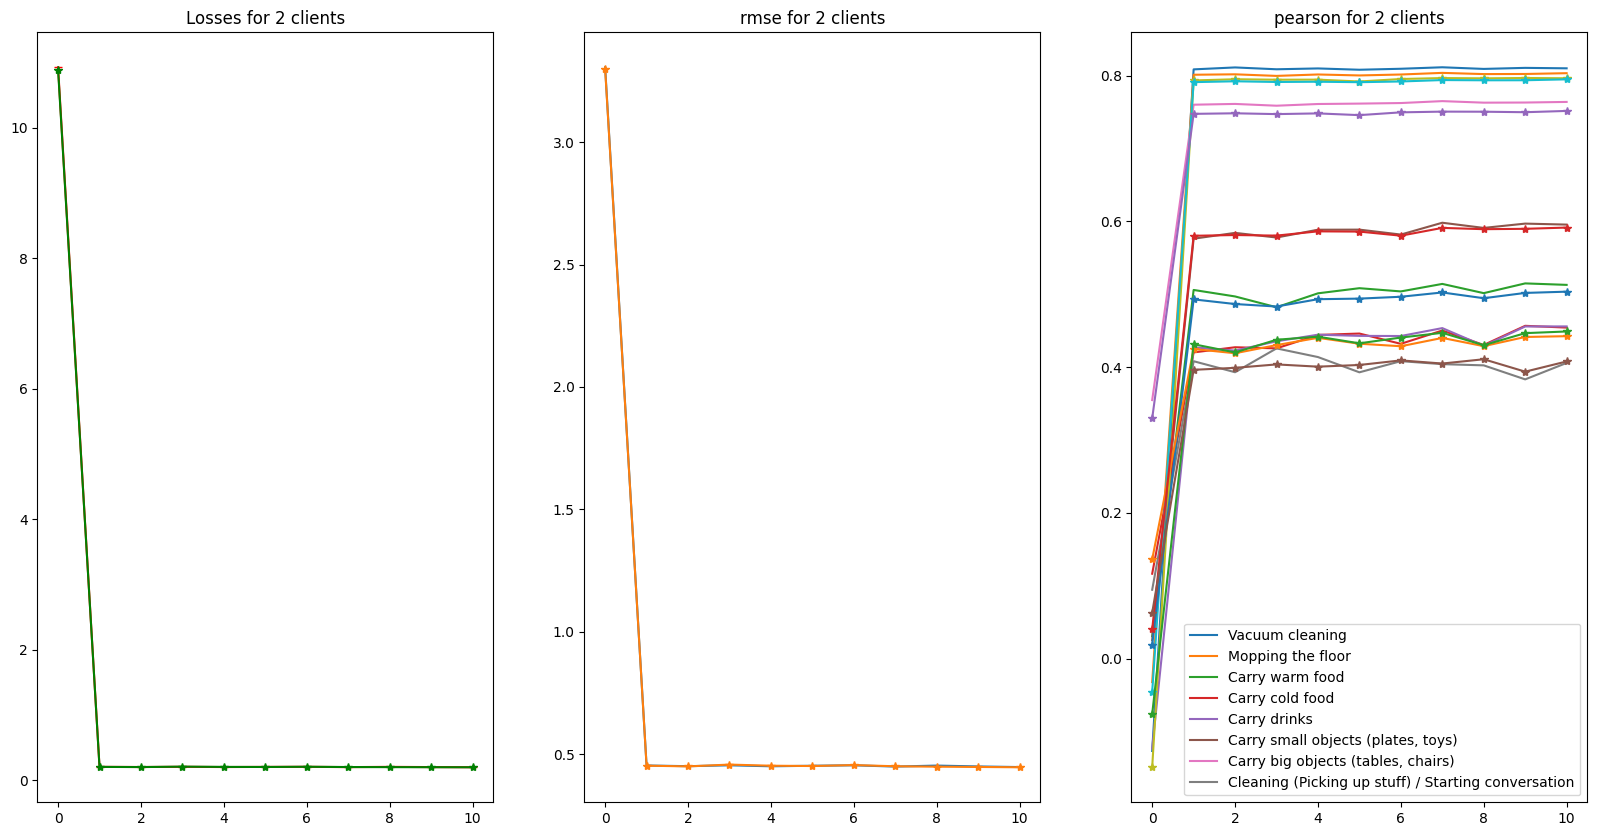

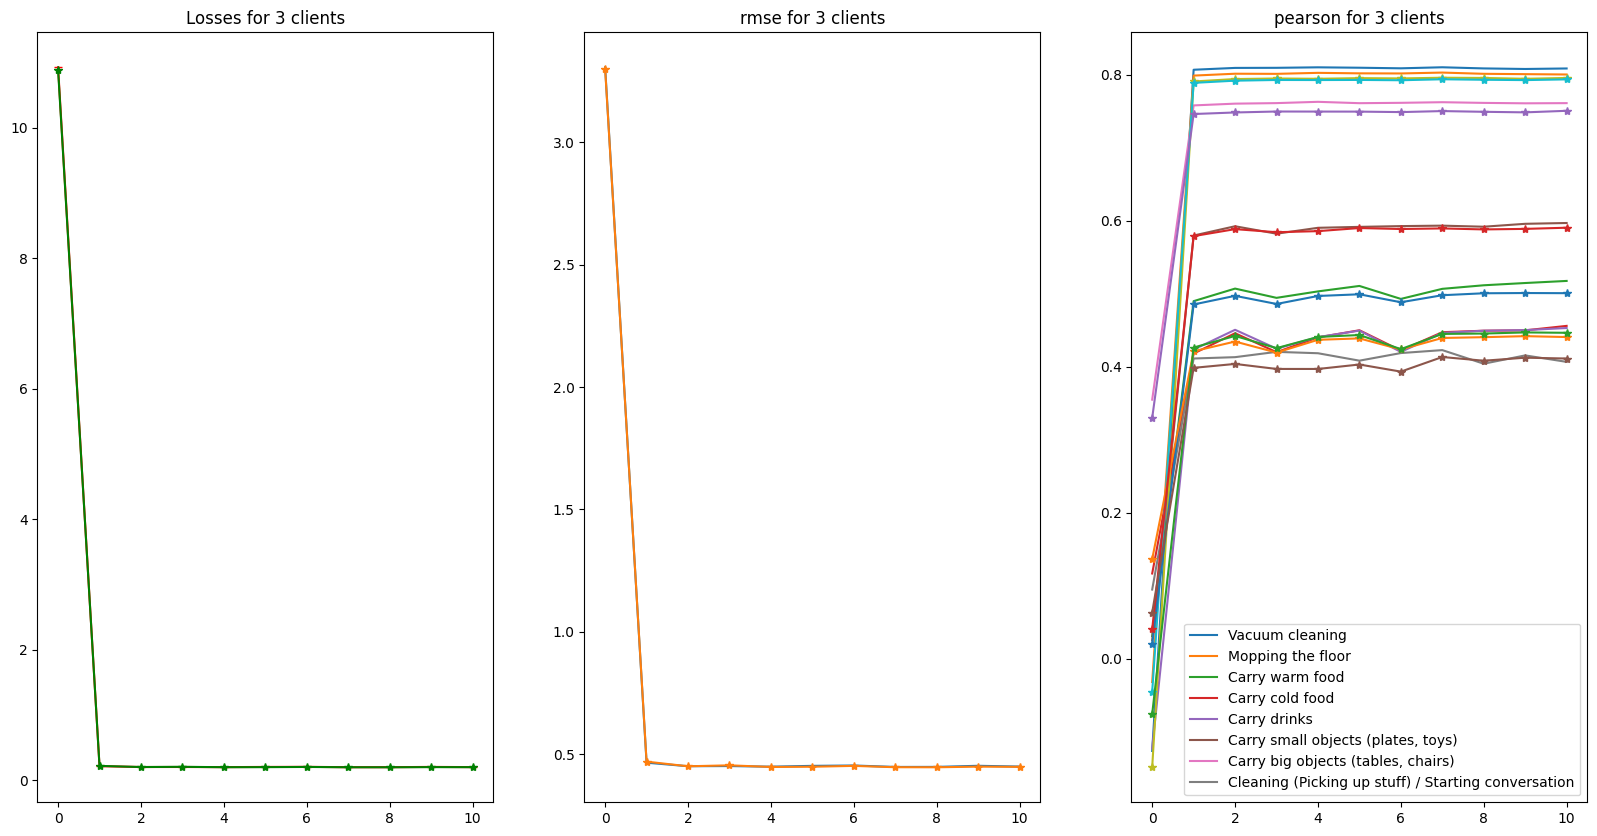

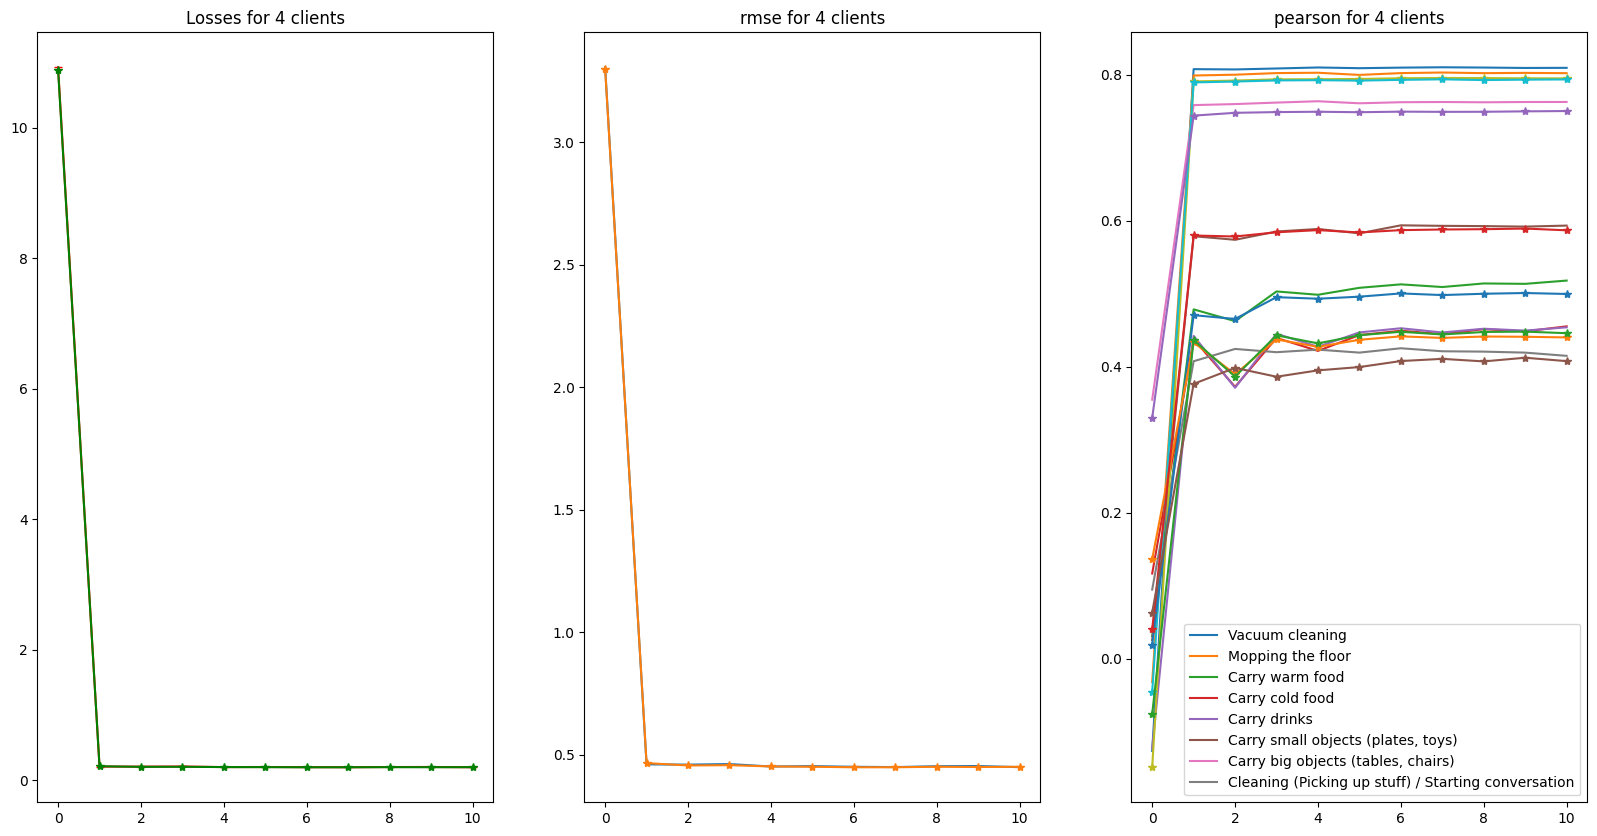

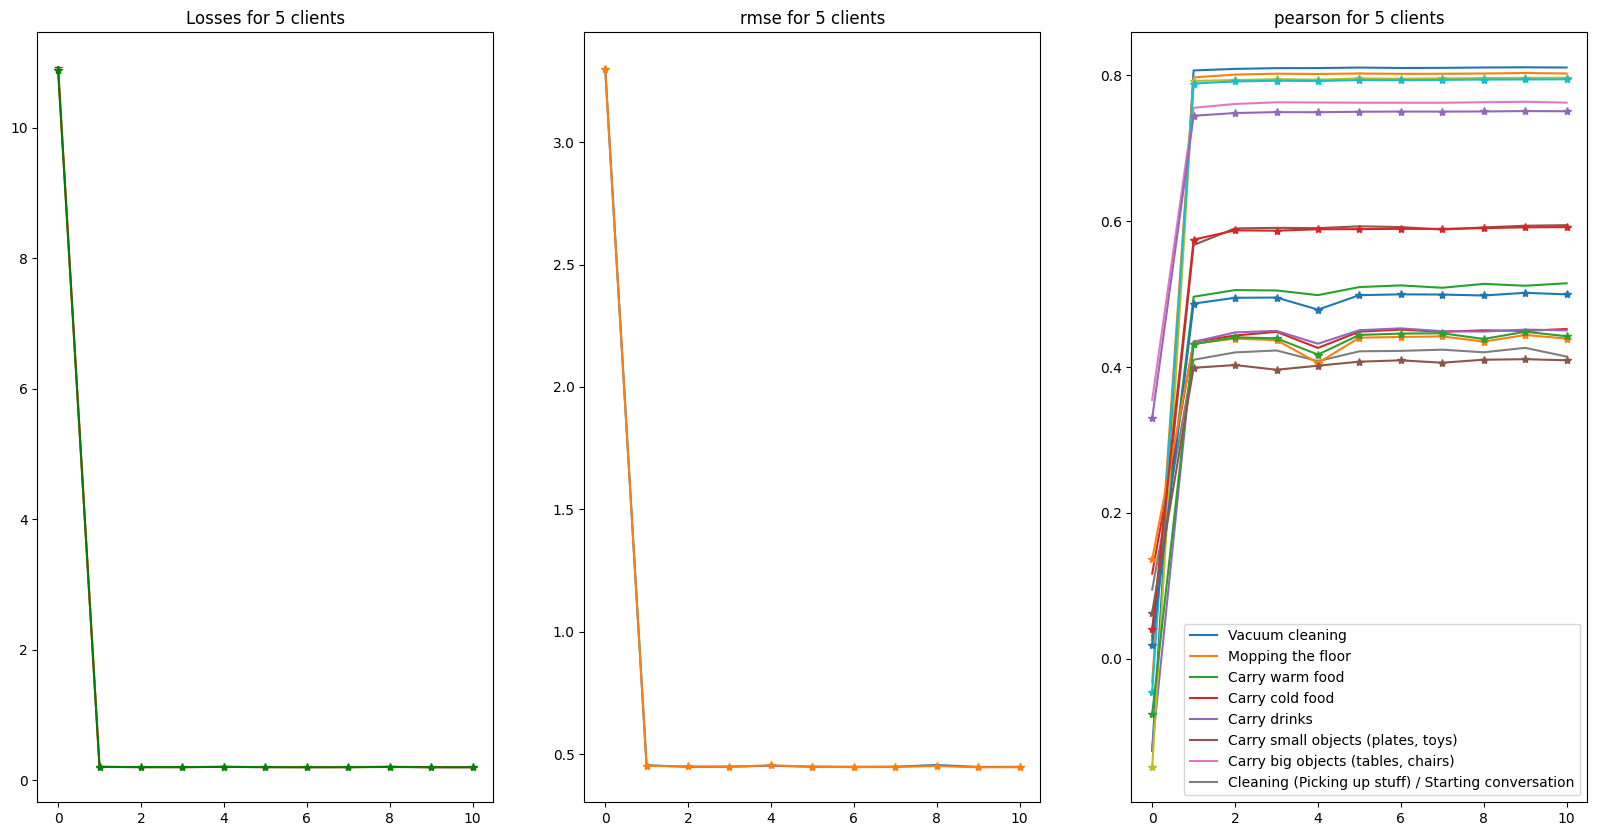

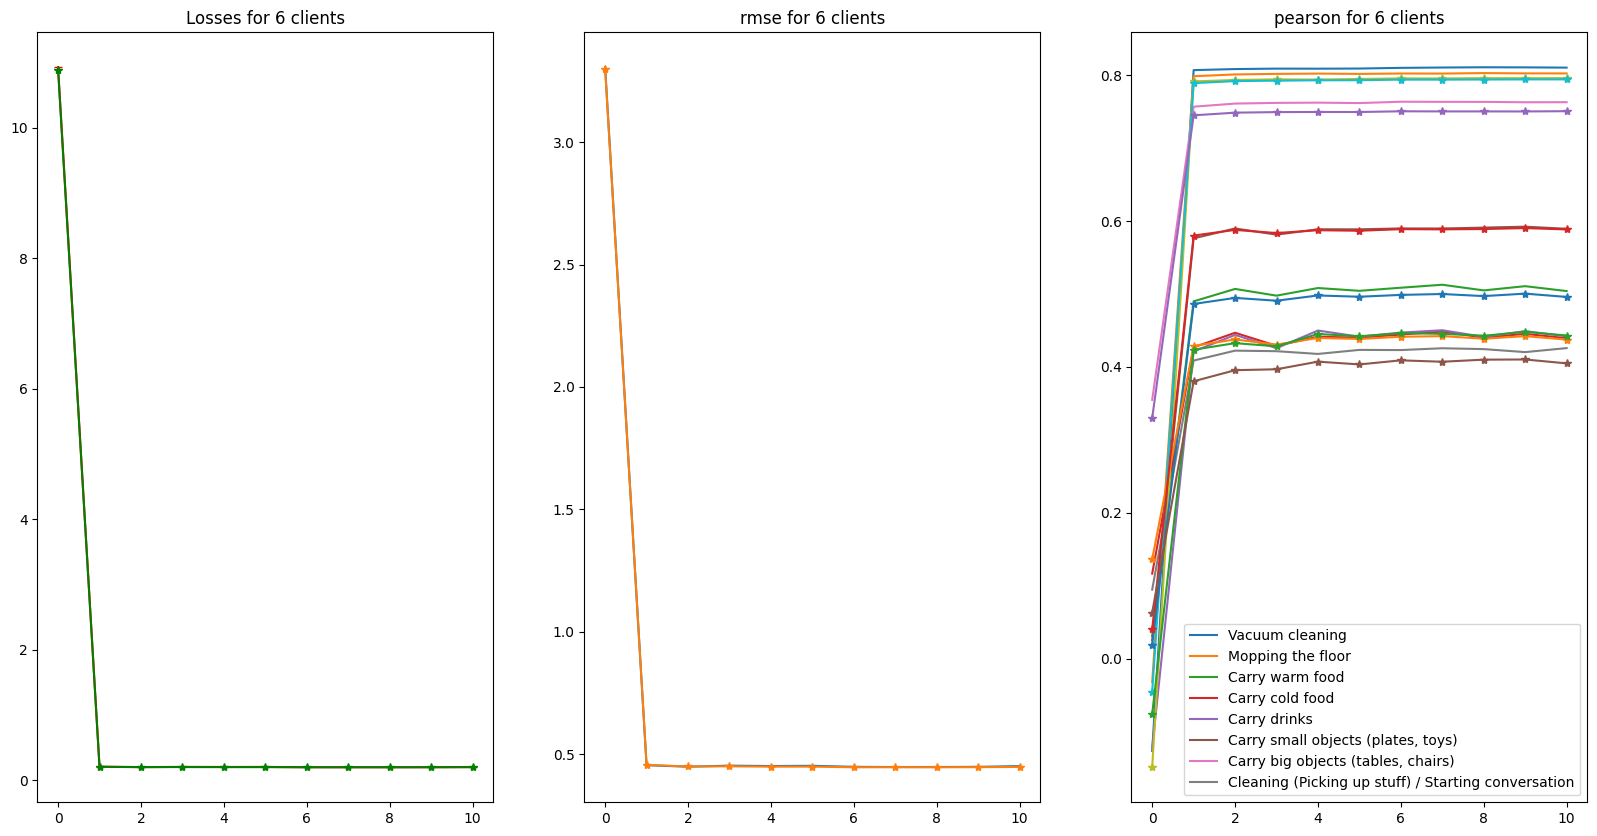

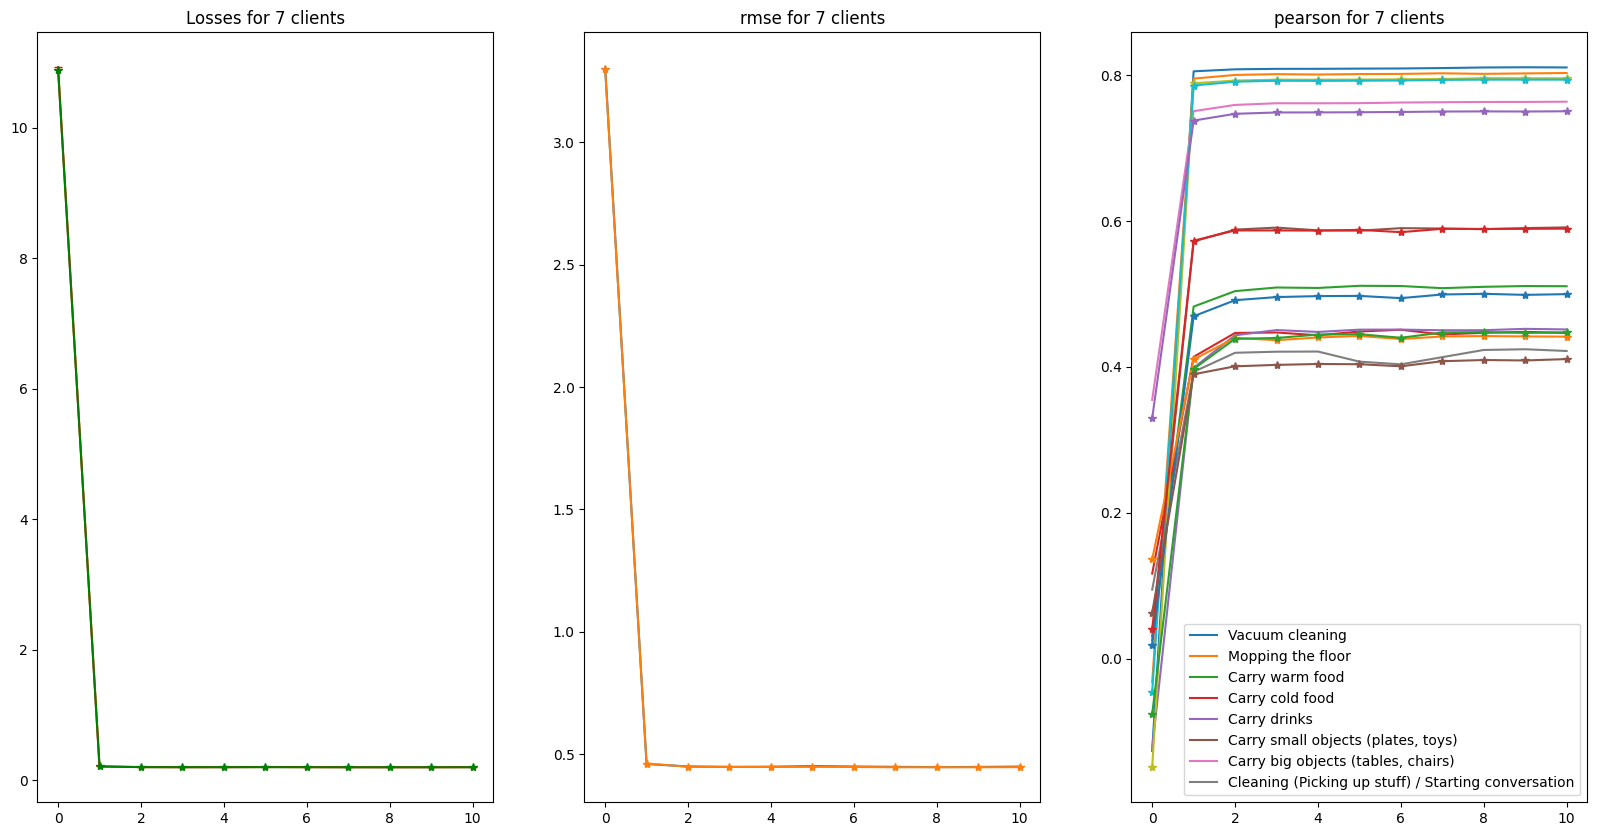

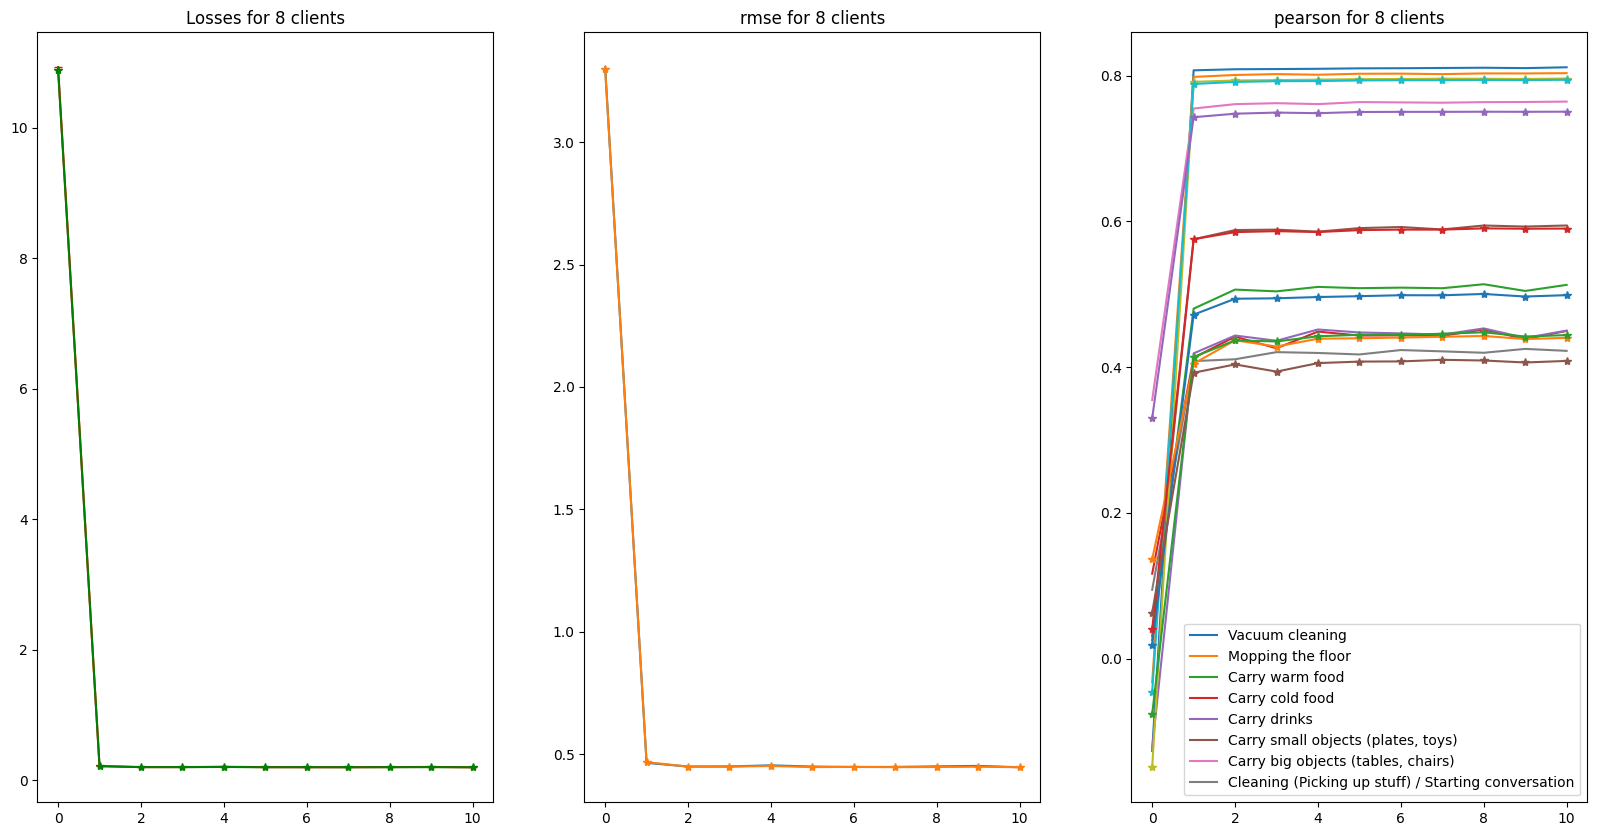

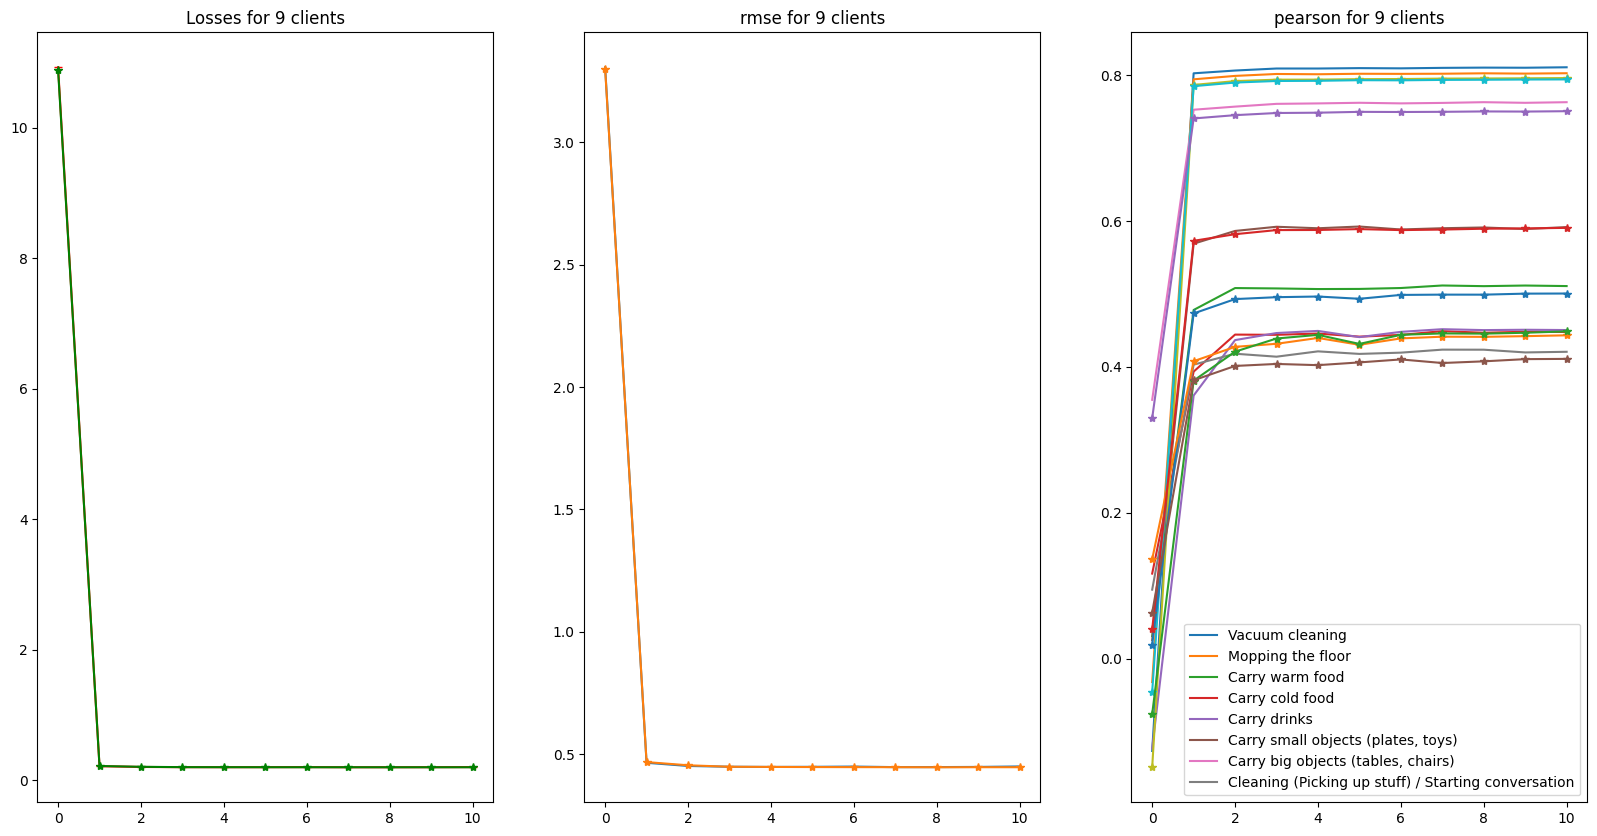

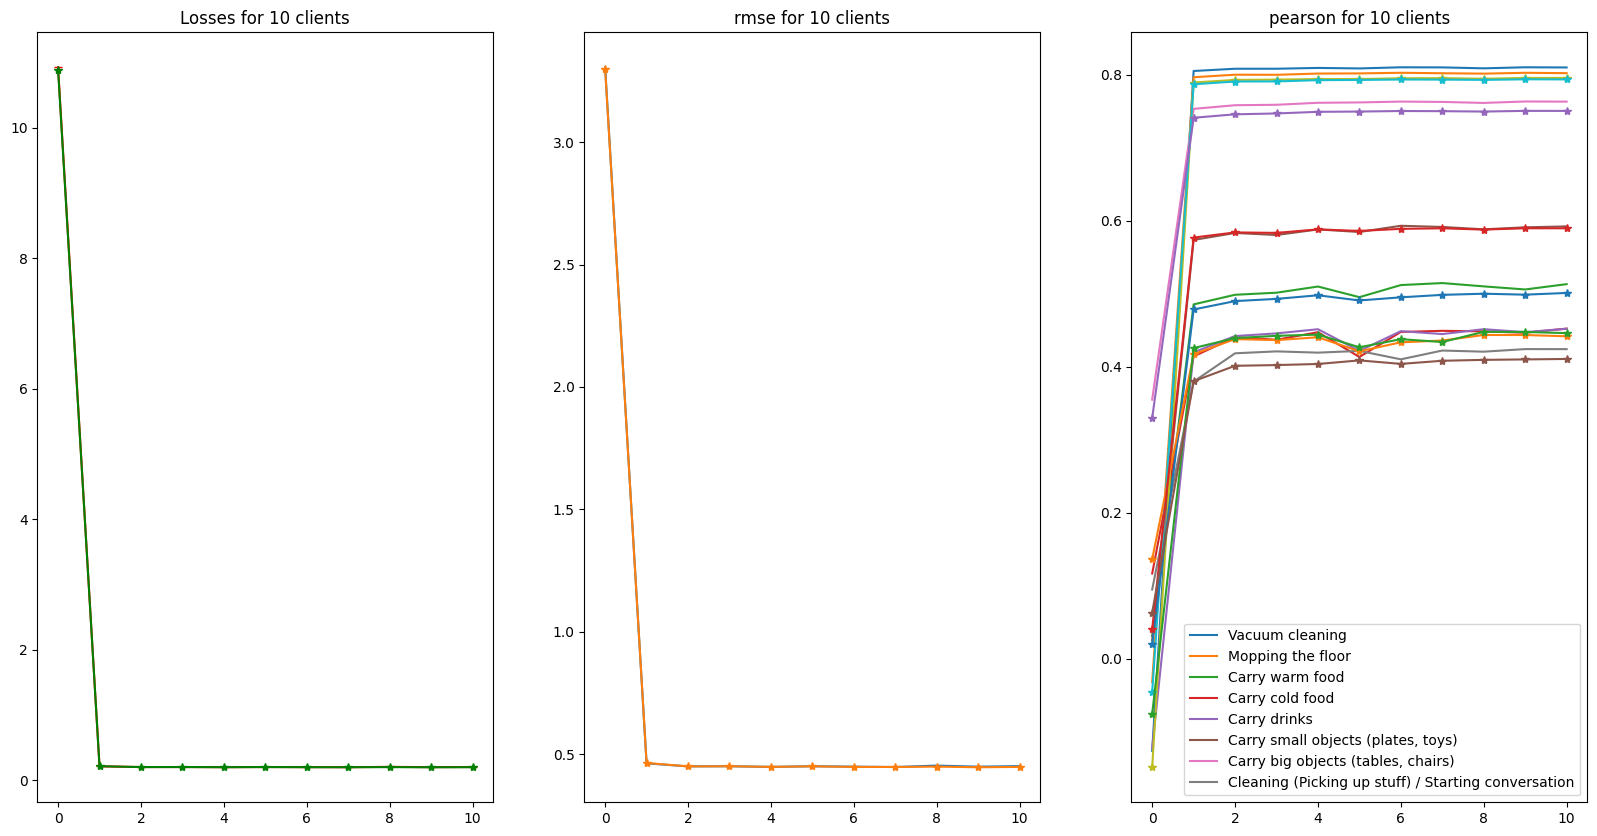

In [30]:
#for each client, plot losses, rmse in separate graphs and pearson of each label in a single graph with all labels marked in the legend
import matplotlib.pyplot as plt
for i in range(len(results)):
    plt.figure(figsize=(20,10))
    plt.subplot(1,3,1)
    plt.plot(results[i]['Losses'], marker='_', color='red')
    plt.title("Losses for "+str(results[i]['clients'])+" clients")
    # plt.figure(figsize=(10,5))
    plt.plot(results_train[i]['Losses'],marker='*', color='green')
    plt.subplot(1,3,2)
    plt.plot(results[i]['rmse'])
    plt.plot(results_train[i]['rmse'], marker='*')

    plt.title("rmse for "+str(results[i]['clients'])+" clients")
    plt.subplot(1,3,3)
    for j in range(len(y_labels)):
        plt.plot(results[i]['pearson'][y_labels[j]])
    for j in range(len(y_labels)):
        plt.plot(results_train[i]['pearson'][y_labels[j]],marker='*')
    plt.title("pearson for "+str(results[i]['clients'])+" clients")
    plt.legend(y_labels)
    plt.savefig(f"{path}/{i+2}/{strat}.png")


In [31]:
import json
for i in range(len(results)):
    with open(f"{path}/{i+2}/{strat}/"+str(results[i]['clients'])+"clients.json", "w") as outfile:
        json.dump(results[i], outfile)


In [32]:
#load the results from the path "/results/fedAvgN" and create a dataframe with losses, rmse and average pearson of every label for each client
import json
import os
results=[]
for i in range(2,11):
    with open(f"{path}/{i}/{strat}/"+str(i)+"clients.json") as json_file:
        results.append(json.load(json_file))
import pandas as pd
df=pd.DataFrame(results)
df.head()

,clients,Losses,rmse,pearson
0,2,"[10.927008628845215, 0.2059183567762375, 0.203...","[3.305602550506592, 0.4537822902202606, 0.4509...","{'Vacuum cleaning': [-0.126588276370235, 0.808..."
1,3,"[10.927008628845215, 0.21730081737041473, 0.20...","[3.305602550506592, 0.46615535020828247, 0.451...","{'Vacuum cleaning': [-0.126588276370235, 0.806..."
2,4,"[10.927008628845215, 0.2114417850971222, 0.210...","[3.305602550506592, 0.4598279595375061, 0.4586...","{'Vacuum cleaning': [-0.126588276370235, 0.807..."
3,5,"[10.927008628845215, 0.20671817660331726, 0.20...","[3.305602550506592, 0.4546627104282379, 0.4484...","{'Vacuum cleaning': [-0.126588276370235, 0.806..."
4,6,"[10.927008628845215, 0.20699310302734375, 0.20...","[3.305602550506592, 0.45496493577957153, 0.448...","{'Vacuum cleaning': [-0.126588276370235, 0.806..."


In [33]:
df=pd.DataFrame(results)


In [34]:
#add a new column named pearson_avg
df['pearson_avg']=[[] for i in range(len(df))]


In [35]:
df.head()

,clients,Losses,rmse,pearson,pearson_avg
0,2,"[10.927008628845215, 0.2059183567762375, 0.203...","[3.305602550506592, 0.4537822902202606, 0.4509...","{'Vacuum cleaning': [-0.126588276370235, 0.808...",[]
1,3,"[10.927008628845215, 0.21730081737041473, 0.20...","[3.305602550506592, 0.46615535020828247, 0.451...","{'Vacuum cleaning': [-0.126588276370235, 0.806...",[]
2,4,"[10.927008628845215, 0.2114417850971222, 0.210...","[3.305602550506592, 0.4598279595375061, 0.4586...","{'Vacuum cleaning': [-0.126588276370235, 0.807...",[]
3,5,"[10.927008628845215, 0.20671817660331726, 0.20...","[3.305602550506592, 0.4546627104282379, 0.4484...","{'Vacuum cleaning': [-0.126588276370235, 0.806...",[]
4,6,"[10.927008628845215, 0.20699310302734375, 0.20...","[3.305602550506592, 0.45496493577957153, 0.448...","{'Vacuum cleaning': [-0.126588276370235, 0.806...",[]


In [36]:
y_labels=list(df['pearson'][0].keys())

for i in range(df.shape[0]):
    li=[]
    for k in range(10):
        sum=0
        for j in range(len(y_labels)):
            sum=sum+df['pearson'][i][y_labels[j]][k]
        sum=sum/10
        li.append(sum)
    df['pearson_avg'][i]=li



/tmp/ipykernel_3639/1854403552.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pearson_avg'][i]=li
/tmp/ipykernel_3639/1854403552.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pearson_avg'][i]=li
/tmp/ipykernel_3639/1854403552.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pearson_avg'][i]=li
/tmp/ipykernel_3639/1854403552.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

In [37]:
for i in range(df.shape[0]):
  # mini=min(df['Losses'][i])
  # idx=df['Losses'][i].index(mini)
  # print(idx)
  idx=-1
  df['Losses'][i]=df['Losses'][i][idx]
  df['rmse'][i]=df['rmse'][i][idx]
  df['pearson_avg'][i]=df['pearson_avg'][i][idx]


/tmp/ipykernel_3639/3851578825.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Losses'][i]=df['Losses'][i][idx]
/tmp/ipykernel_3639/3851578825.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['rmse'][i]=df['rmse'][i][idx]
/tmp/ipykernel_3639/3851578825.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pearson_avg'][i]=df['pearson_avg'][i][idx]
/tmp/ipykernel_3639/3851578825.py:6: SettingWithCopyWarning: 
A value is 

In [38]:
df

,clients,Losses,rmse,pearson,pearson_avg
0,2,0.200162,0.447394,"{'Vacuum cleaning': [-0.126588276370235, 0.808...",0.478361
1,3,0.202733,0.450259,"{'Vacuum cleaning': [-0.126588276370235, 0.806...",0.479591
2,4,0.201047,0.448383,"{'Vacuum cleaning': [-0.126588276370235, 0.807...",0.479835
3,5,0.200771,0.448075,"{'Vacuum cleaning': [-0.126588276370235, 0.806...",0.481098
4,6,0.203618,0.451241,"{'Vacuum cleaning': [-0.126588276370235, 0.806...",0.479386
5,7,0.202048,0.449497,"{'Vacuum cleaning': [-0.126588276370235, 0.805...",0.480255
6,8,0.199386,0.446526,"{'Vacuum cleaning': [-0.126588276370235, 0.807...",0.477731
7,9,0.202707,0.45023,"{'Vacuum cleaning': [-0.126588276370235, 0.802...",0.479395
8,10,0.203492,0.4511,"{'Vacuum cleaning': [-0.126588276370235, 0.805...",0.479153


In [39]:
df.drop(['pearson'], axis=1, inplace=True)

In [40]:
for i in range(df.shape[0]):
  try:
    data=pd.read_csv(f"{path}/clients{i+2}.csv")
    data.drop(["Unnamed: 0"], axis=1, inplace=True)
  except:
    data=pd.DataFrame(columns=["methods", "Loss", "RMSE", "PCC"])
  # data=data.append(pd.Series(["FedAvg_NoAug",df['Losses'][i],df['rmse'][i],df['pearson_avg'][i]]), ignore_index=True)
  data=pd.concat([data,pd.Series([f"{strat}",df['Losses'][i],df['rmse'][i],df['pearson_avg'][i]] , index=data.columns ).to_frame().T])
  data.to_csv(f"{path}/clients{i+2}.csv")

